<img src="https://upload.wikimedia.org/wikipedia/it/thumb/0/04/Logo_Universit%C3%A0_degli_Studi_di_Milano.svg/1200px-Logo_Universit%C3%A0_degli_Studi_di_Milano.svg.png" width="100px" align="right" >
<img src="https://upload.wikimedia.org/wikipedia/it/b/be/Logo_Politecnico_Milano.png" align="right" width="136px" height="100px">

# Machine Learning 2020 course - Homework
### Bioinformatics for Computational Genomics 

# Protein Expression in Mice with Down Syndrome

<a href="#intro"><b>Introduction</b></a>
1. <a href="#clust"><b>Preliminary analysis and clustering</b></a>    
    1.1 Importing modules and data  
    1.2 Data visualization  
    1.3 Clustering  
    1.4 Conclusions
2. <a href="#class"><b>Classification</b></a>   
    2.1 Importing modules and data  
    2.2 Logistic regression  
    2.3 Linear discriminant analysis  
    2.4 Quadratic discriminant analysis  
    2.5 Support Vector Machines  
    2.6 K-neighbors classifier  
    2.7 Conclusions
3. <a href="#regr"><b>Regression</b></a> 
4. <a href="#reco"><b>Data recovery and classification</b></a>   
    4.1 Data recovery  
    4.2 Classification
5. <a href="#recap"><b>Recap</b></a>

<div id="intro"></div>

# Introduction

The data set consists of the expression levels of 77 proteins/protein modifications and a label that classifies the mice according to the genotype, the type of stimulus and the treatment.
- `c-CS-s` : control mice, stimulated to learn, injected with saline 
- `c-CS-m` : control mice, stimulated to learn, injected with memantine 
- `c-SC-s` : control mice, not stimulated to learn, injected with saline 
- `c-SC-m` : control mice, not stimulated to learn, injected with memantine
- `t-CS-s` : trisomy mice, stimulated to learn, injected with saline 
- `t-CS-m` : trisomy mice, stimulated to learn, injected with memantine 
- `t-SC-s` : trisomy mice, not stimulated to learn, injected with saline 
- `t-SC-m` : trisomy mice, not stimulated to learn, injected with memantine.  

The goal is to classify mice into 8 different classes, based on protein expression. The data is already split into a training and a test set. In this notebook, we will:
- perform an exploratory analysis on the training data to visualize the features
- group the samples comparing different clustering algorithms to identify structure in the training data
- apply classification algorithms to classify the mice in the eight classes based on protein expression
- train a regressor to learn the value of one of the proteins (SOD1_N) from the other protein expression values
- perform feature selection and identify the most relevant proteins
- recover SOD1_N feature in the test set and evaluate classifier performance

*Note: zooming out is recommended because some graphs are really large*

<div id="clust"></div>

# 1. Preliminary analysis and clustering
1.1 <a href="#1.1">Importing modules and data</a>  
1.2 <a href="#1.2">Data visualization</a>   
1.3 <a href="#1.3">Clustering</a>  
&nbsp;&nbsp;&nbsp;&nbsp;1.3.1 Hierarchical    
&nbsp;&nbsp;&nbsp;&nbsp;1.3.2 K-means  
&nbsp;&nbsp;&nbsp;&nbsp;1.3.3 Dimensionality reduction    
&nbsp;&nbsp;&nbsp;&nbsp;1.3.4 DBSCAN  
1.4 <a href="#1.4">Conclusions</a>

<div id="1.1"></div>

## 1.1 Importing modules and data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.feature_selection import mutual_info_classif
np.random.seed(0)
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

The data is already split into a training and a test dataset and we import both as Pandas dataframes. However, for this first section we are only going to focus on the training data.

In [2]:
# Read the data and creates a pandas DataFrame
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0    0.650511  1.158653  0.580172  2.230388  3.179675  0.533686  0.440101   
1    0.365907  0.651296  0.810468  2.597217  4.131603  0.537554  0.249235   
2    0.260145  0.397996  0.229522  2.643311  4.303648  0.268394  0.050916   
3    0.239489  0.271240  0.766816  1.872419  2.424971  0.322269  0.386791   
4    0.617112  0.751737  0.050685  2.356175  3.494138  0.506875  0.310644   
..        ...       ...       ...       ...       ...       ...       ...   
362  0.265617  0.318703  0.062552  2.190572  3.028526  0.314935  0.293579   
363  0.371998  0.683835  0.088809  2.264053  3.901498  0.308142  0.256376   
364  0.853106  1.048825  0.422033  2.037549  3.480993  0.402487  0.125134   
365  0.523508  0.846670  0.777588  2.493568  4.117986  0.229136  0.193073   
366  0.268021  0.148416  0.495106  1.907162  2.712791  0.457461  0.083159   

     pCAMKII_N   pCREB_N    pELK_N  ...     SHH_N     BAD_N     pS6_N  \
0     5.033898  0.200985  1.589221  ...  0.047287  0.337121  0.203356   
1     6.099538  0.226362  1.700578  ...  0.521112  0.419544  0.231619   
2     3.130455  0.273792  2.534531  ...  0.047407  0.053130  0.096325   
3     2.351832  0.034265  0.472725  ...  0.273651  0.162382  0.234056   
4     3.855825  0.309879  1.033428  ...  0.172488  0.014086  0.191145   
..         ...       ...       ...  ...       ...       ...       ...   
362   5.647761  0.194538  1.293860  ...  0.281070  0.169755  0.070476   
363   4.628201  0.045254  1.405705  ...  0.380423  0.346237  0.256601   
364   2.216711  0.116000  2.158211  ...  0.364075  0.099125  0.040736   
365   2.650853  0.001629  1.536754  ...  0.220932  0.191266  0.049275   
366   4.814792  0.345000  1.308648  ...  0.304764  0.108574  0.683065   

      pCFOS_N     SYP_N  H3AcK18_N    EGR1_N  H3MeK4_N    CaNA_N   class  
0    0.191360  0.590874   0.112145  0.110109  0.160637  1.329248  t-CS-m  
1    0.393897  0.252572   0.352687  0.085545  0.328537  1.008023  t-SC-s  
2    0.257402  0.246015   0.203979  0.039188  0.008315  1.193634  c-SC-s  
3    0.180657  0.351388   0.103896  0.302341  0.166020  0.689970  c-CS-m  
4    0.149622  0.310434   0.151685  0.180055  0.383039  1.737274  t-CS-s  
..        ...       ...        ...       ...       ...       ...     ...  
362  0.246973  0.420950   0.144801  0.198893  0.198080  1.132259  c-SC-m  
363  0.158367  0.139080   0.422385  0.115629  0.389457  1.104580  c-SC-m  
364  0.530906  0.379040   0.046529  0.075847  0.068273  1.243315  t-CS-m  
365  0.063009  0.541193   0.335438  0.218873  0.081170  1.161350  t-CS-s  
366  0.180120  0.399666   0.121613  0.049929  0.157915  1.067880  c-SC-m  

[367 rows x 77 columns]

We define "helper" datasets that contain only protein expression and we separate the class labels from the features.

In [3]:
X_train_pd = train.drop("class",axis=1)
X_test_pd = test.drop("class",axis=1)
y_train = train["class"]
y_test = test["class"]
classes = np.sort(y_train.unique())
proteins = X_train_pd.columns

We define a dataset in which the samples are sorted by class. This is going to be useful for data visualization and plotting.

In [4]:
sorttrain=train.sort_values(by=["class"])
sorttrain=sorttrain.reset_index()

<div id="1.2"></div>

## 1.2 Data visualization

First, we visualize the features using the `seaborn` package. We plot the counts for each class and then the distribution for the protein values.

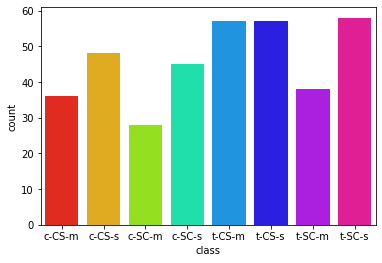

In [5]:
colors=sns.hls_palette(9, l=.5, s=1)
del colors[3]
sns.countplot(x="class",data=sorttrain,palette=colors)

To plot the distribution of the protein expression values we make a violinplot for each protein. To make the plot more aesthetically pleasing we sort them from the most variable to the least variable.

In [6]:
# for simplicity i consider variability as the range max-min.
mi=np.array(X_train_pd.agg([min]))
ma=np.array(X_train_pd.agg([max]))
ran=(ma-mi).flatten()
o=pd.Index(ran.argsort()[::-1])
sortprot=proteins[o]
#sortprot

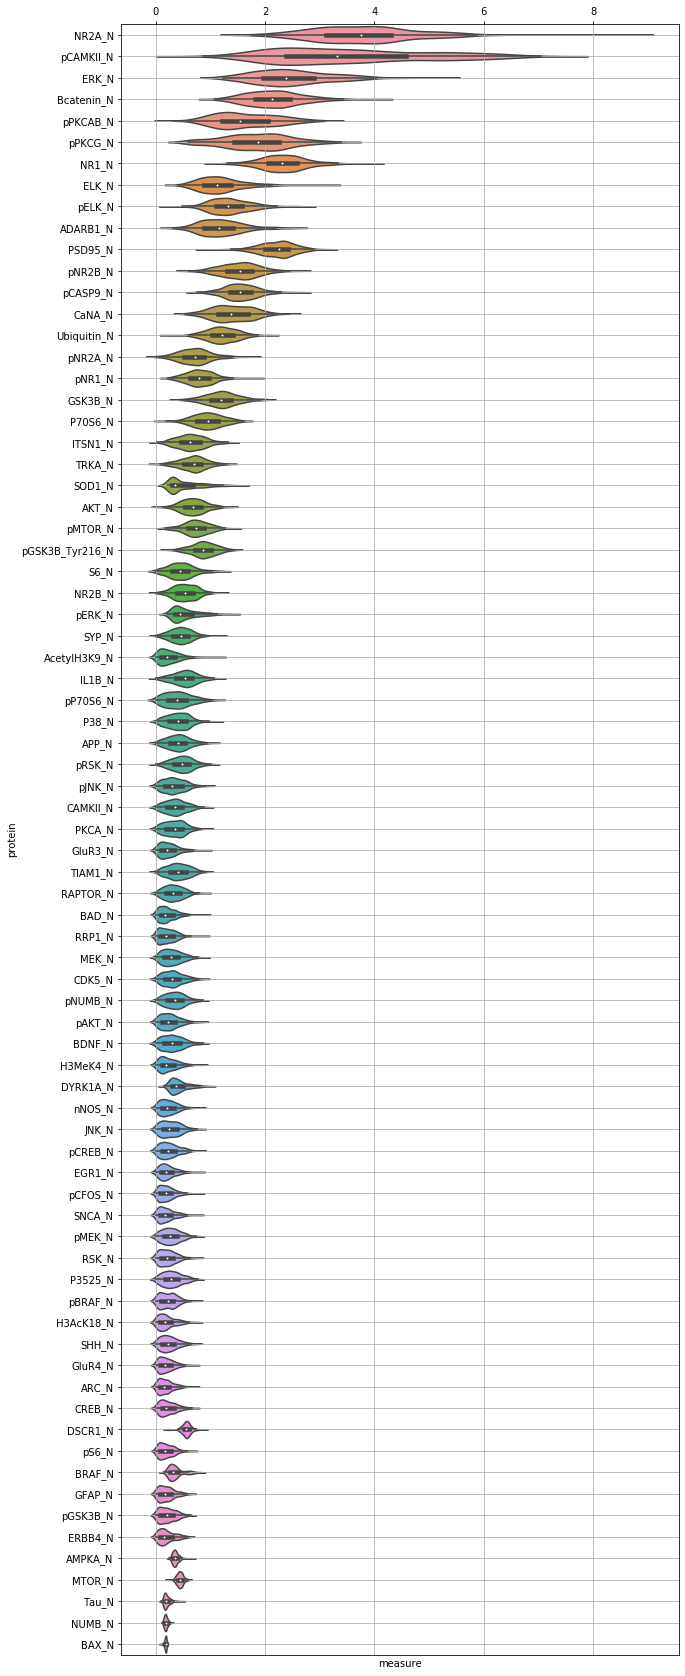

In [7]:
#violin plot with all protein levels, sorted by maximum range 
fig=plt.figure(figsize=(10,30))
a=sns.violinplot(data=X_train_pd,orient="h",scale="count",order=sortprot)
a.set(xlabel='measure', ylabel='protein')
a.xaxis.set_ticks_position('top')
plt.grid()
#scale violinplots by count

We can see that some proteins have a wide range of values, while others are on a smaller scale.

Next we check for correlation between protein values with a heatmap.

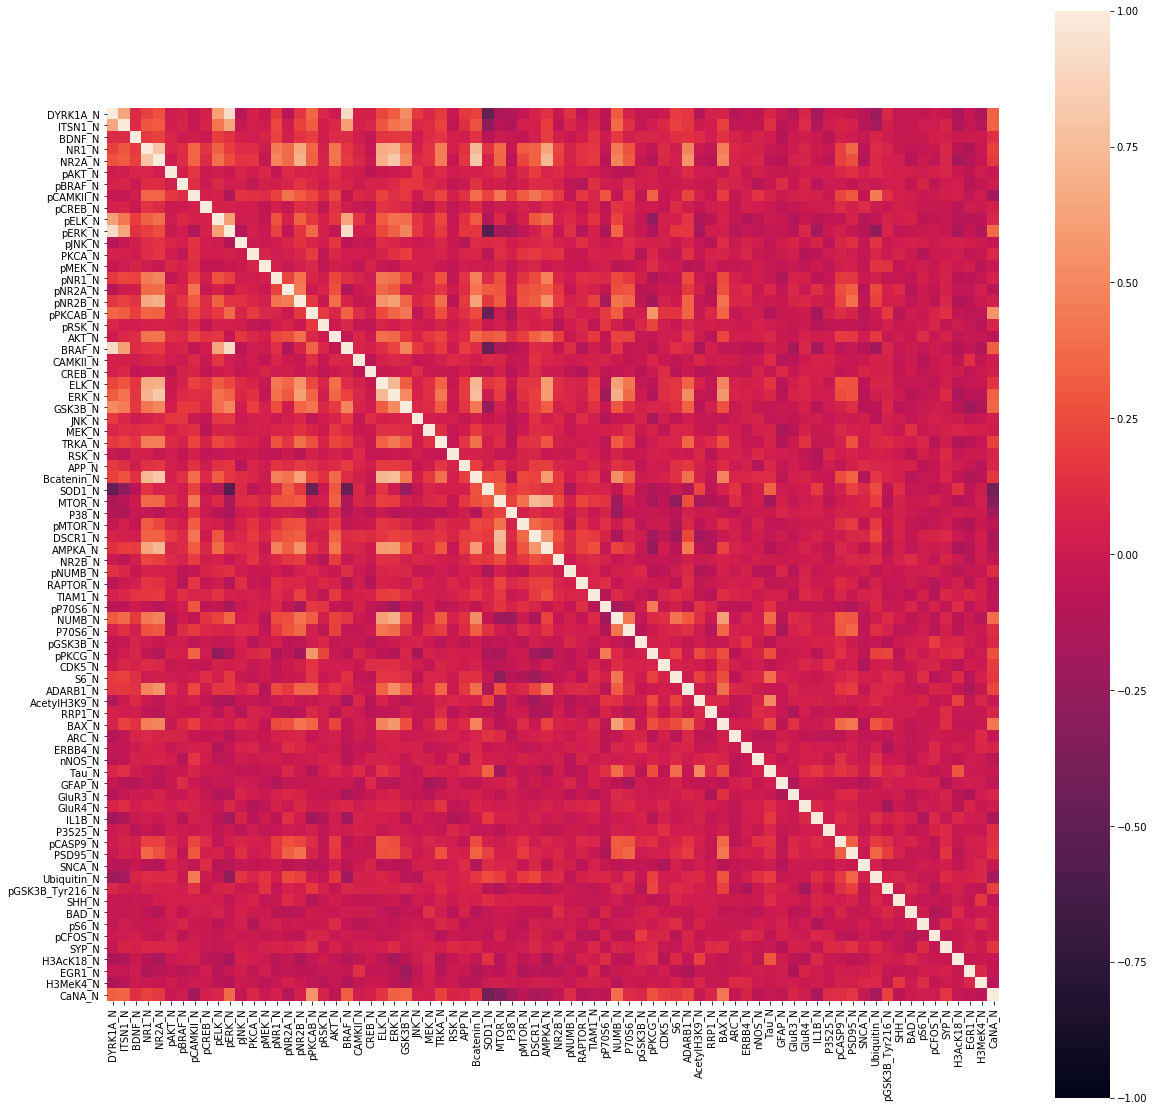

In [8]:
fig=plt.figure(figsize=(20,20))
cormat=X_train_pd.corr()
sns.heatmap(cormat,vmin=-1,vmax=1,square=True)

There are some strong correlations, both positive and negative, so we might be worried about colinearity in the data.

To visually inspect the relationship between each protein and the eight classes we will plot a heatmap of protein level, grouping the samples based on their class. We scale the values along the columns so for each protein measurement we subtract the minimum value of that protein and divide by its maximum. This is so all the features are on the same scale. We want to see if there are **patterns** in the protein levels according to the class.

In [9]:
#this first part is to assign the colors to each class
coldict=pd.DataFrame((zip(classes,colors)))
coldict.columns=["class","color"]
#then we make a new column in the dataframe with the right color.
#sorttrain is for the first plot and the samples are sorted by class
#while coltrain is for clustering and the samples are left in their original order
sorttrain=sorttrain.merge(coldict,how="left")
coltrain=train.merge(coldict,how="left")

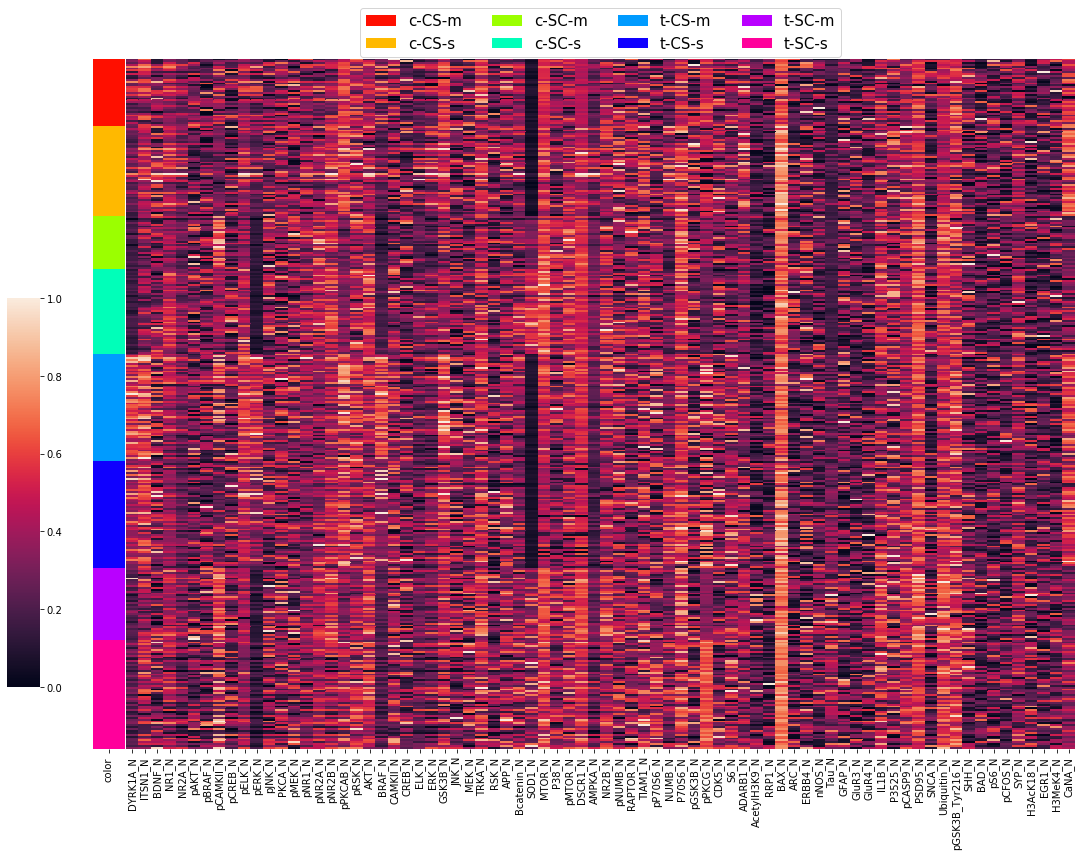

In [10]:
#we remove y labels because they don't mean anything since this is the sorted dataset
g=sns.clustermap(sorttrain.iloc[:,1:77],
               standard_scale=1,row_cluster=False,row_colors=sorttrain["color"],
              col_cluster=False,figsize=(15,12),yticklabels=False,
              xticklabels=True,square=False,dendrogram_ratio=0.07)
#this part is for plotting the legend of classes - colors. thanks to 
#https://stackoverflow.com/questions/27988846/how-to-express-classes-on-the-axis-of-a-heatmap-in-seaborn
for label in range(8):
    g.ax_col_dendrogram.bar(0, 0, color=coldict["color"][label],
                            label=coldict["class"][label], linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=4,fontsize=15,markerscale=2)
g.cax.set_position([0,.2,.03,.45])

We can see that some genes seem more correlated to specific classes. For example **pERK_N** and **BRAF_N** are higher in `control-shock` mice while **SOD1_N** is lower. Also, we see that mice that received the same stimulus are more similar.

We can quantify this relation using the **mutual information** index from the `scikit-learn` package to learn the relationship between a numerical and a categorical variable. The MI goes from 0 to infinity and is higher when knowing a variable gives us information about the value of another variable. In this case we compute the mutual information between each protein and the "class" variable.

In [11]:
mi_index = sklearn.feature_selection.mutual_info_classif(X_train_pd,train["class"])
#we get a sorted index of this list from highest to lowest
p = mi_index.argsort()[::-1]
#we get a list of proteins sorted by highest MI
impoprot=list(proteins[p])
#we check the first 20 proteins
print("The 20 most important features are",impoprot[0:20])

The 20 most important features are ['pPKCG_N', 'SOD1_N', 'pERK_N', 'BRAF_N', 'DYRK1A_N', 'Tau_N', 'DSCR1_N', 'CaNA_N', 'pPKCAB_N', 'pCAMKII_N', 'NUMB_N', 'AMPKA_N', 'MTOR_N', 'pNR2B_N', 'Ubiquitin_N', 'ADARB1_N', 'NR2A_N', 'AcetylH3K9_N', 'GSK3B_N', 'ITSN1_N']


Let's repeat this process separately for each class and extract the 10 most important features.

In [12]:
maxinfo={}
varproteins=[]
mi_pd = pd.DataFrame(columns=proteins)

In [13]:
#max info will contain: class, 10 most informative genes, MI for those.
#vargenes will contain all the 10 most informative genes for all 8 classes (total 80)
for c in classes:
    mi_class=sklearn.feature_selection.mutual_info_classif(X_train_pd, y_train==c)
    newrow=pd.Series(mi_class,index=proteins,name=c)
    mi_pd=mi_pd.append(newrow)
    p_class=mi_class.argsort()
    sortedproteins=list(proteins[p_class])[::-1]
    varproteins+=sortedproteins[0:10]
    maxinfo[c]={"proteins":sortedproteins[0:10],"MI":list(mi_class[p_class][::-1][0:10])}

For each class, we plot the 10 most informative features and their score. We can see that some proteins are related to more than one class, like **pPKCG_N**.

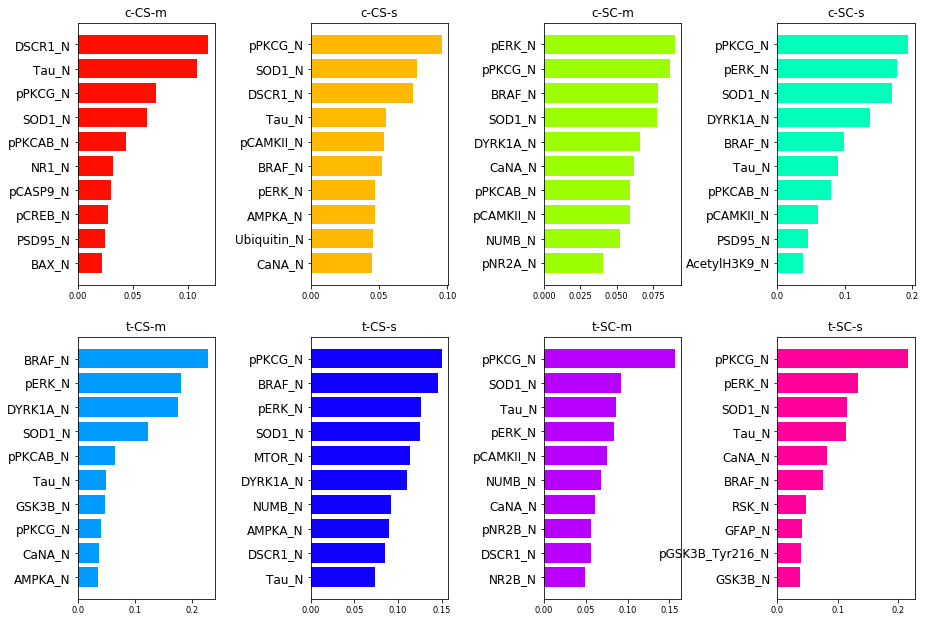

In [14]:
plt.close()
i=1
fig=plt.figure(figsize=(15,4))
plt.subplots_adjust(top=5,bottom=3)
fig.subplots_adjust(wspace=0.7,hspace=0.2)
for c in classes:
    a=fig.add_subplot(2,4,i)
    i+=1
    plt.barh(maxinfo[c]["proteins"],maxinfo[c]["MI"],color=coldict[coldict["class"]==c]["color"])
    plt.title(c)
    plt.xticks(size="small")
    plt.yticks(size="large")
    a.invert_yaxis()

In [15]:
plt.close()

<div id="1.3"></div>

## 1.3 Clustering
### 1.3.1 Hierarchical

We perform clustering to see if data points from the same class group together.
First, we'll take advantage of the `clustermap` function to perform and visualize a hierarchical clustering, by setting the `row_cluster` parameter to **`True`**. As before, we color each sample according to its class.  
In distance-based clustering we need to choose the type of distance computed (e.g. Euclidean, cosine similarity) and how the clusters are merged (linkage: complete, single, average). This will affect our results. In this section, we will show only the parameters that gave the best results.

C:\Users\kikka\anaconda3\lib\site-packages\seaborn\matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2160x1440 with 0 Axes>

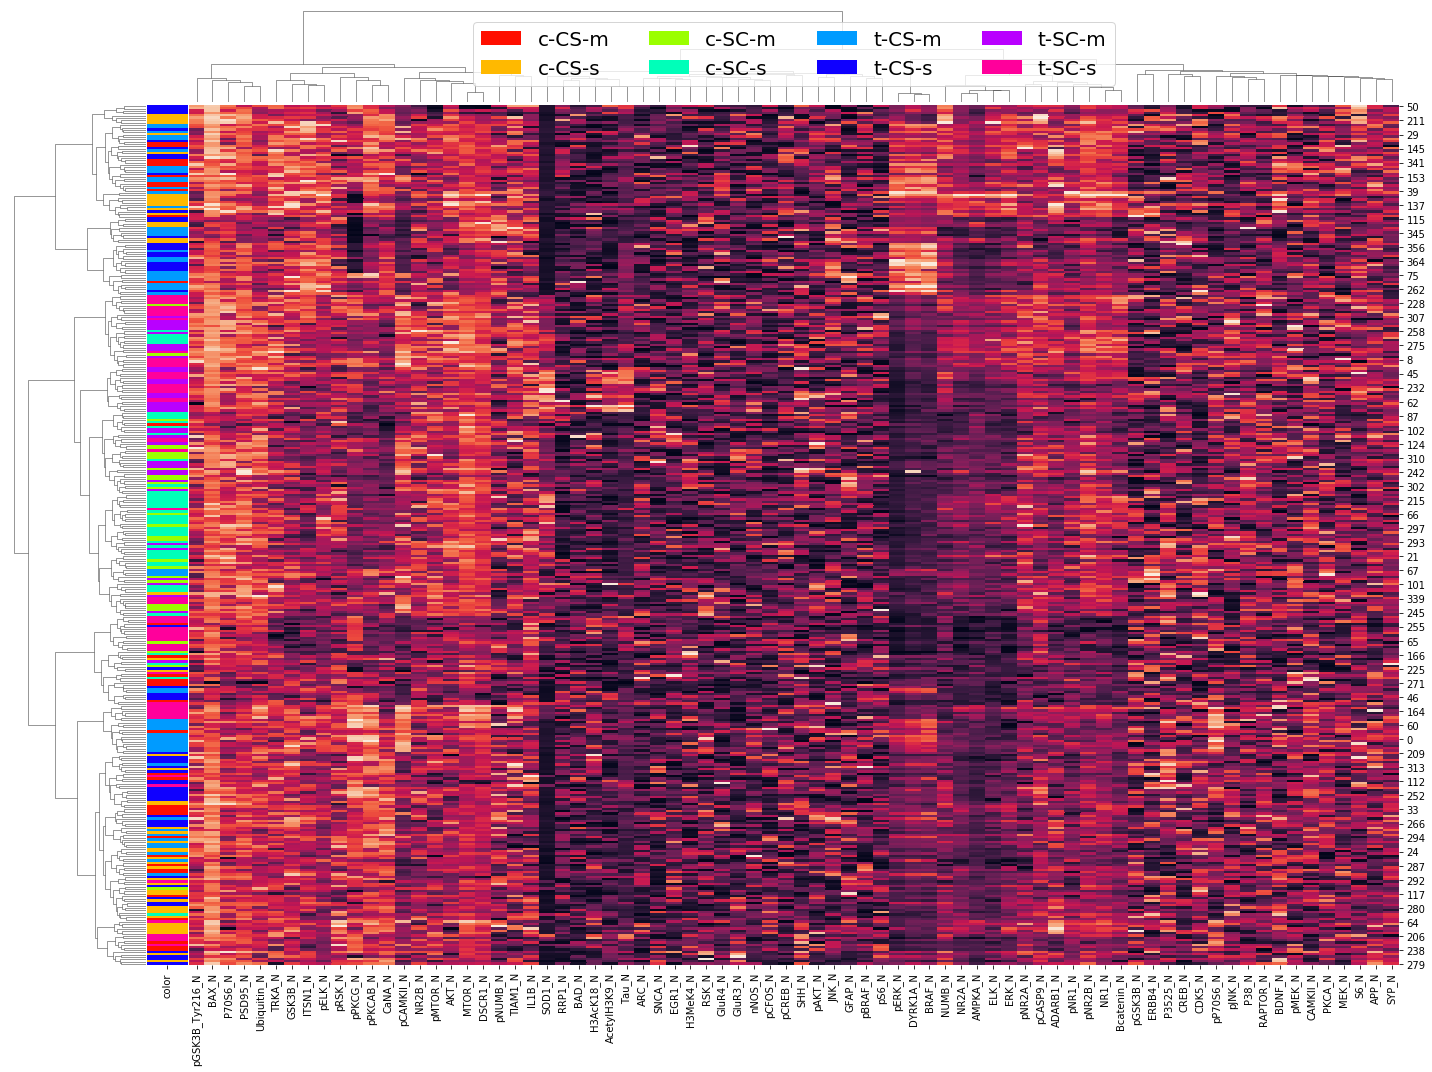

In [16]:
metr="euclidean"
link="ward"
fig=plt.figure(figsize=(30,20))
g=sns.clustermap(coltrain.iloc[:,0:76],metric=metr,method=link,
               standard_scale=1,row_cluster=True,row_colors=coltrain["color"],
              col_cluster=True,figsize=(20,15),cbar_pos=None,
              xticklabels=True,square=False,dendrogram_ratio=0.1)
#this part is for plotting the legend of colors
for label in range(8):
    g.ax_col_dendrogram.bar(0, 0, color=coldict["color"][label],
                            label=coldict["class"][label], linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=4,fontsize=20,markerscale=2)

It does not look like we can separate well samples of the same class. However, the samples tend to group together according to the type of stimulus: the red and blue correspond to `control-shock`, while green and purple to `shock-control`.  
To quantify the **goodness of fit** we use the standard `scikit-learn` API to compute some GOF metrics. We can compute **internal** indexes, to quantify how well the clusters are separated without any external information, but since we have the real class labels, we can also compute **external** indexes to see how well our clusters match the classes.

First we fit a hierarchical clustering model on the data and then we predict the cluster labels with the function `fit_predict`.

In [17]:
distance_threshold=None
n_clusters=8
model = AgglomerativeClustering(n_clusters=n_clusters, 
                                distance_threshold=distance_threshold, 
                                affinity=metr, linkage=link)
#cluster labels
y_predict = model.fit_predict(X_train_pd)

Next we define some functions that we need to plot and quantify the GOF measures.

In [18]:
def plot_dendrogram(Z=None, model=None, X=None, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)

    # Reconstruct the linakge matrix if the standard model API was used
    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                              counts]).astype(float)
        else:
            Z = linkage(X, method=model.linkage, metric=model.affinity)
    
    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        # Set the cut point just above the last but 'n_clusters' merge
        kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-6
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    # Plot the corresponding dendrogram
    ddata = dendrogram(Z, ax=ax, **kwargs) 
    
    # Annotate nodes in the dendrogram
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        nid = np.where(Z[:,2] == y)[0][0]
        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate(str(nid-Z.shape[0]), (x, y), xytext=(0, -5),
                         textcoords='offset points',
                         va='top', ha='center')
    if kwargs['color_threshold']:
        plt.axhline(y=kwargs['color_threshold'], c='k')
    
    return fig, ax

def incidence_mat(y_pred):
    npoints = y_pred.shape[0]
    mat = np.zeros([npoints, npoints])
    # Retrieve how many different cluster ids there are
    clusters = np.unique(y_pred)
    nclusters = clusters.shape[0]
    
    for i in range(nclusters):
        sample_idx = np.where(y_pred == i)
        # Compute combinations of these indices
        idx = np.meshgrid(sample_idx, sample_idx)
        mat[idx[0].reshape(-1), idx[1].reshape(-1)] = 1
        
    return mat

def similarity_mat(X, metric):
    dist_mat = pairwise_distances(X, metric=metric)
    min_dist, max_dist = dist_mat.min(), dist_mat.max()
    
    sim_mat = 1 - (dist_mat - min_dist) / (max_dist - min_dist)
    return sim_mat

def correlation(X, y_pred, metric):
    inc = incidence_mat(y_pred)
    sim = similarity_mat(X, metric)
    
    # Note: we can eventually remove duplicate values
    # only the upper/lower triangular matrix
    # triuidx = np.triu_indices(y_pred.shape[0], k=1)
    # inc = inc[triuidx]
    # sim = sim[triuidx]
    
    inc = normalize(inc.reshape(1, -1))
    sim = normalize(sim.reshape(1, -1))
    corr = (inc @ sim.T)
    return corr[0,0]   

def sorted_sim(sim, y_pred):
    idx_sorted = np.argsort(y_pred)
    # Sort the rows
    sim = sim[idx_sorted]
    # Sort the columns
    sim = sim[:, idx_sorted]
    
    return sim

def plot_sorted_sim(sim, y_pred):
    sim = sorted_sim(sim, y_pred)
    
    fig, ax = plt.subplots(figsize=(40,30))  
    ax = sns.heatmap(sim, ax=ax, cmap="rainbow")
    # Remove ruler (ticks)
    ax.set_yticks([]) 
    ax.set_xticks([])

def get_Ncounts(y_predict, y_true, k, j=None):
    N = y_true.shape[0]
    Nk_mask = y_predict == k
    Nk = Nk_mask.sum()
    Nj, Nkj = None, None
    if j is not None:
        Nj_mask = y_true == j
        Nj = Nj_mask.sum()
        Nkj = np.logical_and(Nj_mask, Nk_mask).sum()
    return N, Nk, Nj, Nkj

def precision(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nk + 1e-8)
    
def recall(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nj + 1e-8)

def F(y_predict, y_true, k, j):
    p = precision(y_predict, y_true, k, j)
    r = recall(y_predict, y_true, k, j)
    return (2*p*r) / (p+r)

def purity(y_predict, y_true, k):
    cls = np.unique(y_true)
    prec = [precision(y_predict, y_true, k, j) for j in cls]
    return max(prec)

def tot_purity(y_predict, y_true):
    N = y_true.shape[0]
    nc = len(np.unique(y_true))
    p = 0
    for k in range(nc):
        N, Nk, _, _ = get_Ncounts(y_predict, y_true, k)
        pk = purity(y_predict, y_true, k)
        p += (Nk / N) * pk
    return p

Now we plot the dendrogram and the similarity matrix.

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a3533e1848>)

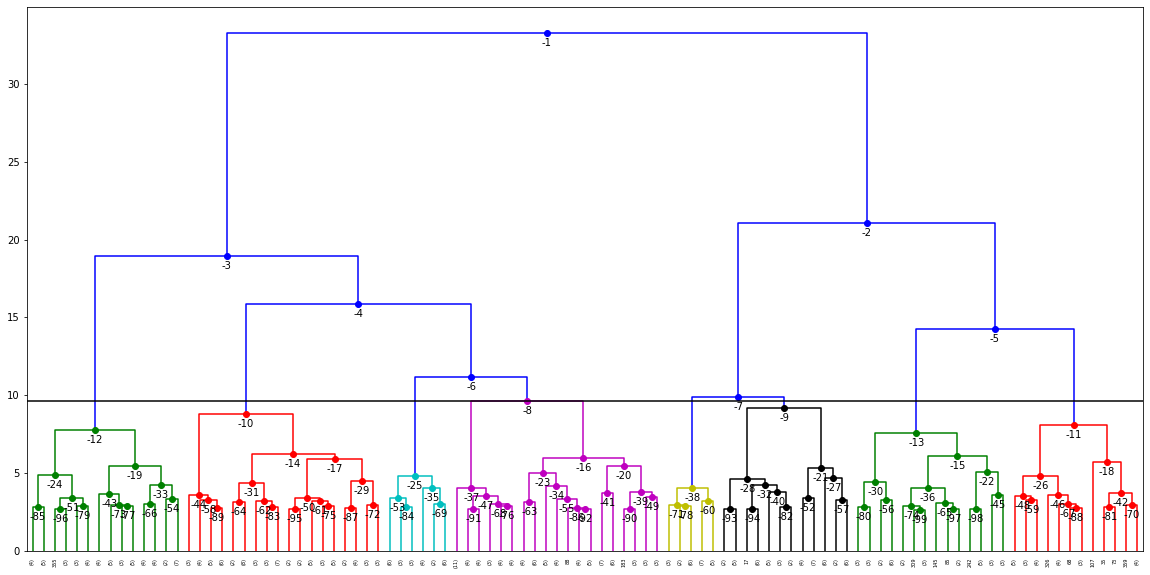

In [19]:
plot_dendrogram(model=model, X=X_train_pd,
                truncate_mode='lastp', 
                p=100, n_clusters=8)

The sorted **similarity matrix** will allow us to compare inter-cluster similarity (which should be low) and intra-cluster similarity (which should be high), by identifying blocks of high similarity along the diagonal corresponding to the clusters. We are able to identify eight blocks, however we have a lot of noise.

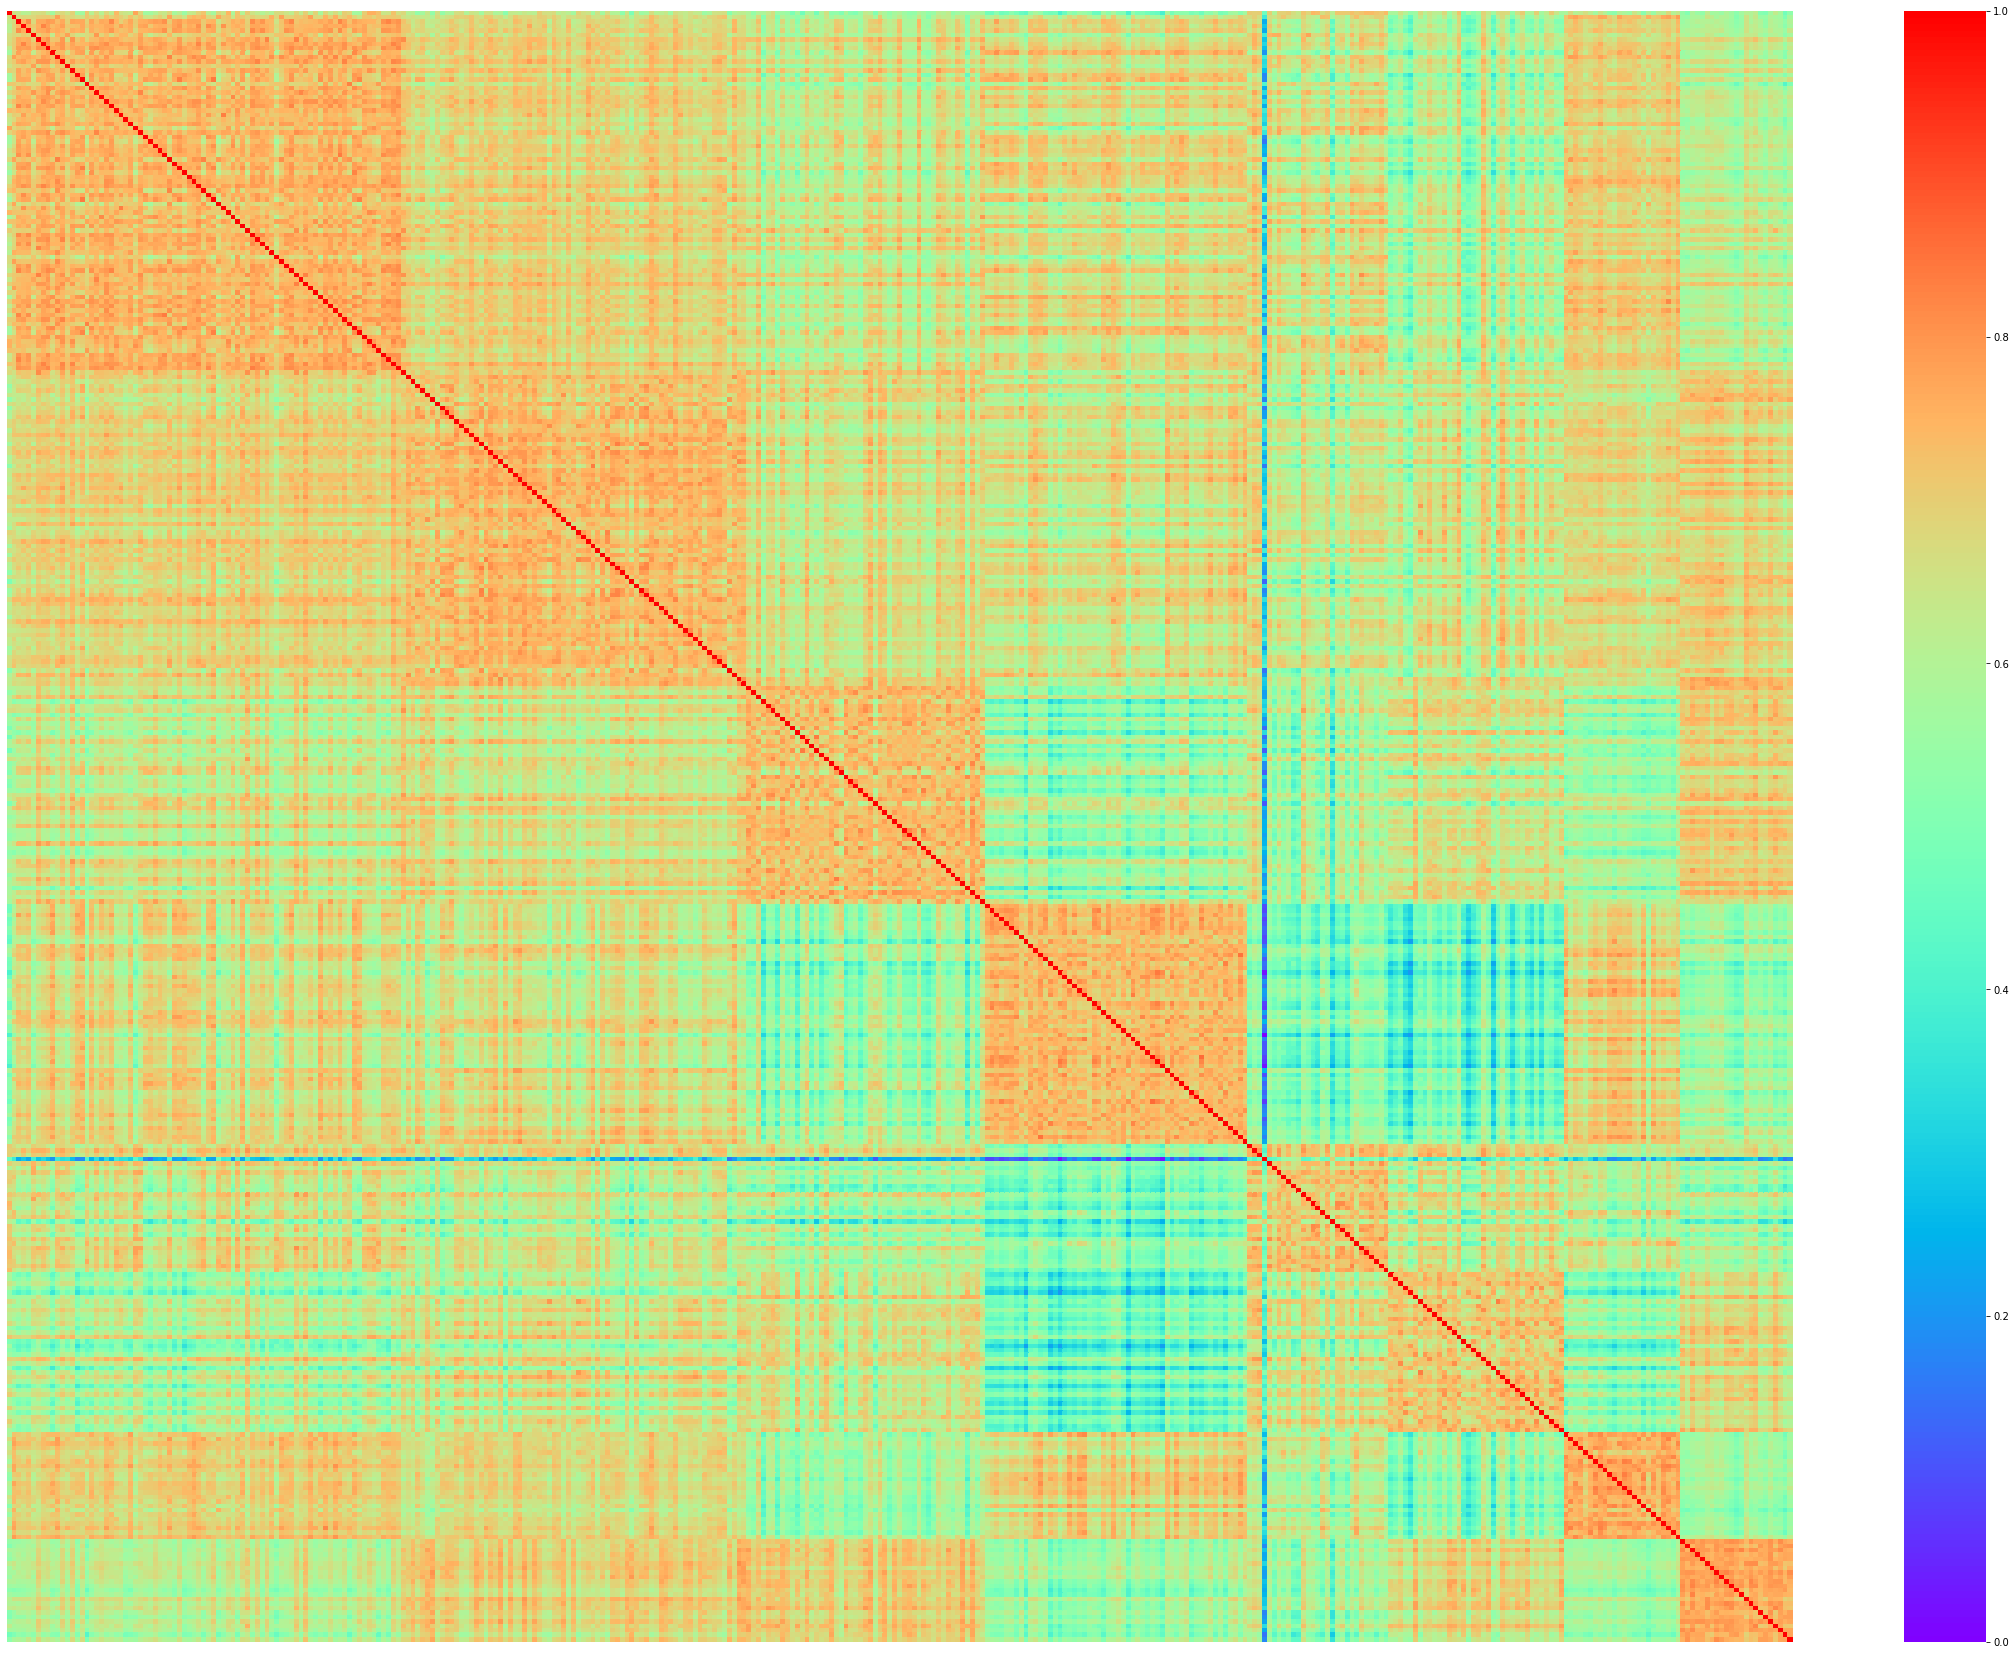

In [20]:
sim = similarity_mat(X_train_pd, metr)
plot_sorted_sim(sim, y_predict)

We can compute two GOF metrics:
- **correlation** between incidence matrix and similarity matrix: this will tell us if samples that belong to the same cluster are similar;
- **purity**: this will tell us if samples from the same class are in the same cluster. 

Both these measures range from 0 to 1.

In [21]:
print("Hierarchical clustering correlation: ",correlation(X_train_pd,y_predict,metr))
print("Hierarchical clustering purity:", tot_purity(y_predict,y_train))

Hierarchical clustering correlation:  0.44054777117990795
Hierarchical clustering purity: 0.3787465939188854


The purity for hierarchical clustering is not very high.

Next we try some other clustering methods.

### 1.3.2 K-means

In k-means points are grouped together based on their neighbors, or better, on the closest centroid. Centroids are iteratively computed for each cluster. In the first step of the algorithm, centroids are initialized randomly or with other methods. Initialization can affect strongly the result of clustering.  
As before, we fit a model and predict the class labels, then compute GOF metrics.

In [22]:
model = KMeans(n_clusters=8, init='random', random_state=6,n_init=50)             
y_predict_k = model.fit_predict(X_train_pd)
print("Kmeans correlation: ",correlation(X_train_pd,y_predict_k,metr))
print("Kmeans purity", tot_purity(y_predict_k, y_train))

#plot3d(X, labels=y_predict)

Kmeans correlation:  0.413438162736398
Kmeans purity 0.42234332415788545


K-means++ assigns centroids in a non-random way.

In [23]:
model = KMeans(n_clusters=8, init='k-means++', random_state=6,n_init=50)             
y_predict_kplus = model.fit_predict(X_train_pd)
print("Kmeans++ correlation: ",correlation(X_train_pd,y_predict_kplus,metr))
print("Kmeans++ purity", tot_purity(y_predict_kplus, y_train))

Kmeans++ correlation:  0.4139223564396417
Kmeans++ purity 0.41144414159792964


We plot the similarity matrices for these two methods.

K-means


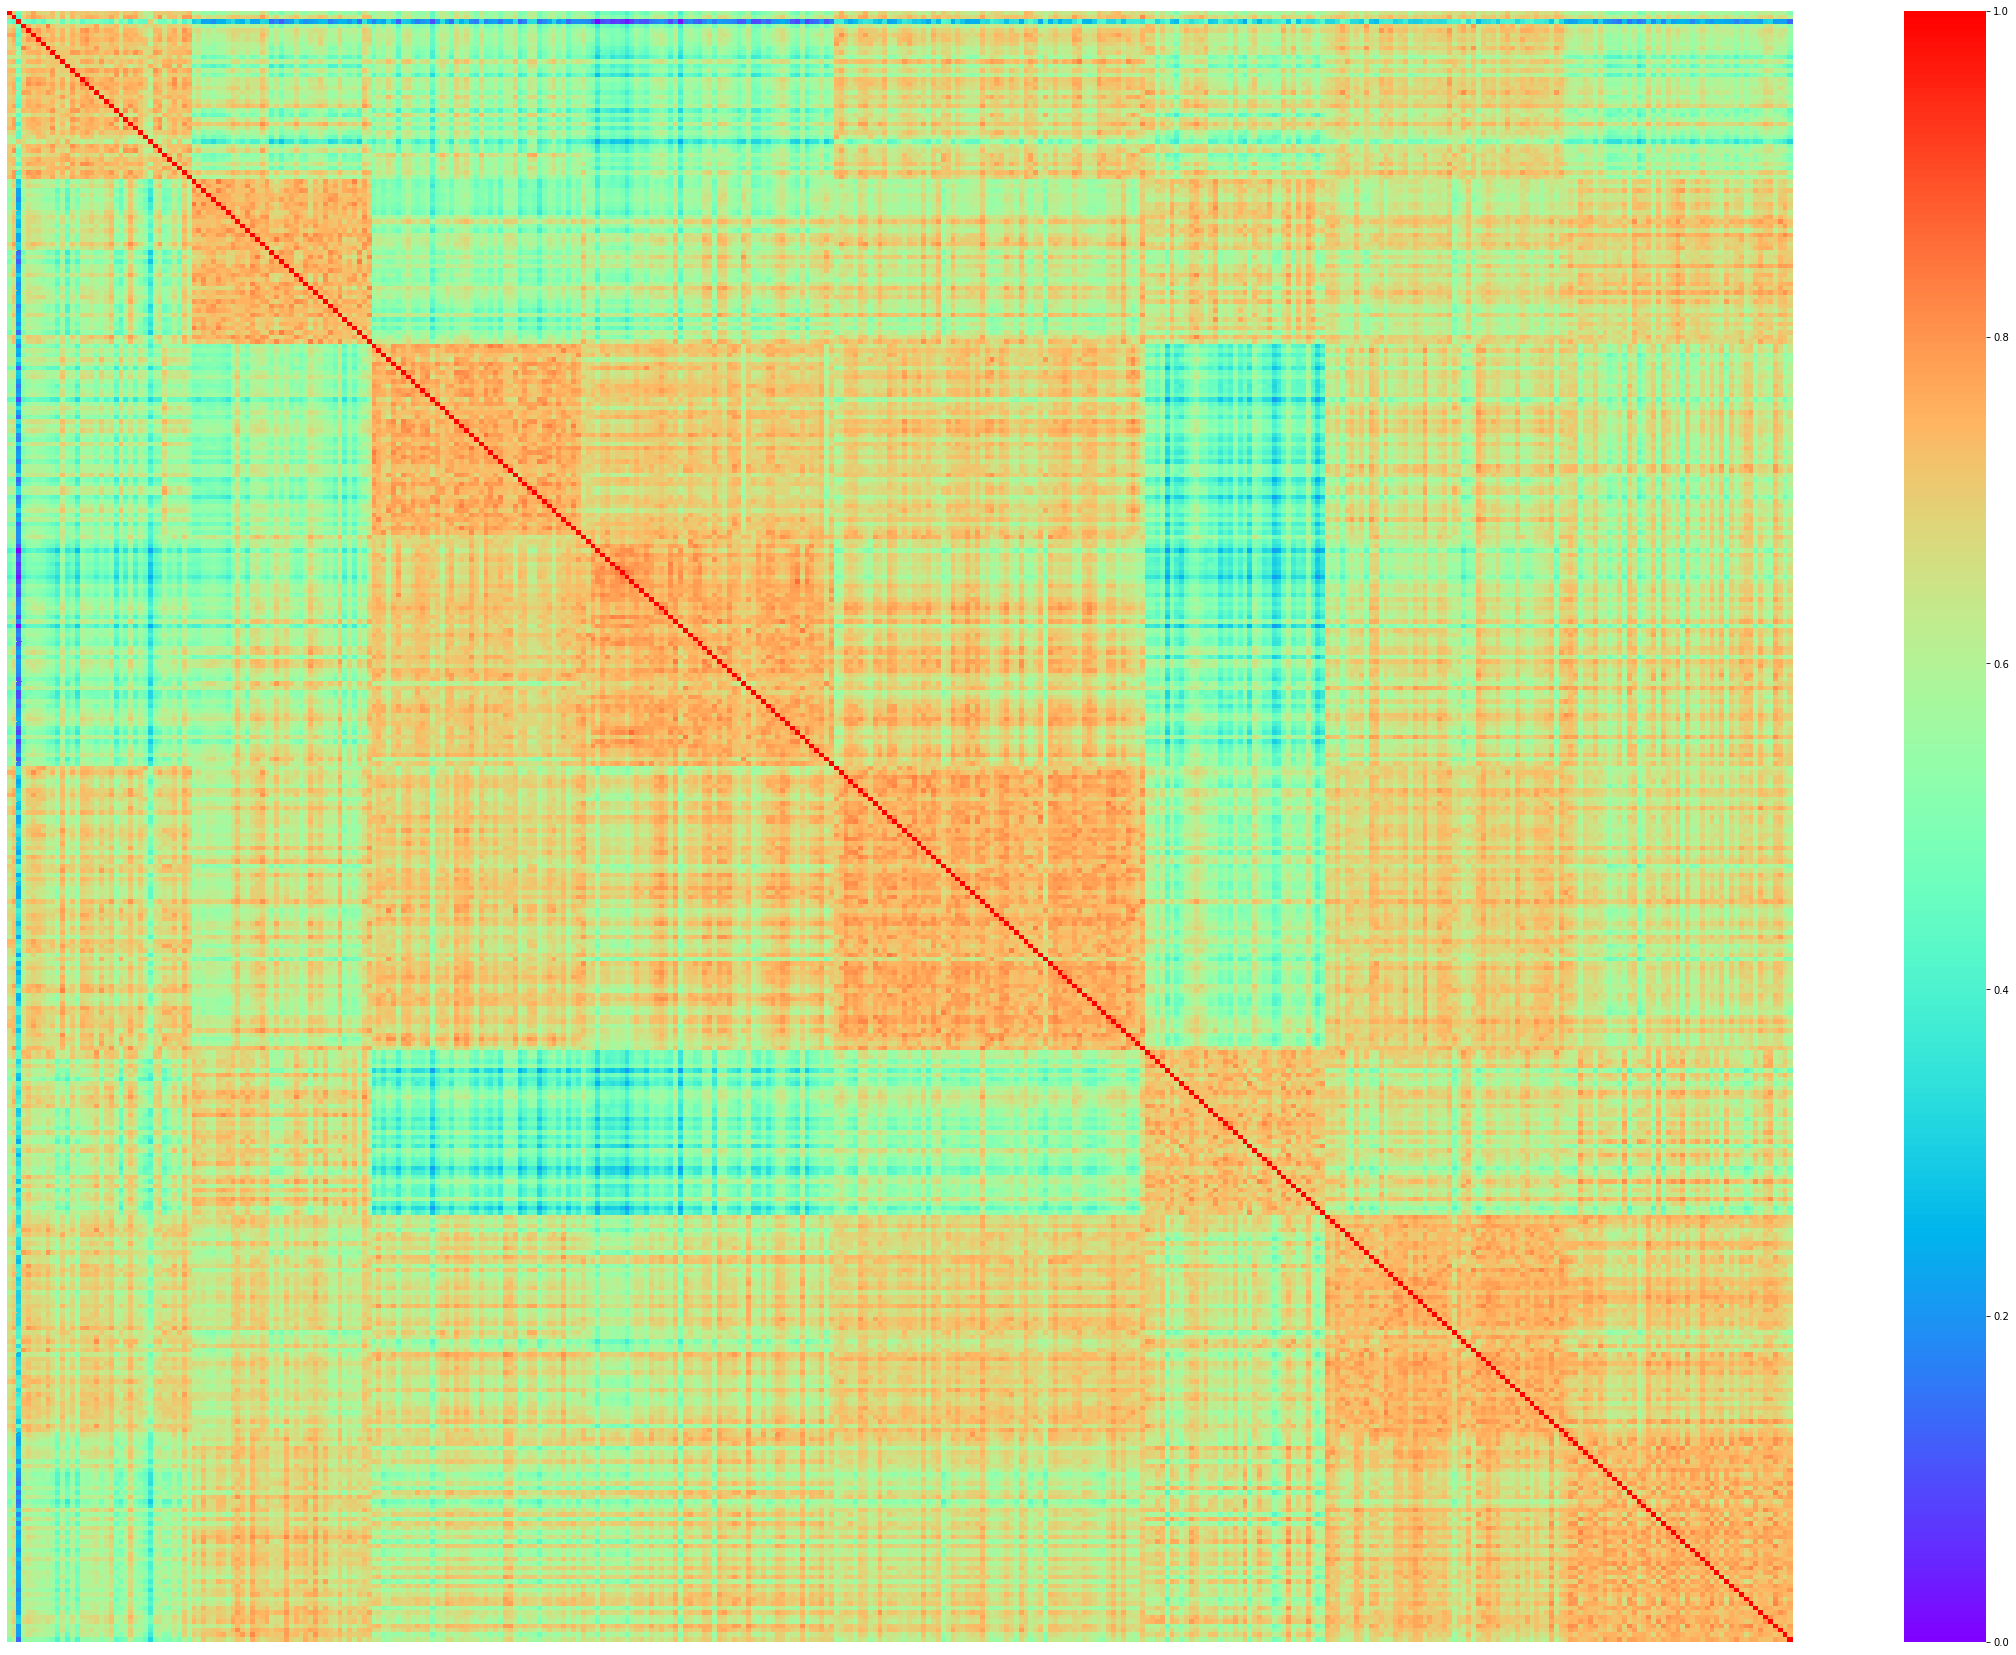

In [24]:
print("K-means")
plot_sorted_sim(sim,y_predict_k)

K-means++


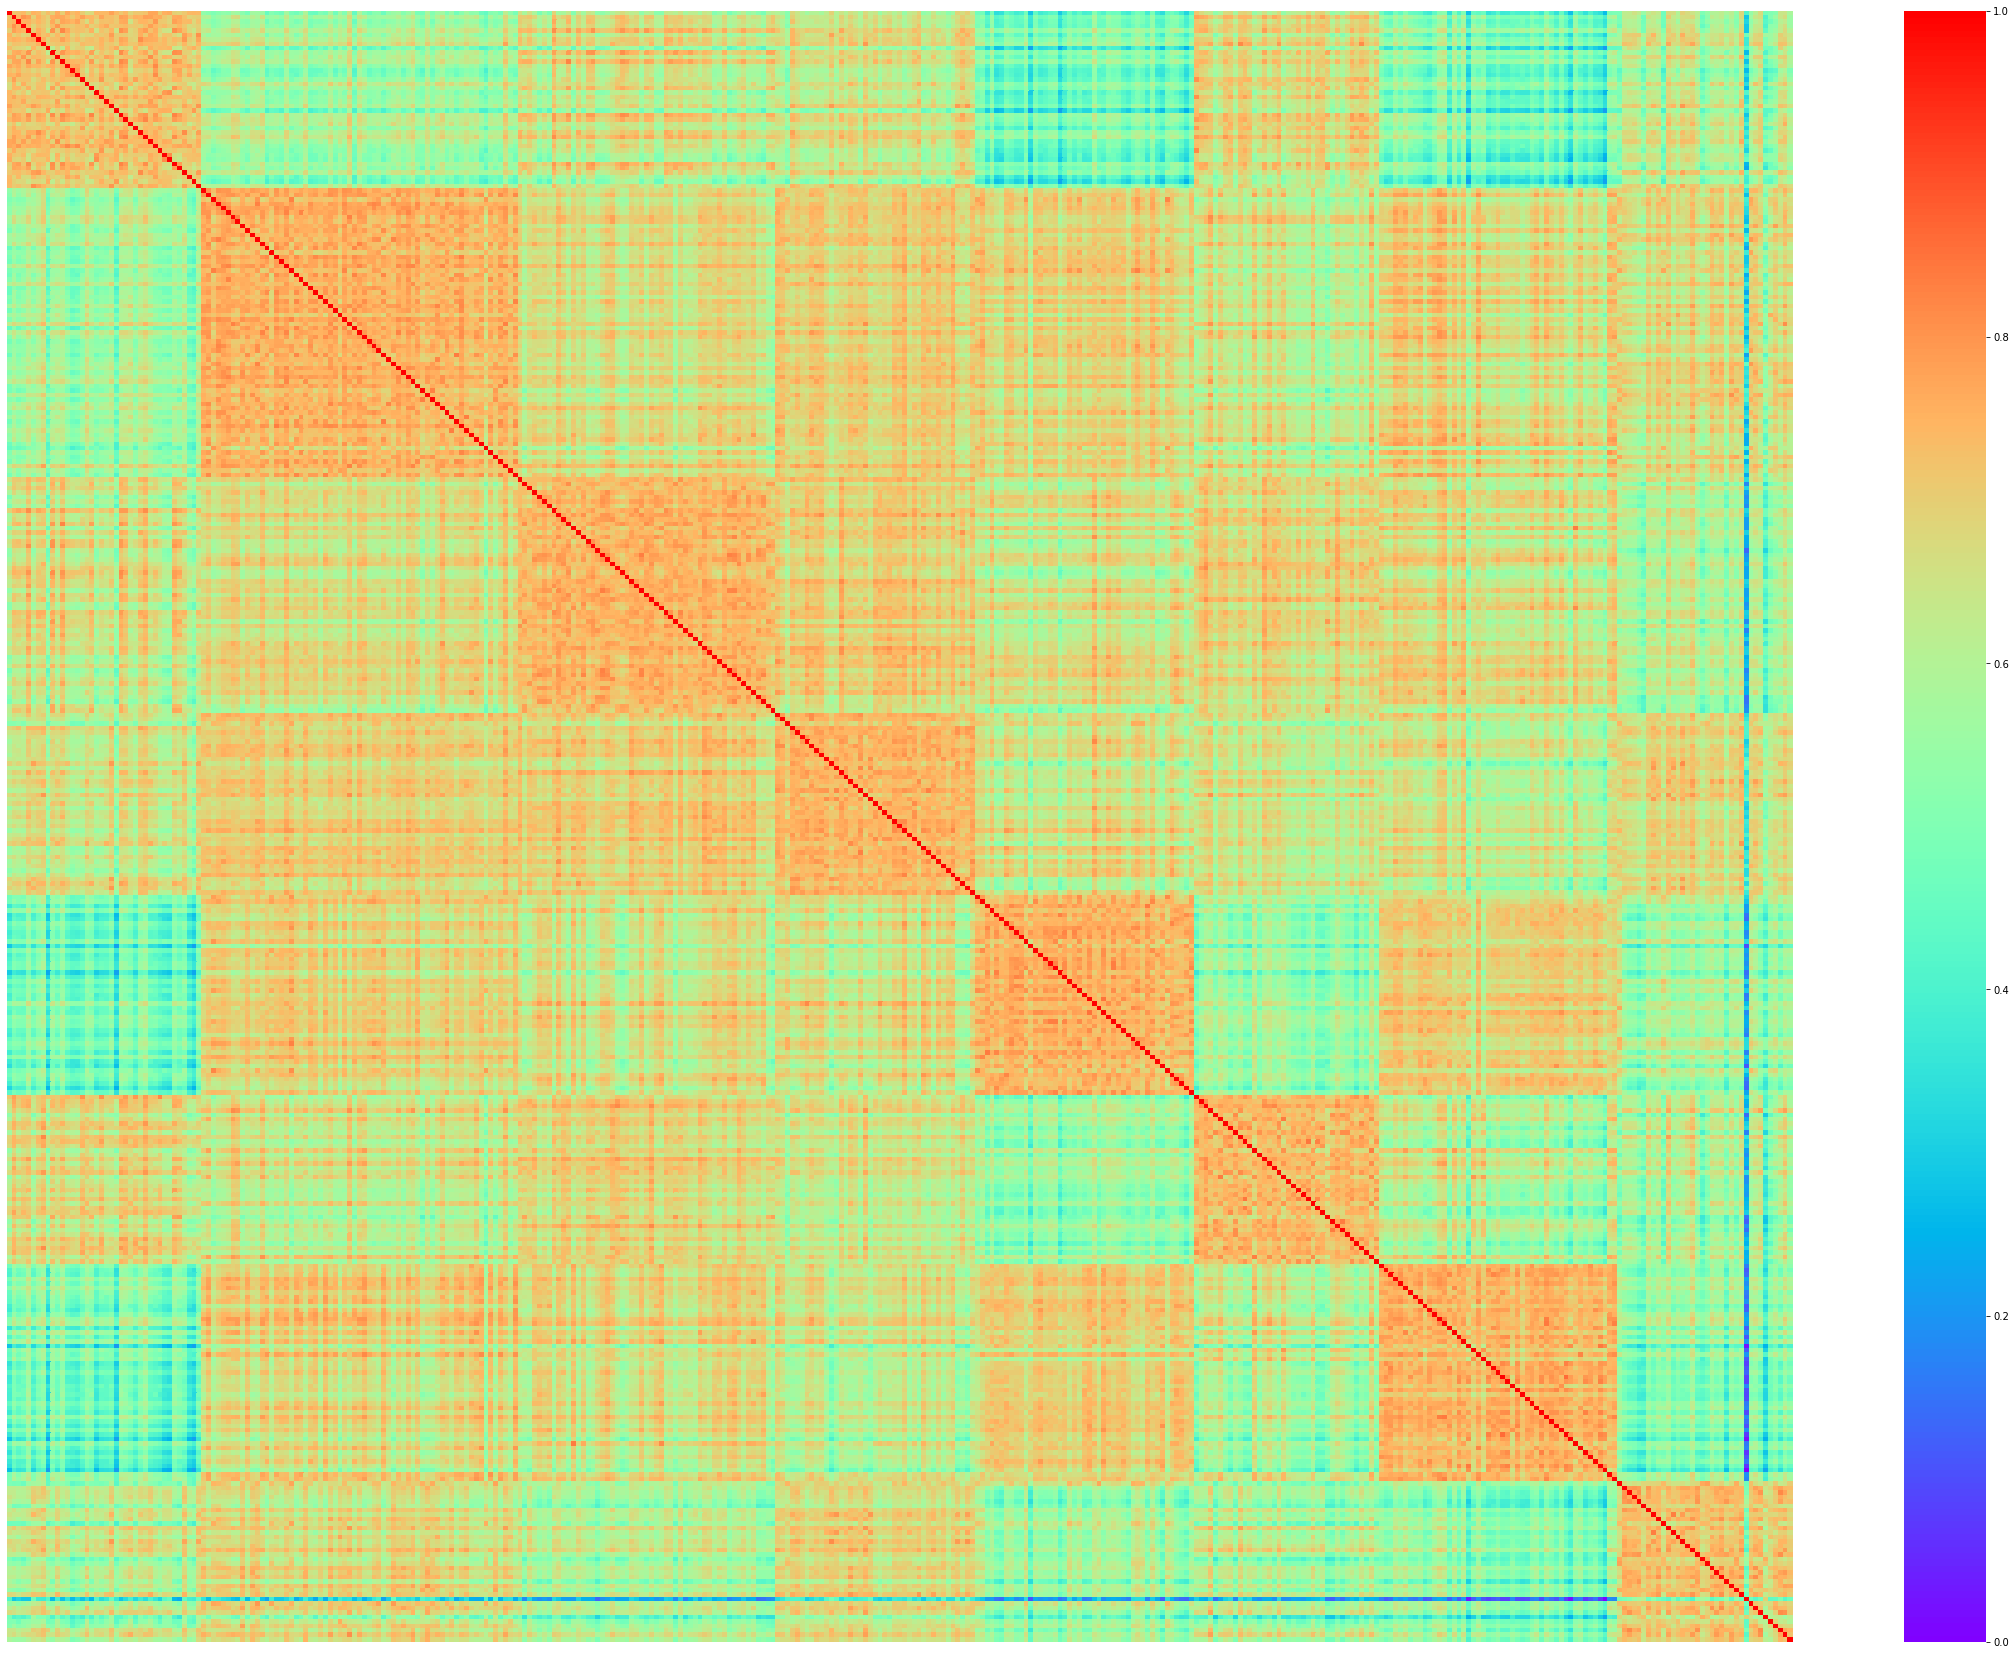

In [25]:
print("K-means++")
plot_sorted_sim(sim,y_predict_kplus)

In this case too, we see block on the diagonal and quite a bit of noise. The purity is higher than hierarchical clustering.  
Let's compare cluster sizes to see if they are balanced and similar to the class sizes. Keep in mind that the order in which we plot clustering labels is not meaningful and does not correspond to a class: we just want to compare the sizes of the various clusters.

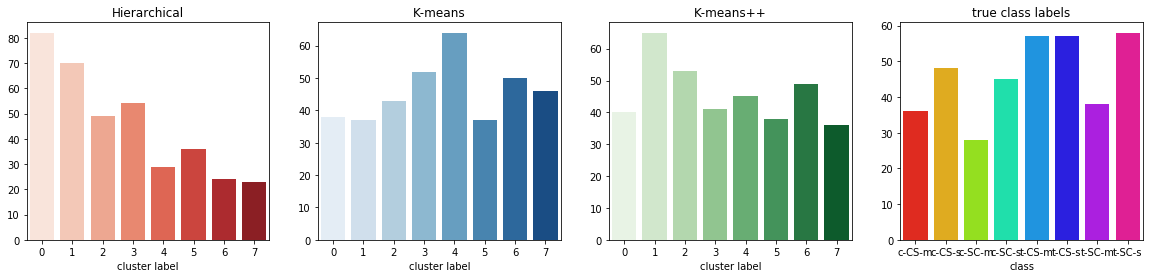

In [26]:
methods = ["Hierarchical", "K-means", "K-means++"]
palettes = ["Reds", "Blues", "Greens"]
predictions = [y_predict, y_predict_k, y_predict_kplus]
fig=plt.figure(figsize=(20,4))
for i in range(3):
    plt.subplot(1,4,i+1)
    f = sns.countplot(x=predictions[i],palette=palettes[i])
    plt.title(methods[i])
    f.yaxis.label.set_visible(False)
    f.set(xlabel="cluster label")
plt.subplot(1,4,4)    
f=sns.countplot(x="class",data=sorttrain,palette=colors)
f.yaxis.label.set_visible(False)
plt.title("true class labels")
plt.show()

Other measures that we can compute are the **within sum of squares**, which quantifies intra-cluster similarity, the **between sum of squares**, for the inter-cluster similarity, and the **silhouette coefficient**, which summarizes both. As the number of clusters increase, WSS will decrease while BSS will decrease, so it would look like the "perfect" clustering is reached when each point is its own cluster. The silhouette coefficient however will reach a maximum which corresponds to the "best" number of clusters.  
We will compute and plot these measures for all three methods.

In [27]:
def wss(X, y_pred, metric):
    ncluster = np.unique(y_pred).shape[0]
    err = 0
    for k in range(ncluster):
        # All the points of this cluster
        X_k = X[y_pred == k]
        # Distances of all points within the cluster
        dist_mat = pairwise_distances(X_k, metric=metric)
        # Select the lower triangular part of the matrix
        triu_idx = np.tril_indices(dist_mat.shape[0], k=1)
        err += (dist_mat[triu_idx] ** 2).sum()
    
    return err

def bss(X, y_pred, metric):
    ncluster = np.unique(y_pred).shape[0]
    # Sort the distance matrix (as we did for the simiarity)
    dist_mat = pairwise_distances(X, metric=metric) ** 2
    dist_mat = sorted_sim(dist_mat, y_predict)
    y_sort = np.sort(y_pred)
    
    err = 0
    for k in range(ncluster):
        kidx = np.where(y_sort == k)[0]
        start, end = kidx[0], kidx[-1]
        err += dist_mat[start:end, end+1:].sum()
    
    return err

In [28]:
def get_silhouette(model, X, y, metric,clus_list,**kwargs):
    
    wss_list, bss_list, sil_list = [], [], []
    for nc in clus_list:
        mod = model(n_clusters=nc, **kwargs)
        y_predict = mod.fit_predict(X)
    
        wss_list.append(wss(X, y_predict, metric))
        bss_list.append(bss(X, y_predict, metric))
        if nc > 1:
            sil_list.append(silhouette_score(X, y_predict, metric=metric))
    return wss_list,bss_list,sil_list

clus_list = list(range(1, 15))
metr_km=get_silhouette(KMeans, X_train_pd, y_train, metr,clus_list, init='random', random_state=6)
metr_kp=get_silhouette(KMeans, X_train_pd, y_train, metr,clus_list, init='k-means++', random_state=6)
metr_hie=get_silhouette(AgglomerativeClustering, X_train_pd, y_train, metr,clus_list, affinity=metr, linkage=link)

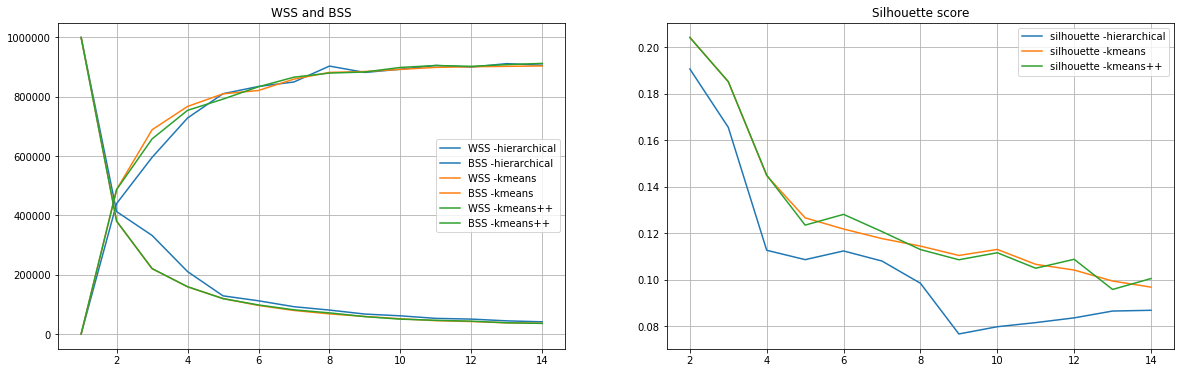

In [29]:
fig,axs=plt.subplots(1,2,figsize=(20,6))
gmetr=list([metr_hie,metr_km,metr_kp])
tabs=["tab:blue","tab:orange","tab:green"]
labels=["hierarchical","kmeans","kmeans++"]
for i in range(3):
    axs[0].plot(clus_list,gmetr[i][0],label="WSS -"+labels[i],color=tabs[i])
    axs[0].plot(clus_list,gmetr[i][1],label="BSS -"+labels[i],color=tabs[i])
    axs[1].plot(clus_list[1:],gmetr[i][2],label="silhouette -"+labels[i])

axs[0].legend()
axs[0].grid()
axs[1].legend()
axs[1].grid()
axs[0].set_title("WSS and BSS")
axs[1].set_title("Silhouette score")
plt.show()

We plotted them in the same graph for simplicity, however these indexes should **not** be used to compare the different algorithms, but rather to compare performance of the same algorithm with a different number of clusters!  
According to the silhouette score, the optimal number of clusters would be 2. In fact, the samples group together the most according to the **type of stimulus**. However, it is still a low value.

### 1.3.3 Dimensionality reduction

#### SelectKBest
Let's check if reducing the features the results improve. We will fit all three models by selecting the k most relevant features with **mutual information** for each value of k from 1 to 76 and visualize the purity score. We implement this with a simple for loop, but the concept is the same as the `scikit-learn` function `SelectKBest` (which we will use later).

In [30]:
purhi=[]
purkm=[]
purkp=[]
for f in range(1,77):
    hi=AgglomerativeClustering(n_clusters=n_clusters, 
                                distance_threshold=distance_threshold, 
                                affinity=metr, linkage=link)
    y_predict = hi.fit_predict(X_train_pd[impoprot[0:f]])
    purhi.append(tot_purity(y_predict, y_train))
    km = KMeans(n_clusters=8, init='random', random_state=6)             
    y_predict_k = km.fit_predict(X_train_pd[impoprot[0:f]])
    purkm.append(tot_purity(y_predict_k, y_train))
    kp = KMeans(n_clusters=8, init='k-means++', random_state=6)             
    y_predict_kplus = kp.fit_predict(X_train_pd[impoprot[0:f]])
    purkp.append(tot_purity(y_predict_kplus, y_train))

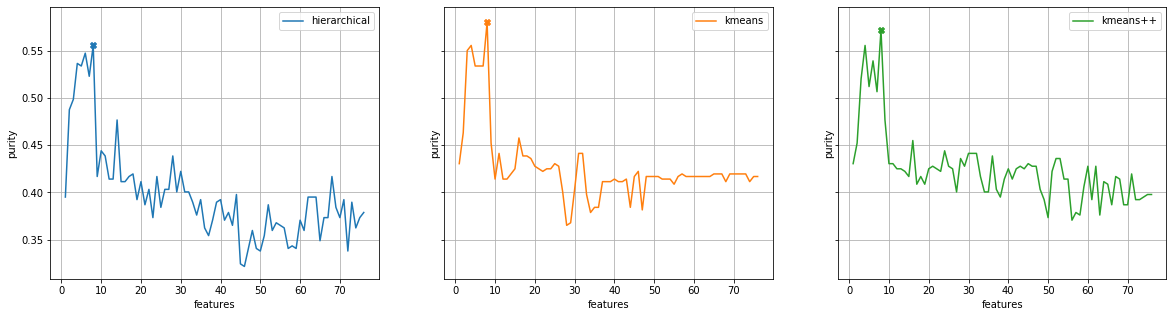

In [31]:
fig,axs=plt.subplots(1,3,figsize=(20,5),sharey=True)
pur=list([purhi,purkm,purkp])
tabs=["tab:blue","tab:orange","tab:green"]
labels=["hierarchical","kmeans","kmeans++"]
for i in range(3):
    axs[i].plot(range(1,77),pur[i],label=labels[i],color=tabs[i])
    plt.xlabel("features")
    axs[i].scatter(np.argmax(pur[i])+1,max(pur[i]),marker="X",color=tabs[i])
    axs[i].legend()
    axs[i].grid()
    axs[i].set_xlabel("features")
    axs[i].set_ylabel("purity")

In [32]:
print("hierarchical best score",max(purhi),"with",np.argmax(purhi)+1,"features")
print("Kmeans best score",max(purkm),"with",np.argmax(purkm)+1,"features")
print("Kmeans++ best score",max(purkp),"with",np.argmax(purkp)+1,"features")

hierarchical best score 0.5558583105010146 with 8 features
Kmeans best score 0.5803814712526553 with 8 features
Kmeans++ best score 0.572207084336269 with 8 features


We can see that Kmeans with 8 features gave the best results.

In [33]:
print(impoprot[0:np.argmax(purkm)+1])

['pPKCG_N', 'SOD1_N', 'pERK_N', 'BRAF_N', 'DYRK1A_N', 'Tau_N', 'DSCR1_N', 'CaNA_N']


#### Principal Component Analysis
Another method for dimensionality reduction is **PCA** which transforms the features into a new set of features orthogonal to each other, so that the first features capture the most variability of the data. To check how much variability is explained by the principal components we can plot the explained variance ratio. To actually perform a dimensionality reduction, we keep only the first K principal components.

Text(0, 0.5, 'explained variance ratio')

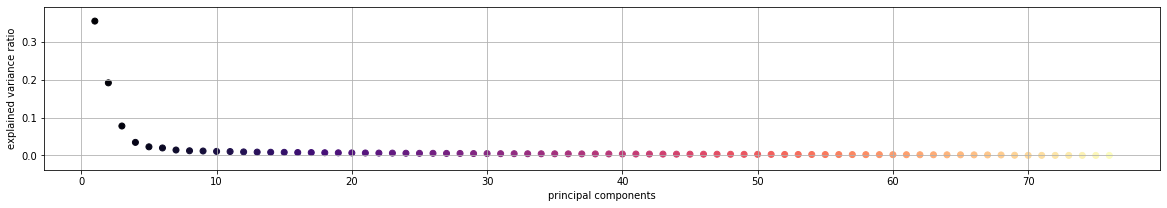

In [34]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit(X_train_pd)
X_prj = pca.fit_transform(X_train_pd)
fig=plt.figure(figsize=(20,3))
plt.scatter(x=np.arange(1,77),y=X_pca.explained_variance_ratio_,cmap="magma",c=np.arange(1,77))
plt.grid()
plt.xlabel("principal components")
plt.ylabel("explained variance ratio")

We can see that most of the variance is explained by the first 10 PCs, so we'll keep the first 15 just to be sure we don't lose too much information and fit all three models.

In [35]:
model = KMeans(n_clusters=8, init='random', random_state=6,n_init=50) 
keep=15
y_predict_kpca = model.fit_predict(X_prj[:,0:keep])
print("Kmeans purity on 15 PCs:", tot_purity(y_predict_kpca, y_train))
print("Kmeans correlation on 15 PCs: ",correlation(X_prj[:,0:keep],y_predict_kpca,metr))

Kmeans purity on 15 PCs: 0.40599455031947485
Kmeans correlation on 15 PCs:  0.41873896675448746


In [36]:
model = KMeans(n_clusters=8, init='k-means++', random_state=6,n_init=50) 
keep=15
y_predict_ppca = model.fit_predict(X_prj[:,0:keep])
print("Kmeans++ purity on 15 PCs:", tot_purity(y_predict_ppca, y_train))
print("Kmeans++ correlation on 15 PCs: ",correlation(X_prj[:,0:keep],y_predict_ppca,metr))

Kmeans++ purity on 15 PCs: 0.41416893723748927
Kmeans++ correlation on 15 PCs:  0.4201048726412264


In [37]:
model = AgglomerativeClustering(n_clusters=n_clusters, 
                                distance_threshold=distance_threshold, 
                                affinity=metr, linkage=link)
#cluster labels
y_predict_hpca = model.fit_predict(X_prj[:,0:keep])

print("Hierarchical purity on 15 PCs:", tot_purity(y_predict_hpca, y_train))
print("Hierarchical correlation on 15 PCs: ",correlation(X_prj[:,0:keep],y_predict_hpca,metr))

Hierarchical purity on 15 PCs: 0.3760217982830687
Hierarchical correlation on 15 PCs:  0.4242387686225779


Using PCA did not improve the performances.

### 1.3.4 DBSCAN

DBSCAN identifies clusters based on groups with similar density. Its parameters are eps (radius) and min_samples (the number of neighbors). To fine tune them we plot an elbow plot to inspect the distance between each point and its closest neighbors, so we can select a coherent value for eps.

Text(0, 0.5, 'distance')

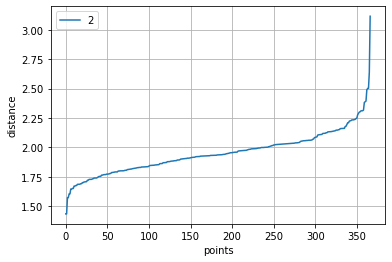

In [38]:
n=2
neigh = NearestNeighbors(n_neighbors=n)
nbrs = neigh.fit(X_train_pd)
distances, indices = nbrs.kneighbors(X_train_pd)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances,label= n)
plt.legend()
plt.grid()
plt.xlabel("points")
plt.ylabel("distance")

We perform a **grid search** to find the best eps and min_samples parameters. Simply put, we fit a model for each pair of parameters from a set and choose the ones that gave the best result in terms of clustering purity.

In [39]:
def make_scorer(metric):
    def scorer(estimator, X, y):
        y_pred = estimator.fit_predict(X)
        return metric(y_pred, y)
    return scorer

In [40]:
eps=np.arange(2,2.6,0.1)
s=np.arange(1,6,1)
params = {'eps': eps, 'min_samples': s}
cv = GridSearchCV(DBSCAN(), params, scoring=make_scorer(tot_purity), cv=2,
                 verbose=False, n_jobs=-1)
cv = cv.fit(X_train_pd, y_train)
print("Done!")

Done!


In [41]:
print("The best parameters are:",cv.best_params_)
print("The score of this model is:",cv.best_score_)
pd.DataFrame(cv.cv_results_).sort_values(by="rank_test_score")

The best parameters are: {'eps': 2.1, 'min_samples': 3}
The score of this model is: 0.28341054850851927


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_eps  \
7        0.023999  0.000000e+00         0.085008    1.001239e-03       2.1   
6        0.026000  2.004147e-03         0.151013    6.000280e-02       2.1   
14       0.020499  5.005598e-04         0.079452    1.093388e-03       2.2   
8        0.019499  5.013943e-04         0.100010    4.001260e-03       2.1   
9        0.021002  1.001120e-03         0.103008    2.900267e-02       2.1   
11       0.020000  9.987354e-04         0.108649    1.164174e-02       2.2   
2        0.020502  1.502037e-03         0.115010    1.900029e-02         2   
20       0.023448  7.814646e-03         0.101589    7.814646e-03       2.4   
1        0.022002  2.000332e-03         0.122010    3.300047e-02         2   
15       0.024283  4.999995e-03         0.082335    0.000000e+00       2.3   
5        0.024499  4.499316e-03         0.097508    7.501602e-03       2.1   
25       0.021286  2.876520e-04         0.161197    4.218495e-02       2.5   
16       0.023444  7.816076e-03         0.082333    1.668930e-06       2.3   
10       0.020002  2.026558e-06         0.090507    2.501369e-03       2.2   
3        0.020503  4.993677e-04         0.169511    3.950059e-02         2   
26       0.023500  1.499534e-03         0.092507    4.996061e-04       2.5   
21       0.015629  4.768372e-07         0.143194    4.941809e-02       2.4   
27       0.027502  4.998446e-04         0.123842    2.983427e-02       2.5   
12       0.019999  1.311302e-06         0.083149    6.140947e-03       2.2   
30       0.021333  1.331568e-03         0.109839    1.517129e-02       2.6   
22       0.023443  7.816315e-03         0.085619    7.474184e-03       2.4   
31       0.022002  4.768372e-07         0.089005    1.000106e-02       2.6   
32       0.020997  1.788139e-06         0.085508    3.499627e-03       2.6   
33       0.019004  3.576279e-07         0.098009    7.997036e-03       2.6   
34       0.020999  2.145767e-06         0.067003    5.998850e-03       2.6   
28       0.022499  5.003214e-04         0.084673    2.000928e-03       2.5   
17       0.017724  2.091646e-03         0.088057    9.907722e-03       2.3   
29       0.022503  1.499414e-03         0.080168    1.502156e-03       2.5   
18       0.031258  1.788139e-06         0.078150    1.563108e-02       2.3   
23       0.023445  7.813454e-03         0.166656    6.881821e-02       2.4   
24       0.015631  7.152557e-07         0.114394    1.318645e-02       2.4   
19       0.023443  7.813692e-03         0.078152    0.000000e+00       2.3   
13       0.028002  1.000047e-02         0.095138    1.685250e-02       2.2   
4        0.027000  9.989738e-04         0.096510    5.005598e-04         2   
0        0.023503  4.990101e-04         0.107007    7.152557e-07         2   

   param_min_samples                                         params  \
7                  3                 {'eps': 2.1, 'min_samples': 3}   
6                  2                 {'eps': 2.1, 'min_samples': 2}   
14                 5                 {'eps': 2.2, 'min_samples': 5}   
8                  4                 {'eps': 2.1, 'min_samples': 4}   
9                  5                 {'eps': 2.1, 'min_samples': 5}   
11                 2                 {'eps': 2.2, 'min_samples': 2}   
2                  3                 {'eps': 2.0, 'min_samples': 3}   
20                 1  {'eps': 2.4000000000000004, 'min_samples': 1}   
1                  2                 {'eps': 2.0, 'min_samples': 2}   
15                 1  {'eps': 2.3000000000000003, 'min_samples': 1}   
5                  1                 {'eps': 2.1, 'min_samples': 1}   
25                 1  {'eps': 2.5000000000000004, 'min_samples': 1}   
16                 2  {'eps': 2.3000000000000003, 'min_samples': 2}   
10                 1                 {'eps': 2.2, 'min_samples': 1}   
3                  4                 {'eps': 2.0, 'min_samples': 4}   
26                 2  {'eps': 2.5000000000000004, 'min_samp

Now we fit the best model on all data. In DBSCAN points can either belong to a cluster or be classified as outliers, so we check the purity, the correlation and the number of points in each cluster.

DBSCAN purity 0.2915531333341845
DBSCAN correlation:  0.5655988741360386
Number of outliers 72
Points in each cluster:
  -1   0    1   2   3   4   5   6   7   8   9
  72   6  177  85   6   3   6   3   3   3   3


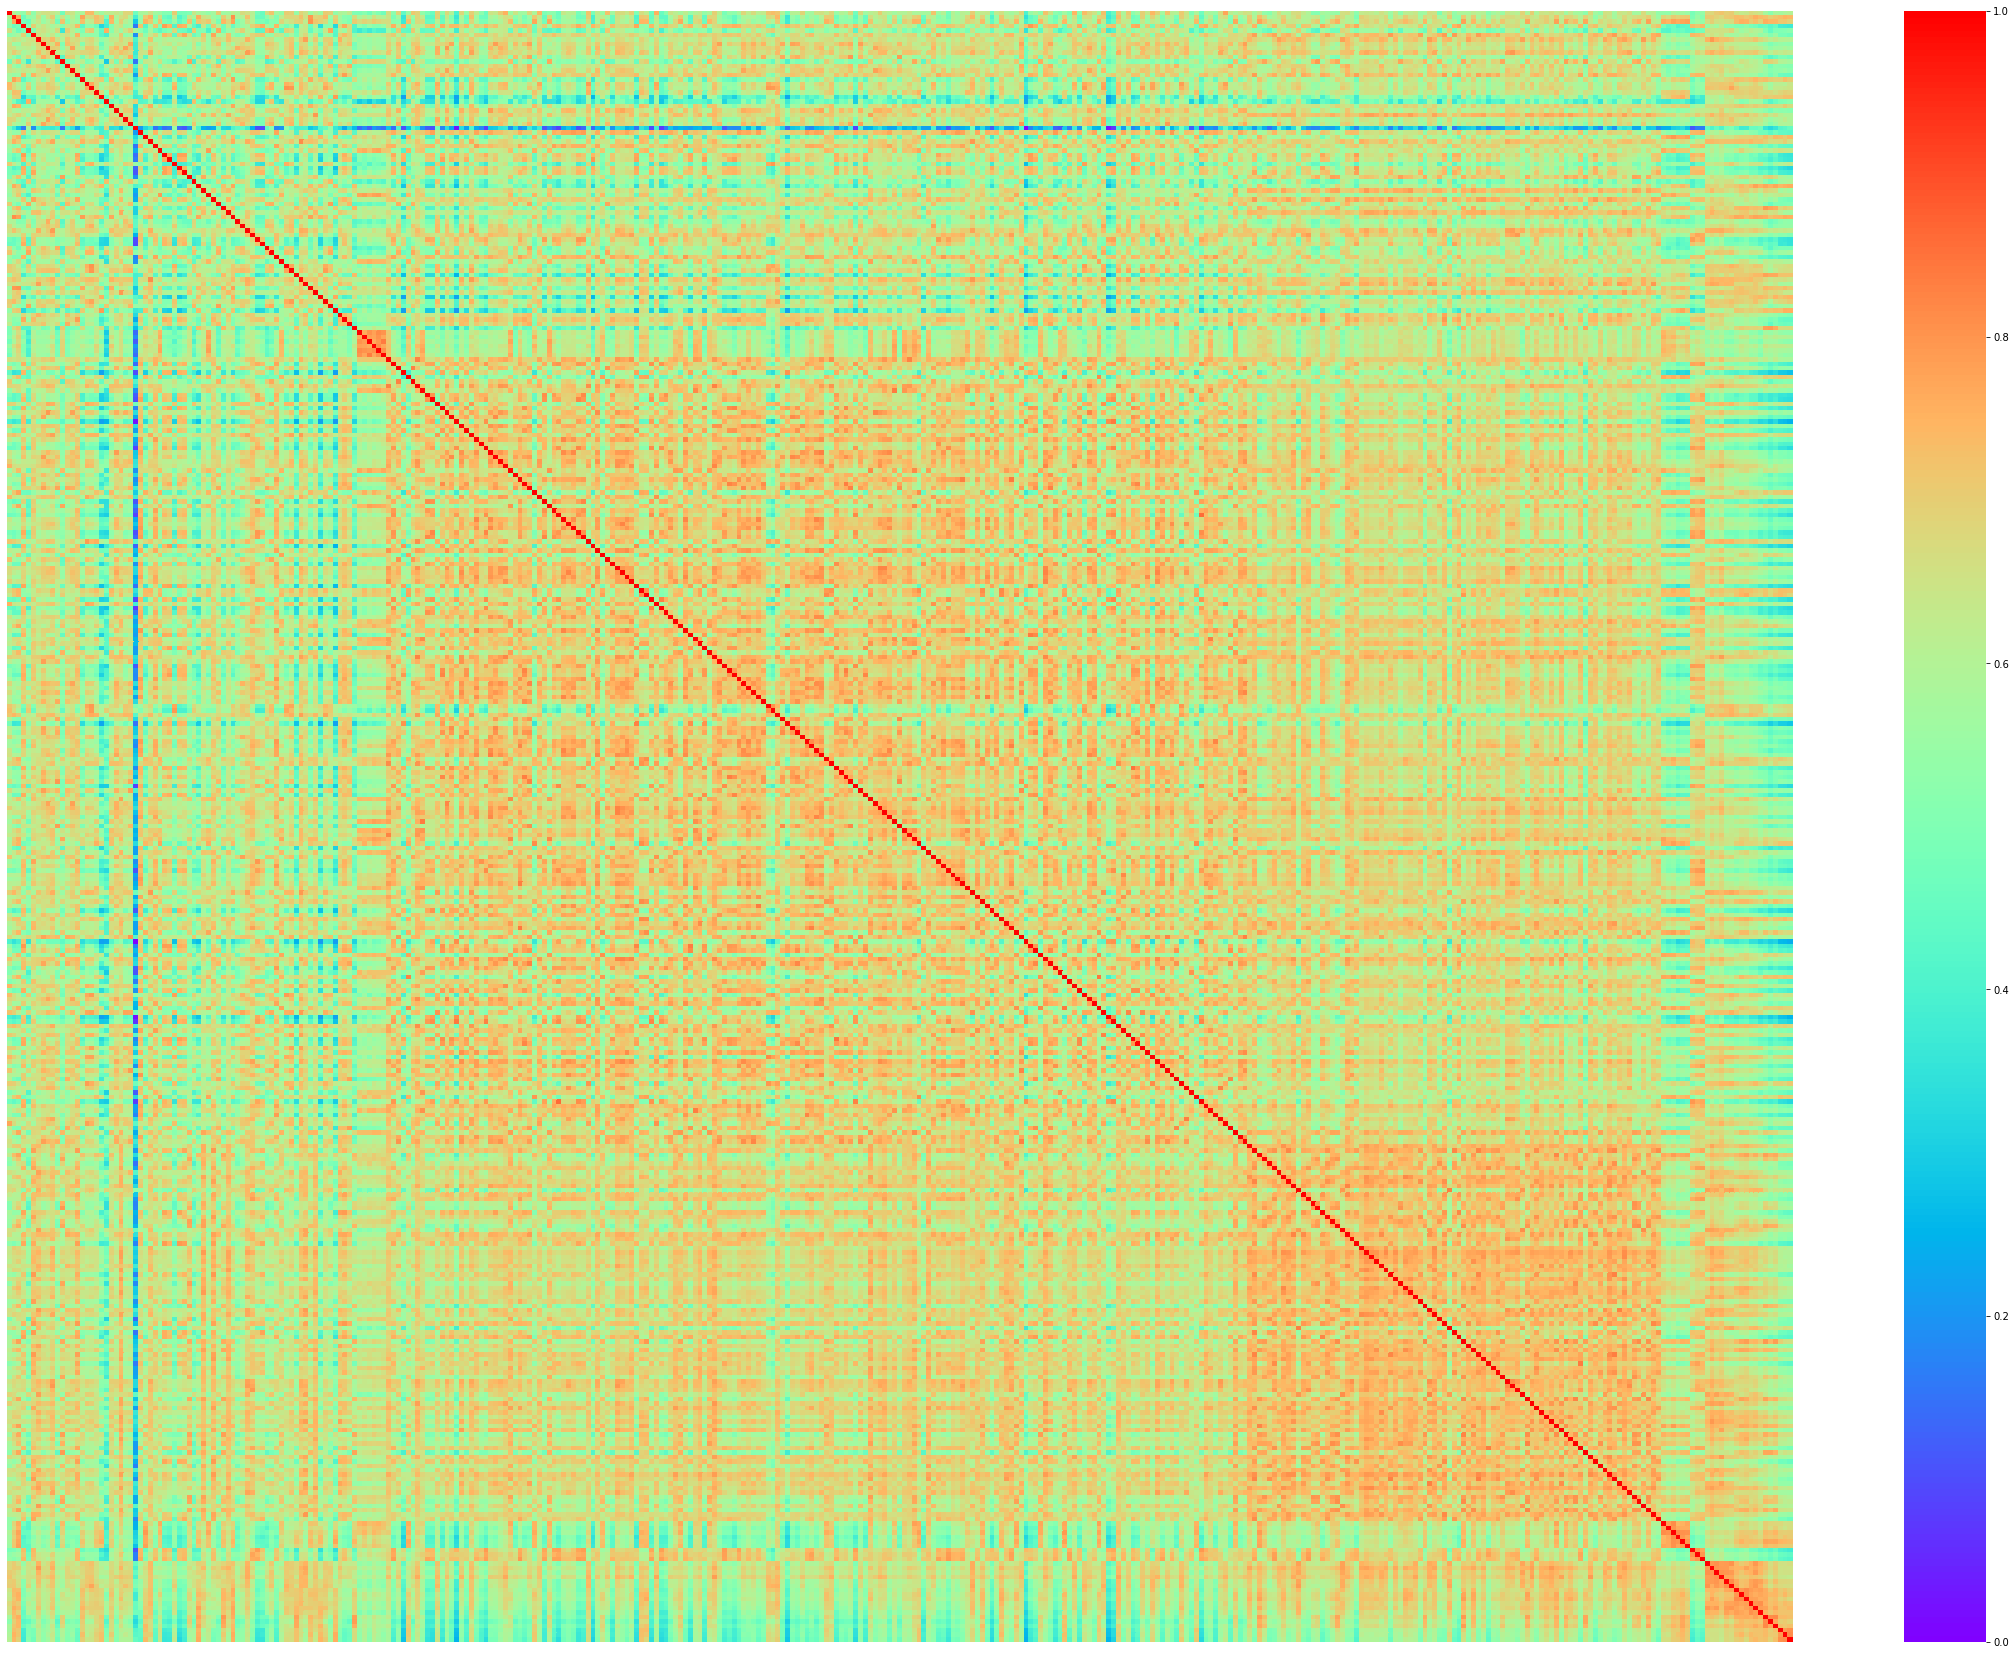

In [42]:
model = DBSCAN(eps=cv.best_params_['eps'], min_samples=cv.best_params_['min_samples'])
y_predict = model.fit_predict(X_train_pd)
print("DBSCAN purity", tot_purity(y_predict, y_train))
print("DBSCAN correlation: ",correlation(X_train_pd,y_predict,metr))
print("Number of outliers", (y_predict == -1).sum())
ids, counts = np.unique(y_predict, return_counts=True)
print("Points in each cluster:")
print(pd.DataFrame(counts.reshape(1,-1), columns=ids, index=['']))
plot_sorted_sim(sim,y_predict)

DBSCAN does not perform well on this dataset. 

<div id="1.4"></div>

### 1.4 Conclusions
Overall the best clustering performances were obtained with KMeans performed on eight features selected according to their mutual information score:

In [43]:
print(impoprot[0:8])

['pPKCG_N', 'SOD1_N', 'pERK_N', 'BRAF_N', 'DYRK1A_N', 'Tau_N', 'DSCR1_N', 'CaNA_N']


We visualize metrics related to this model.

In [44]:
kmeans_final = KMeans(n_clusters=8, init='random', random_state=6)             
y_predict_final = kmeans_final.fit_predict(X_train_pd[impoprot[0:np.argmax(purkm)+1]])
print("Correlation: ",correlation(X_train_pd[impoprot[0:np.argmax(purkm)+1]],y_predict_final,metr))
print("Purity", tot_purity(y_predict_final, y_train))

Correlation:  0.49365749128962283
Purity 0.5803814712526553


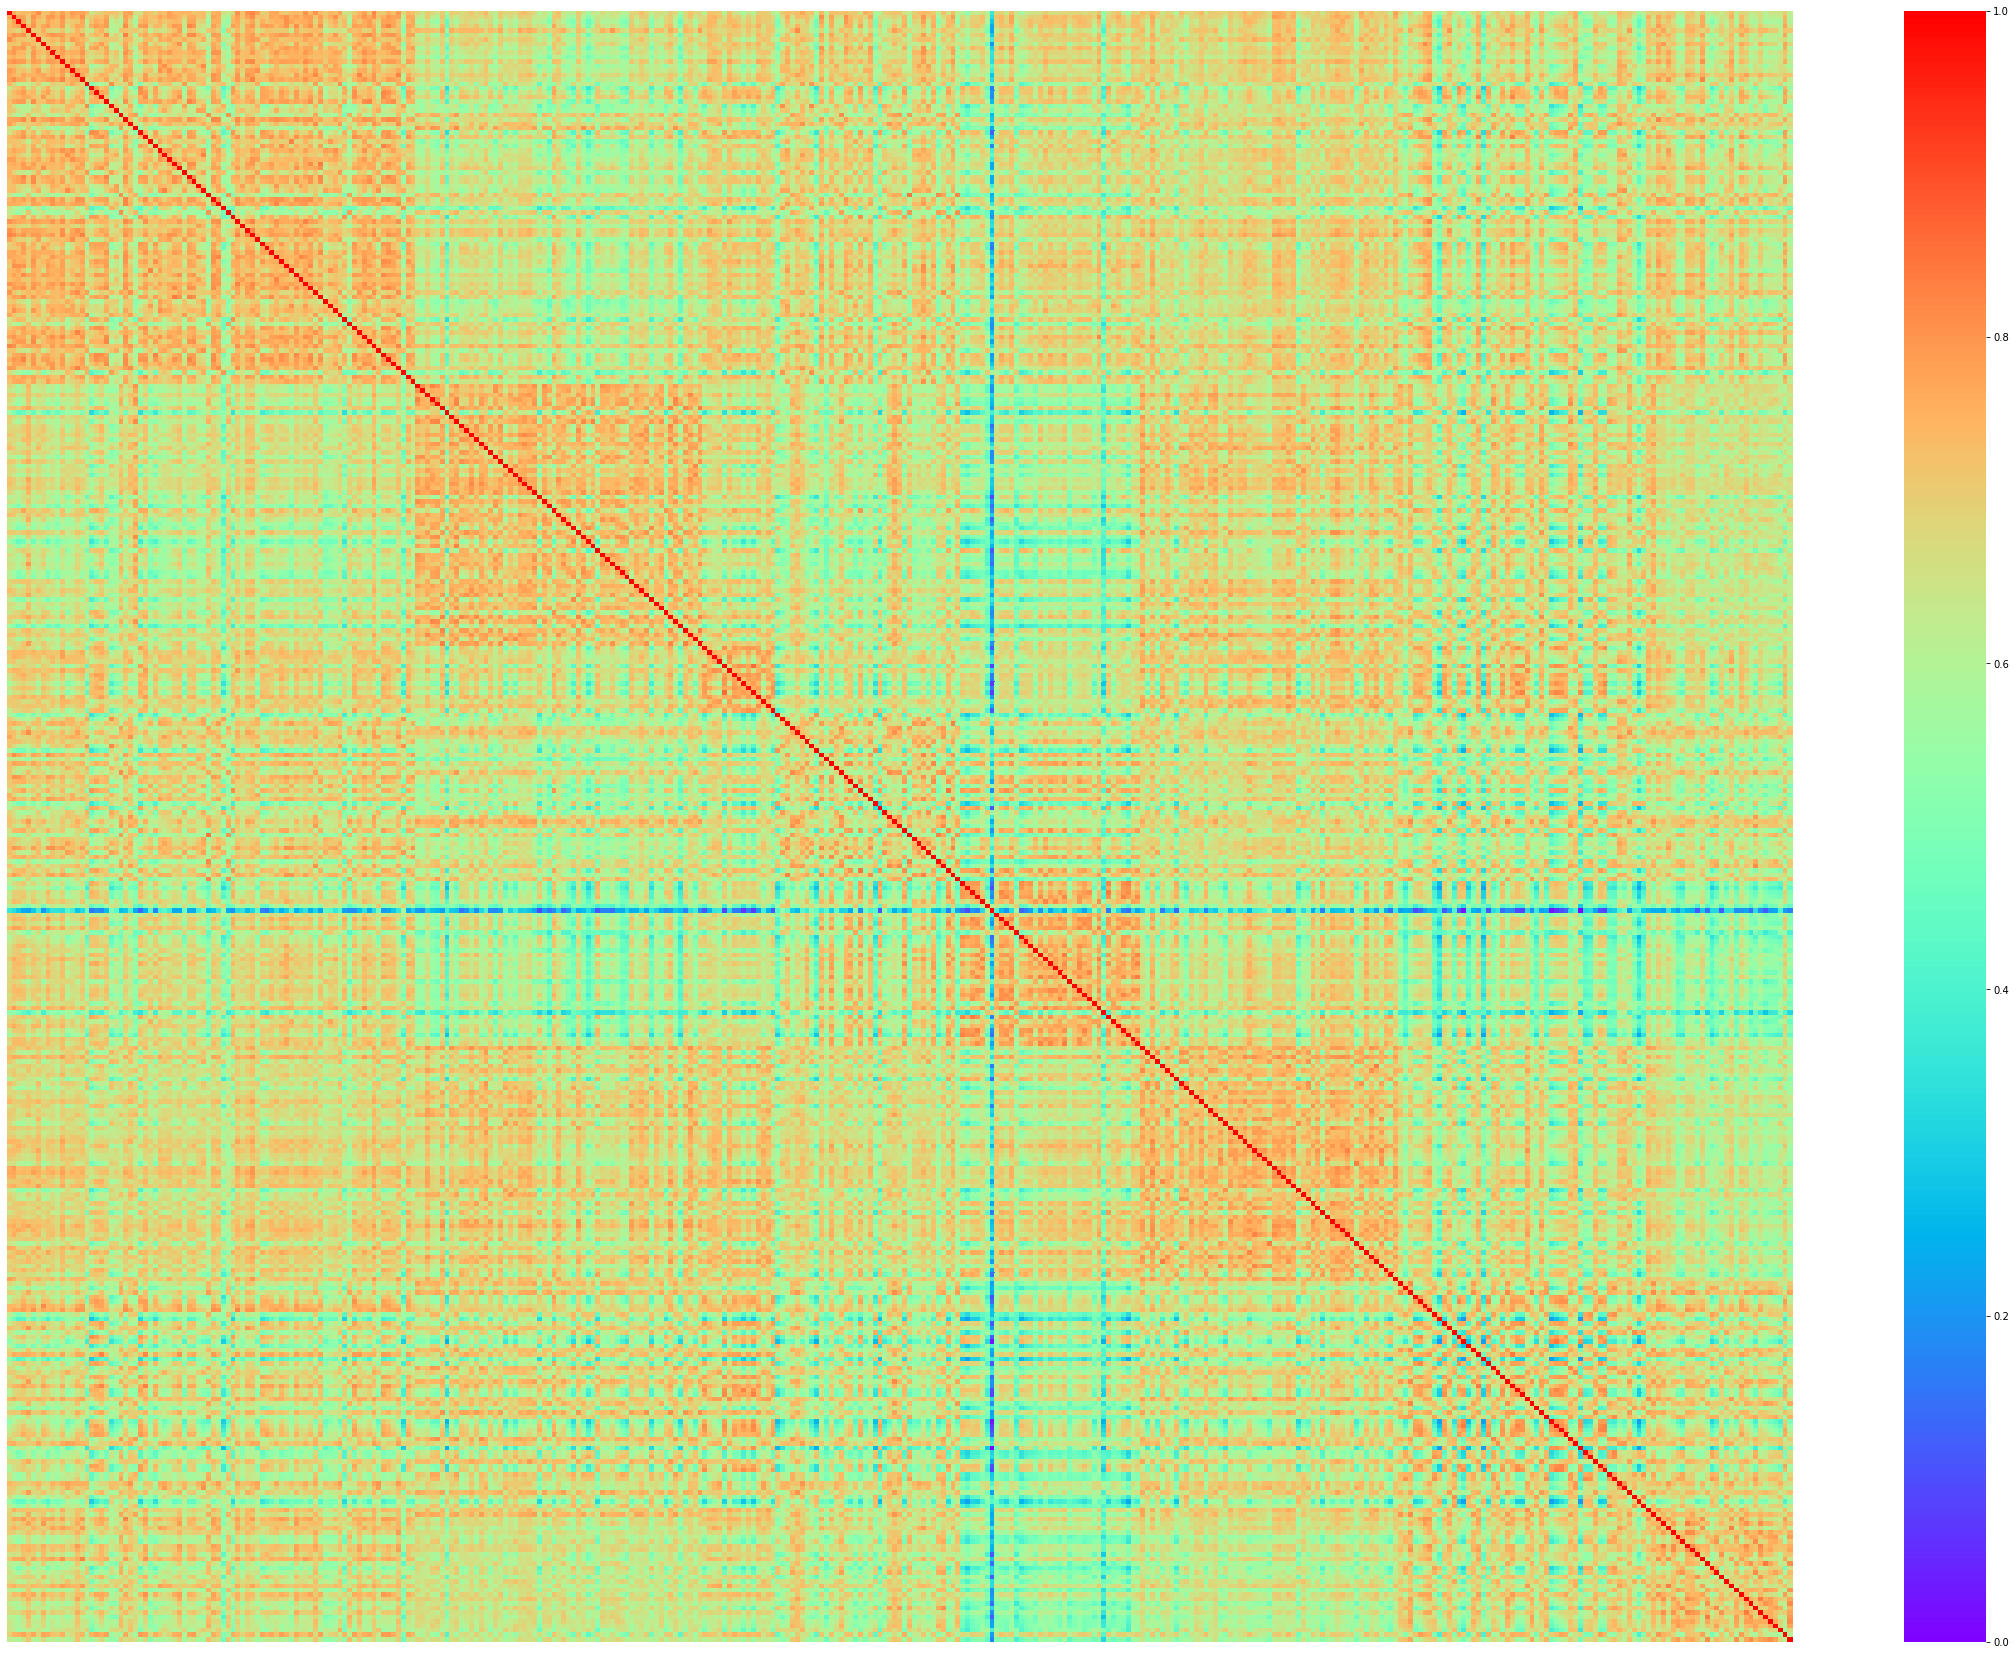

In [45]:
plot_sorted_sim(sim,y_predict_final)

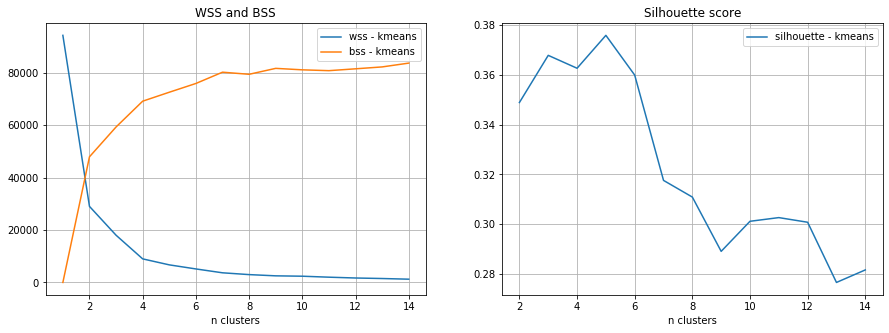

In [46]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
clus_list = list(range(1, 15))
metr_kfinal=get_silhouette(KMeans, X_train_pd[impoprot[0:np.argmax(purkm)+1]], y_train, metr,clus_list, init='random', random_state=6)
axs[0].plot(clus_list,metr_kfinal[0],label="wss - kmeans")
axs[0].plot(clus_list,metr_kfinal[1],label="bss - kmeans")
axs[0].set(xlabel="n clusters",title="WSS and BSS")
axs[0].legend()
axs[0].grid()
axs[1].plot(clus_list[1:],metr_kfinal[2],label="silhouette - kmeans")
axs[1].set(xlabel="n clusters",title="Silhouette score")
axs[1].legend()
axs[1].grid()
plt.show()

By selecting features we were able to increase the purity, however the similarity matrix is less defined. Overall, the samples do have some structure, but it is not trivial to identify the different classes. In particular it seems that samples from mice that received the same stimulus tend to group together.

<div id="class"></div>

# 2. Classification
2.1 <a href="#2.1">Importing modules and data</a>  
2.2 <a href="#2.2">Logistic regression</a>  
&nbsp;&nbsp;&nbsp;&nbsp;2.2.1 Lasso  
&nbsp;&nbsp;&nbsp;&nbsp;2.2.2 Ridge  
&nbsp;&nbsp;&nbsp;&nbsp;2.2.3 Model comparison  
2.3 <a href="#2.3">Linear discriminant analysis</a>  
&nbsp;&nbsp;&nbsp;&nbsp;2.3.1 Forward feature selection  
&nbsp;&nbsp;&nbsp;&nbsp;2.3.2 Select k best  
2.4 <a href="#2.4">Quadratic discriminant analysis</a>   
&nbsp;&nbsp;&nbsp;&nbsp;2.4.1 Forward feature selection  
&nbsp;&nbsp;&nbsp;&nbsp;2.4.2 Select k best  
2.5 <a href="#2.5">Support Vector Machines</a>   
&nbsp;&nbsp;&nbsp;&nbsp;2.5.1 Linear kernel  
&nbsp;&nbsp;&nbsp;&nbsp;2.5.2 Polynomial kernel  
&nbsp;&nbsp;&nbsp;&nbsp;2.5.3 RBF kernel  
2.6 <a href="#2.6">K-neighbors classifier</a>   
&nbsp;&nbsp;&nbsp;&nbsp;2.6.1 Select k best  
2.7 <a href="#2.7">Conclusions</a>

We want to **classify** mice in the different classes based on protein expression. Several algorithms are available for this task; we will also perform **feature selection** to see if decreasing the number of features increases accuracy.  Since the **SOD1_N** feature is missing in test samples, we will remove it from training samples before training.

<div id="2.1"></div>

## 2.1 Importing modules and data

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, plot_confusion_matrix, accuracy_score
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [48]:
X_train_pd = X_train_pd.drop("SOD1_N",axis=1)

In [49]:
proteins = X_train_pd.columns

We define a `Pandas` dataframe to save the results of different algorithms.

In [50]:
results_classifier=pd.DataFrame(columns=["model","description","train score","cv score"])

<div id="2.2"></div>

## 2.2 Logistic regression

First, we fit a logistic regression model. The `scikit-learn` `LogisticRegression` method will fit a model for each class in a **one-versus-all** fashion. Thus, we will get 8 models with the form  

$p(Y=k|X)=\frac{e^{\beta_{0}+\beta_{k}^T X}}{1+e^{\beta_{0}+\beta_{k}^T X}}$ 
  
comparing class *k* to all other classes. 

In [51]:
model = LogisticRegression(solver="newton-cg", penalty='none')
model.fit(X_train_pd, y_train)  

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

To compare the performances of different algorithms we will consider the **accuracy**, which is the fraction of correctly classified samples. There are other metrics, but we will only consider them after we have selected a model for simplicity. 

In [52]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum() / y_pred.shape[0]

To have an estimate of the accuracy on the test set we will perform 5-fold **cross validation** and compute the accuracy as the average of the accuracy on all folds. We will use this metric to choose the best classifier.

In [53]:
print("Train accuracy:", accuracy(y_train, model.predict(X_train_pd)))
#print("Test accuracy:", accuracy(y_test, model.predict(X_test)))
cv_newton = cross_val_score(model, X_train_pd, y_train, scoring=make_scorer(accuracy), cv=5, n_jobs=-1)
print("CV accuracy: ",np.mean(cv_newton))

Train accuracy: 1.0
CV accuracy:  0.637652721214365


In [54]:
#add the results to the dataframe
results_classifier=results_classifier.append({"model":model,
                           "description":"logistic regression",
                           "train score":accuracy(y_train, model.predict(X_train_pd)), 
                           "cv score":np.mean(cv_newton)},ignore_index=True)

While performances are perfect on the training set, the CV score is low, this means we are overfitting our test data.

###  Feature selection
There are several ways to perform **feature selection** in logistic regression.
- subset selection: in which we choose which features to include in the model and which to exclude 
- regularization: in which a penalization term is added to the error function such that the coefficients tend to shrink towards 0. 

For logistic regression we will apply **lasso** (L1) and **ridge** (L2) regularization. In both cases, the penalization depends on the hyperparameter **C** which we have to optimize: the smaller it is, the higher is the regularization. We also need to scale the features, so that they are on the same scale and the shrinking of coefficients is meaningful. However, the scaling needs to be applied separately for each fold of the cross validation so we don't use our validation data to scale before training. For this we will use the `Pipeline` object. 

### 2.2.1 Lasso
To optimize the C parameter we do a grid search with cross validation.  

In [55]:
#running the next three cells is not necessary to train the best model because i already extract the best parameters
#to save time

C2=np.arange(0.1, 1.55, 0.1)
model=Pipeline([('scaler',preprocessing.StandardScaler()), 
               ('classifier',LogisticRegression(solver='saga', penalty='l1',max_iter=4000))])

params = {'classifier__C': C2}
cv = GridSearchCV(model, params, refit=True, cv=5, n_jobs=-1,
                  verbose=False,
                  scoring=make_scorer(accuracy))
cv.fit(X_train_pd, y_train)
print("Done!")

Done!


In [56]:
pd.DataFrame(cv.cv_results_).sort_values(by="rank_test_score").head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4        4.142045      0.947367         0.005127        0.005271   
12       6.796795      1.277341         0.001400        0.001200   
13       7.091606      0.941805         0.002200        0.000749   
14       5.951137      0.985151         0.000600        0.000800   
6        4.990532      1.130485         0.000000        0.000000   

   param_classifier__C                                 params  \
4                  0.5                 {'classifier__C': 0.5}   
12                 1.3  {'classifier__C': 1.3000000000000003}   
13                 1.4  {'classifier__C': 1.4000000000000001}   
14                 1.5  {'classifier__C': 1.5000000000000002}   
6                  0.7  {'classifier__C': 0.7000000000000001}   

    split0_test_score  split1_test_score  split2_test_score  \
4            0.729730           0.783784           0.849315   
12           0.743243           0.783784           0.835616   
13           0.743243           0.783784           0.835616   
14           0.743243           0.783784           0.835616   
6            0.716216           0.783784           0.849315   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
4            0.876712           0.863014         0.820511        0.055470   
12           0.863014           0.849315         0.814994        0.044791   
13           0.863014           0.849315         0.814994        0.044791   
14           0.863014           0.835616         0.812255        0.042991   
6            0.863014           0.835616         0.809589        0.053841   

    rank_test_score  
4                 1  
12                2  
13                2  
14                4  
6                 5

We plot how the score varies according to the C parameter.

The best parameters are: {'classifier__C': 0.5}
The CV score of this model is: 0.8205109218807849


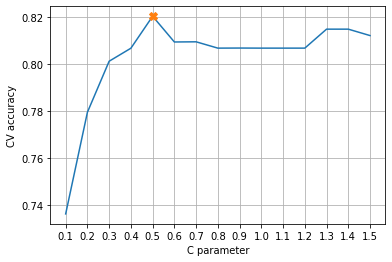

In [57]:
fig=plt.figure()
ax = fig.gca()
plt.plot(C2,cv.cv_results_["mean_test_score"])
ax.xaxis.set_major_locator(MultipleLocator(0.1))
plt.grid()
plt.plot(cv.best_params_["classifier__C"],cv.best_score_,marker="X",markersize=8)
plt.xlabel("C parameter")
plt.ylabel("CV accuracy")
print("The best parameters are:",cv.best_params_)
print("The CV score of this model is:",cv.best_score_)

Now we fit the model on the whole training set using the best parameters.

#### Result

In [58]:
model_l1 = Pipeline([('scaler',preprocessing.StandardScaler()), 
               ('classifier',LogisticRegression(solver='saga', penalty='l1',C=0.5,max_iter=4000))])
model_l1.fit(X_train_pd,y_train)
print("Train accuracy:", accuracy(y_train, model_l1.predict(X_train_pd)))
cv_lasso = cross_val_score(model_l1, X_train_pd, y_train, scoring=make_scorer(accuracy), cv=5, n_jobs=-1)
print("CV accuracy: ",np.mean(cv_lasso))

Train accuracy: 0.9918256130790191
CV accuracy:  0.8205109218807849


In [59]:
results_classifier=results_classifier.append({"model":model_l1,
                           "description":"lasso",
                           "train score":accuracy(y_train, model_l1.predict(X_train_pd)), 
                           "cv score":np.mean(cv_lasso)},ignore_index=True)

### 2.2.2 Ridge
Ridge regression is very similar to lasso: they vary in how the penalization is applied. Ridge puts a penalization on the $L2$ norm of the coefficient while lasso on the $L1$. We will repeat the same steps.

In [60]:
C2=np.arange(0.01, 0.5, 0.005)
model=Pipeline([('scaler',preprocessing.StandardScaler()), 
               ('classifier',LogisticRegression(solver='saga', penalty='l2',max_iter=4000))])

params = {'classifier__C': C2}
cv = GridSearchCV(model, params, refit=True, cv=5, n_jobs=-1,
                  verbose=False,
                  scoring=make_scorer(accuracy))
cv.fit(X_train_pd, y_train)
print("Done!")

Done!


In [61]:
pd.DataFrame(cv.cv_results_).sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
36       0.484436      0.046006         0.002200        0.000400   
32       0.456833      0.055079         0.002401        0.000491   
33       0.466634      0.059305         0.002200        0.000400   
34       0.473234      0.062459         0.002801        0.001166   
35       0.474035      0.058277         0.002200        0.000400   
..            ...           ...              ...             ...   
4        0.199119      0.023983         0.001200        0.000980   
3        0.181650      0.027428         0.003526        0.006101   
2        0.174531      0.021979         0.000000        0.000000   
1        0.127559      0.027694         0.000401        0.000801   
0        0.106283      0.026890         0.006252        0.007658   

   param_classifier__C                                   params  \
36                0.19   {'classifier__C': 0.18999999999999997}   
32                0.17   {'classifier__C': 0.16999999999999998}   
33               0.175                 {'classifier__C': 0.175}   
34                0.18                  {'classifier__C': 0.18}   
35               0.185   {'classifier__C': 0.18499999999999997}   
..                 ...                                      ...   
4                 0.03                  {'classifier__C': 0.03}   
3                0.025  {'classifier__C': 0.024999999999999998}   
2                 0.02  {'classifier__C': 0.019999999999999997}   
1                0.015                 {'classifier__C': 0.015}   
0                 0.01                  {'classifier__C': 0.01}   

    split0_test_score  split1_test_score  split2_test_score  \
36           0.675676           0.675676           0.767123   
32           0.675676           0.675676           0.767123   
33           0.675676           0.675676           0.767123   
34           0.675676           0.675676           0.767123   
35           0.675676           0.675676           0.767123   
..                ...                ...                ...   
4            0.621622           0.621622           0.726027   
3            0.621622           0.621622           0.726027   
2            0.581081           0.621622           0.753425   
1            0.554054           0.608108           0.739726   
0            0.527027           0.594595           0.726027   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
36           0.753425           0.698630         0.714106        0.038859   
32           0.753425           0.698630         0.714106        0.038859   
33           0.753425           0.698630         0.714106        0.038859   
34           0.753425           0.698630         0.714106        0.038859   
35           0.753425           0.698630         0.714106        0.038859   
..                ...                ...              ...             ...   
4            0.684932           0.684932         0.667827        0.040601   
3            0.684932           0.657534         0.662347        0.039763   
2            0.671233           0.630137         0.651499        0.058457   
1            0.671233           0.643836         0.643391        0.062100   
0            0.643836           0.616438         0.621585        0.064961   

    rank_test_score  
36                1  
32                1  
33                1  
34                1  
35                1  
..              ...  
4                94  
3                95  
2                96  
1                97  
0                98  

[98 rows x 14 columns]

The best parameters are: {'classifier__C': 0.16999999999999998}
The CV score of this model is: 0.7141058867086264


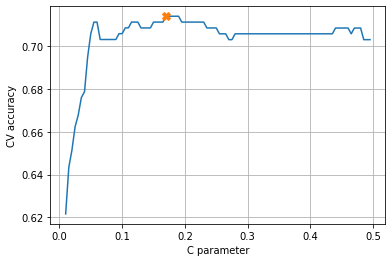

In [62]:
fig=plt.figure()
ax = fig.gca()
plt.plot(C2,cv.cv_results_["mean_test_score"])
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
plt.grid()
plt.plot(cv.best_params_["classifier__C"],cv.best_score_,marker="X",markersize=8)
plt.xlabel("C parameter")
plt.ylabel("CV accuracy")
print("The best parameters are:",cv.best_params_)
print("The CV score of this model is:",cv.best_score_)

In [63]:
model_l2 = Pipeline([('scaler',preprocessing.StandardScaler()), 
               ('classifier',LogisticRegression(solver='saga', penalty='l2',C=0.19,max_iter=4000))])

model_l2.fit(X_train_pd,y_train)
print("Train accuracy:", accuracy(y_train, model_l2.predict(X_train_pd)))
cv_ridge = cross_val_score(model_l2, X_train_pd, y_train, scoring=make_scorer(accuracy), cv=5, n_jobs=-1)
print("CV accuracy: ",np.mean(cv_ridge))

Train accuracy: 1.0
CV accuracy:  0.7141058867086264


In [64]:
results_classifier=results_classifier.append({"model":model_l2,
                           "description":"ridge",
                           "train score":accuracy(y_train, model_l2.predict(X_train_pd)), 
                           "cv score":np.mean(cv_ridge)},ignore_index=True)

### 2.2.3 Model comparison
Let's compare the scores for these three logistic regression models.

In [65]:
results_classifier[["description","train score","cv score"]]

description  train score  cv score
0  logistic regression     1.000000  0.637653
1                lasso     0.991826  0.820511
2                ridge     1.000000  0.714106

Between these three, the lasso performed better, so let's inspect this model. How many features have a non-0 coefficient?

In [66]:
betas=pd.DataFrame(model_l1['classifier'].coef_)
betas.columns=proteins
betas.index=model_l1.classes_
mask=betas!=0
features=mask.sum(axis=0)!=0
features=features[:-1]
print(sum(features), "features were used in this model")

70 features were used in this model


Which features are present in this model and how many classes are they informative about?

[Text(0, 0.5, 'n models'), Text(0.5, 0, 'protein')]

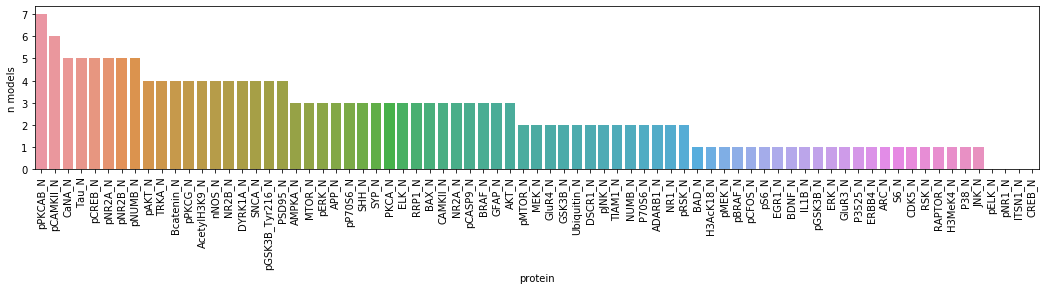

In [67]:
#a[a!=0]
a=mask.sum(axis=0)
fig=plt.figure(figsize=(18,3))

plt.xticks(rotation='vertical')
#sns.barplot(np.array(proteins[features]),np.array(a[a!=0]))
a=sns.barplot(a.sort_values().index[::-1],a.sort_values()[::-1])
a.set(xlabel='protein', ylabel='n models')

How many features does each of the eight models have?

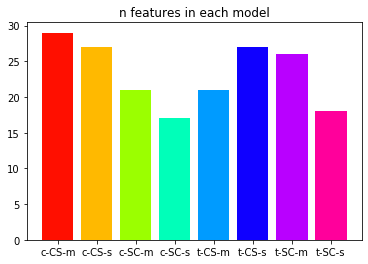

In [68]:
i=0
for c in classes:
    b=betas.loc[c]
    mask=b!=0
    b=b[mask]
    plt.bar(x=c,height=len(b),color=colors[i])
    i+=1
plt.title("n features in each model")
plt.show()

Which features are relevant for each class?

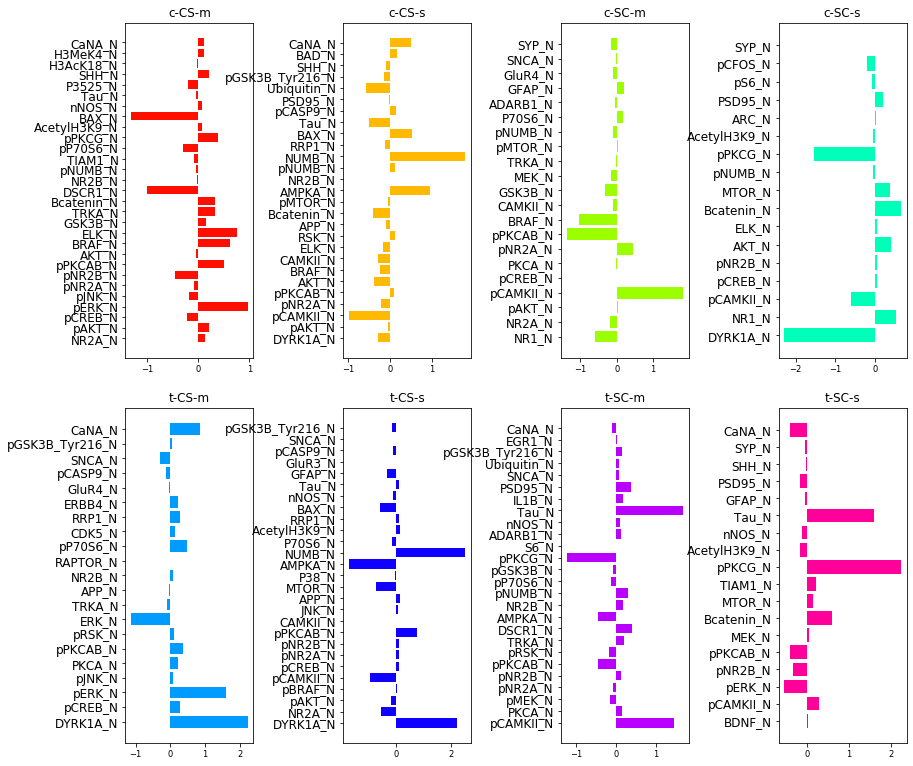

In [69]:
plt.close()
i=1
fig=plt.figure(figsize=(14,5))
plt.subplots_adjust(top=5,bottom=3)
fig.subplots_adjust(wspace=0.7,hspace=0.15)
for c in classes:
    b=betas.loc[c]
    mask=b!=0
    b=b[mask]
    a=fig.add_subplot(2,4,i)
    i+=1
    plt.barh(b.index,b,color=coldict[coldict["class"]==c]["color"])
    plt.title(c)
    plt.xticks(size="small")
    plt.yticks(size="large")

In [70]:
#leave me empty

<div id="2.3"></div>

## 2.3 Linear discriminant analysis

LDA is based on a similar concept of Logistic Regression, that is to model posterior probabilities as a **linear function of $x$**. However, the relation is found through the Bayes Theorem instead of the logistic function. The problem boils down to finding the parameters $\hat{\mu}_{k}$, $\hat{\sigma}^2$ and $\hat{\pi}_k$ which are used to compute a **discriminating function** for each class: each point is assigned to the class with the highest discriminating function. LDA relies on the assumptions that the features come from a multivariate Gaussian distribution with a common covariance matrix for all classes.

First we fit a model on the whole training data.

In [71]:
model = LDA()
model = model.fit(X_train_pd, y_train)
print("Train accuracy:", accuracy(y_train, model.predict(X_train_pd)))
cv_lda = cross_val_score(model, X_train_pd, y_train, scoring=make_scorer(accuracy), cv=5,n_jobs=-1)
print("CV score:", np.mean(cv_lda))

Train accuracy: 0.9727520435967303
CV score: 0.7876712328767124


In [72]:
results_classifier=results_classifier.append({"model":model,
                                              "description":"LDA",
                           "train score":accuracy(y_train, model.predict(X_train_pd)), 
                           "cv score":np.mean(cv_lda)},ignore_index=True)

### Feature selection
For LDA, no regularization is available, so we will try two methods of feature selection:
- forward feature selection
- selectkbest - is a form of filtering which considers only the k features with highest mutual information. This means that the features are not selected based on how much they improve the model but "a priori" based on the MI score, similarly to what we did for the clustering. This type of feature selection depends on the data so we need to apply it after the k fold split if we want to do k-fold cross validation.

### 2.3.1 Forward feature selection
We slightly modify the code from Dr. Cannici to allow using any estimator. We also remove the part in which we calculate scores for the test set.  
If you just want to see the results go to: <a href="#resLDA">this cell</a>.

In [75]:
def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator   

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv, n_jobs=-1)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

def get_val_evaluator(scorer, val_size=0.1):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=0)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

In [76]:
def general_ff(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      #test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0,plot_results=True, 
               dummyModel = DummyRegressor,mod = LinearRegression,**kwargs):   # estimator and parameters
    #test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    #test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    #subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    if plot_results==True:    
        plt.figure()
        candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = dummyModel()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    if plot_results==True:
        _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    score_3=score
    #_, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    #subsets_test.append(score)
    dim=0
    if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim, []))
            print("M{} CV score (2.): {}".format(dim, score_3))
            #print("M{} test score (3.): {}".format(dim, score))
        
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    for dim in range(1,len(all_features)+1):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Fixed the number of features 'dim', look at
        #     all the possible candidate models with that
        #     cardinality
        # ===============================================
        remaining_features = all_features.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = mod(**kwargs)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
        if plot_results==True:
            
            _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate among those using
        #     the same number of features (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        # Update selected feature
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        step3_score=score
        #best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        #_, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        #subsets_test.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim, best_features))
            #print("M{} subset score (3.): {}".format(dim, score))
            print("M{} CV score (3.): {}".format(dim, step3_score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    best_score = subsets_metric[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Score step: {}".format(best_score))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    if plot_results==True:
        best_candidate_score_idx = candidates_argbest(best_candidate_metric)
        _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
        _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
        candidate_fig.set_title(candidates_scorer_name)
        candidate_fig.legend()
    
        # Plot a figure to show how te 3. metric evolves
        plt.figure()
        subsets_fig = plt.subplot(111)
        _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
        _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
        #best_test_score_idx = test_argbest(subsets_test)
        #_ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
        #_ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
        #                          marker='X', label="Best test score", color="y")
        subsets_fig.set_title(subsets_scorer_name)
        subsets_fig.legend()
    return(best_features,best_score,subsets_metric)

C:\Users\kikka\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


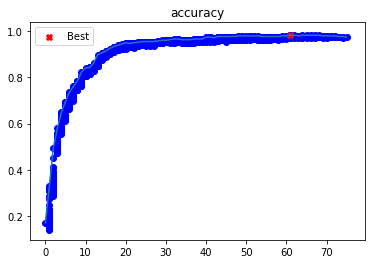

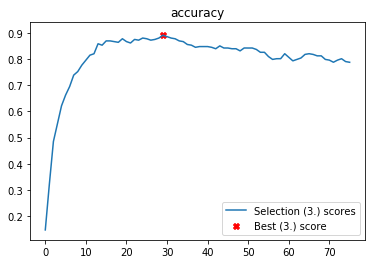

In [79]:
bf_lda,bscore,scores=general_ff(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.b
                  get_cv_evaluator(make_scorer(accuracy), cv=5), np.argmax, # 3.
                  #get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="accuracy",
                  subsets_scorer_name="accuracy",
                  verbose=False,
                   dummyModel=DummyClassifier,mod=LDA)

<div id="resLDA"></div>

#### Result
The best result was obtained with 29 features and gave a CV score of 0.89.

In [80]:
print(len(bf_lda), "features were selected")
print(bf_lda)

29 features were selected
['pERK_N', 'pPKCG_N', 'pCAMKII_N', 'ERK_N', 'pPKCAB_N', 'BRAF_N', 'Tau_N', 'BAX_N', 'DYRK1A_N', 'CaNA_N', 'AMPKA_N', 'NR2A_N', 'NUMB_N', 'ELK_N', 'MTOR_N', 'TRKA_N', 'DSCR1_N', 'P3525_N', 'RRP1_N', 'SHH_N', 'CAMKII_N', 'pGSK3B_Tyr216_N', 'GluR4_N', 'PKCA_N', 'CREB_N', 'H3AcK18_N', 'pAKT_N', 'AcetylH3K9_N', 'pCFOS_N']


In [81]:
#as before i already have them in this variable so you don't have to run the feature selection

bf_lda=['pERK_N', 'pPKCG_N', 'pCAMKII_N', 'ERK_N', 'pPKCAB_N', 'BRAF_N', 'Tau_N', 'BAX_N', 'DYRK1A_N', 'CaNA_N', 'AMPKA_N', 'NR2A_N', 'NUMB_N', 'ELK_N', 'MTOR_N', 'TRKA_N', 'DSCR1_N', 'P3525_N', 'RRP1_N', 'SHH_N', 'CAMKII_N', 'pGSK3B_Tyr216_N', 'GluR4_N', 'PKCA_N', 'CREB_N', 'H3AcK18_N', 'pAKT_N', 'AcetylH3K9_N', 'pCFOS_N']

model_lda_reduced=LDA()
model_lda_reduced.fit(X_train_pd[bf_lda],y_train)
print("Train accuracy:", accuracy(y_train, model_lda_reduced.predict(X_train_pd[bf_lda])))
cv_ldared = cross_val_score(model_lda_reduced, X_train_pd[bf_lda], y_train, scoring=make_scorer(accuracy), cv=5,n_jobs=-1)
print("CV score:", np.mean(cv_ldared))

Train accuracy: 0.9591280653950953
CV score: 0.8911884487226953


In [83]:
results_classifier=results_classifier.append({"model":model_lda_reduced,
                            "description":"LDA forward",
                           "train score":accuracy(y_train, model_lda_reduced.predict(X_train_pd[bf_lda])), 
                           "cv score":np.mean(cv_ldared)},ignore_index=True)

### 2.3.2 SelectKBest

In [84]:
K=np.arange(1,76)
# Validation
model = Pipeline([('selector', SelectKBest(mutual_info_classif)),
                  ('classifier', LDA())])
k=np.arange(1,76)
params = {'selector__k': k}
cv = GridSearchCV(model, params, scoring=make_scorer(accuracy), cv=5,n_jobs=-1,verbose=True)
cv = cv.fit(X_train_pd, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  1.3min finished


In [85]:
kbest=pd.DataFrame(cv.cv_results_)
kbest.sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
35       1.784105      0.258270         0.011000        0.015008   
20       1.275036      0.030541         0.006852        0.007250   
37       1.946944      0.142245         0.003600        0.000490   
33       1.578316      0.029876         0.004526        0.005777   
16       1.341599      0.081643         0.001400        0.001200   
..            ...           ...              ...             ...   
4        1.227868      0.103389         0.000000        0.000000   
3        1.291314      0.202405         0.004314        0.005746   
2        1.394702      0.215128         0.003001        0.000634   
1        1.313517      0.153969         0.001200        0.001470   
0        1.215000      0.111490         0.001800        0.000980   

   param_selector__k               params  split0_test_score  \
35                36  {'selector__k': 36}           0.770270   
20                21  {'selector__k': 21}           0.756757   
37                38  {'selector__k': 38}           0.770270   
33                34  {'selector__k': 34}           0.783784   
16                17  {'selector__k': 17}           0.770270   
..               ...                  ...                ...   
4                  5   {'selector__k': 5}           0.581081   
3                  4   {'selector__k': 4}           0.554054   
2                  3   {'selector__k': 3}           0.594595   
1                  2   {'selector__k': 2}           0.500000   
0                  1   {'selector__k': 1}           0.270270   

    split1_test_score  split2_test_score  split3_test_score  \
35           0.851351           0.849315           0.876712   
20           0.864865           0.849315           0.863014   
37           0.851351           0.849315           0.876712   
33           0.851351           0.835616           0.876712   
16           0.864865           0.849315           0.876712   
..                ...                ...                ...   
4            0.648649           0.589041           0.561644   
3            0.581081           0.561644           0.520548   
2            0.581081           0.534247           0.534247   
1            0.472973           0.438356           0.520548   
0            0.283784           0.315068           0.301370   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
35           0.849315         0.839393        0.036085                1  
20           0.849315         0.836653        0.040484                2  
37           0.835616         0.836653        0.035746                3  
33           0.835616         0.836616        0.030391                4  
16           0.821918         0.836616        0.037907                5  
..                ...              ...             ...              ...  
4            0.589041         0.593891        0.029153               71  
3            0.520548         0.547575        0.023763               72  
2            0.493151         0.547464        0.036471               73  
1            0.493151         0.485006        0.027840               74  
0            0.328767         0.299852        0.020991               75  

[75 rows x 14 columns]

The best parameters are: {'selector__k': 36}
The CV score of this model is: 0.8393928174750093


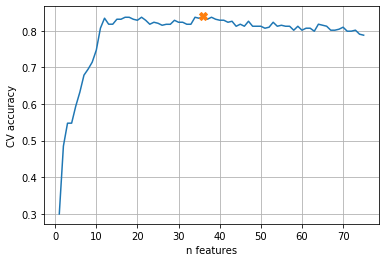

In [86]:
fig=plt.figure()
ax = fig.gca()
plt.plot(K,kbest["mean_test_score"])
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
plt.grid()
plt.plot(cv.best_params_["selector__k"],cv.best_score_,marker="X",markersize=8)
plt.xlabel("n features")
plt.ylabel("CV accuracy")
print("The best parameters are:",cv.best_params_)
print("The CV score of this model is:",cv.best_score_)

#### Result
The best result was obtained with 36 features and gave a CV score of 0.84.

In [87]:
print(cv.best_params_['selector__k'],"features were selected")
selected_lda=proteins[cv.best_estimator_[0].get_support()]
print(list(selected_lda))

36 features were selected
['DYRK1A_N', 'ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pCAMKII_N', 'pELK_N', 'pERK_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N', 'pRSK_N', 'AKT_N', 'BRAF_N', 'ELK_N', 'ERK_N', 'GSK3B_N', 'JNK_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'pNUMB_N', 'TIAM1_N', 'NUMB_N', 'pPKCG_N', 'ADARB1_N', 'AcetylH3K9_N', 'BAX_N', 'Tau_N', 'pCASP9_N', 'PSD95_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'CaNA_N']


In [88]:
model_lda_kbest=model = Pipeline([('selector', SelectKBest(mutual_info_classif,k=36)),
                  ('classifier', LDA())])
model_lda_kbest.fit(X_train_pd,y_train)
print("Train accuracy:", accuracy(y_train, model_lda_kbest.predict(X_train_pd)))
cv_ldak = cross_val_score(model_lda_kbest, X_train_pd, y_train, scoring=make_scorer(accuracy), cv=5,n_jobs=-1)
print("CV score:", np.mean(cv_ldak))

Train accuracy: 0.9100817438692098
CV score: 0.8393928174750093


In [89]:
results_classifier=results_classifier.append({"model":model_lda_kbest,
                           "description":"LDA 36 best",
                           "train score":accuracy(y_train, model_lda_kbest.predict(X_train_pd)), 
                           "cv score":np.mean(cv_ldak)},ignore_index=True)

<div id="2.4"></div>

## 2.4 Quadratic discriminant analysis

QDA does not rely on the assumption that all classes have the same covariance matrix.

In [90]:
model = QDA(store_covariance=True)
model = model.fit(X_train_pd, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train_pd)))
cv_qda = cross_val_score(model, X_train_pd, y_train, scoring=make_scorer(accuracy), cv=5)
print("CV score:", np.mean(cv_qda))

Train accuracy: 1.0
CV score: 0.2070714550166605


C:\Users\kikka\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\kikka\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\kikka\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\kikka\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\kikka\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\kikka\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [91]:
results_classifier=results_classifier.append({"model":model,
                           "description":"QDA complete",
                           "train score":accuracy(y_train, model.predict(X_train_pd)), 
                           "cv score":np.mean(cv_qda)},ignore_index=True)

We get very poor results with QDA performed on all the features: we also get warnings for collinearity of the features. Let's see if selecting the features improves performances.

### 2.4.1 Forward feature selection 

For this next cell we are going to suppress warnings since they are invadent.

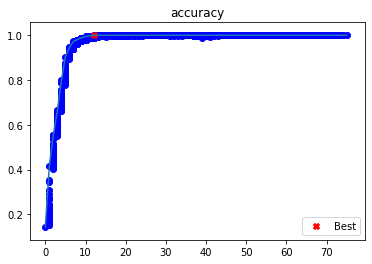

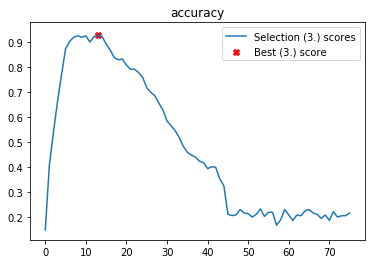

In [92]:
%%capture --no-stdout --no-display
#this line is to catch the warnings
bf_qda,bscore,scores=general_ff(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.b
                  get_cv_evaluator(make_scorer(accuracy), cv=5), np.argmax, # 3.
                  #get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="accuracy",
                  subsets_scorer_name="accuracy",
                  verbose=False,
                   dummyModel=DummyClassifier,mod=QDA,store_covariance=True)

#### Result 
From 26 features on, we start to get warnings for colinearity of variables (which were suppressed for readability). However, we obtain a high CV score: 0.926. We get the best result with 13 features.

In [93]:
print(len(bf_qda), "features were selected")
print(bf_qda)

13 features were selected
['pPKCG_N', 'pERK_N', 'pCAMKII_N', 'Tau_N', 'NUMB_N', 'BAX_N', 'NR2A_N', 'ELK_N', 'P3525_N', 'AMPKA_N', 'RAPTOR_N', 'pCASP9_N', 'ADARB1_N']


In [94]:
bf_qda=['pPKCG_N', 'pERK_N', 'pCAMKII_N', 'Tau_N', 'NUMB_N', 'BAX_N', 'NR2A_N', 'ELK_N', 'P3525_N', 'AMPKA_N', 'RAPTOR_N', 'pCASP9_N', 'ADARB1_N']
model_qda_reduced=QDA()
model_qda_reduced.fit(X_train_pd[bf_qda],y_train)
print("Train accuracy:", accuracy(y_train, model_qda_reduced.predict(X_train_pd[bf_qda])))
cv_qdared = cross_val_score(model_qda_reduced, X_train_pd[bf_qda], y_train, scoring=make_scorer(accuracy), cv=5,n_jobs=-1)
print("CV score:", np.mean(cv_qdared))

Train accuracy: 1.0
CV score: 0.926434653831914


In [95]:
results_classifier=results_classifier.append({"model":model_qda_reduced,
                            "description":"QDA forward",
                           "train score":accuracy(y_train, model_qda_reduced.predict(X_train_pd[bf_qda])), 
                           "cv score":np.mean(cv_qdared)},ignore_index=True)

### 2.4.2 SelectKBest

In [96]:
K=np.arange(1,76)
# Validation
model = Pipeline([('selector', SelectKBest(mutual_info_classif)),
                  ('classifier', QDA())])
k=np.arange(1,76)
params = {'selector__k': k}
cv = GridSearchCV(model, params, scoring=make_scorer(accuracy), cv=5,n_jobs=-1,verbose=False)
cv = cv.fit(X_train_pd, y_train)
print("Done!")

Done!


In [97]:
kbestqda=pd.DataFrame(cv.cv_results_)
kbestqda.sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
11       1.260648      0.009531         0.001801        0.001471   
12       1.324383      0.035596         0.005326        0.005393   
13       1.327397      0.047314         0.005325        0.005787   
14       1.359557      0.068091         0.004597        0.004411   
10       1.209872      0.040254         0.002000        0.001673   
..            ...           ...              ...             ...   
67       1.803991      0.105788         0.003415        0.002879   
53       1.434307      0.085760         0.004001        0.000001   
57       1.565716      0.098661         0.004401        0.000490   
64       1.784811      0.296582         0.007401        0.004842   
68       1.715482      0.048029         0.010652        0.004271   

   param_selector__k               params  split0_test_score  \
11                12  {'selector__k': 12}           0.891892   
12                13  {'selector__k': 13}           0.918919   
13                14  {'selector__k': 14}           0.891892   
14                15  {'selector__k': 15}           0.878378   
10                11  {'selector__k': 11}           0.878378   
..               ...                  ...                ...   
67                68  {'selector__k': 68}           0.216216   
53                54  {'selector__k': 54}           0.189189   
57                58  {'selector__k': 58}           0.216216   
64                65  {'selector__k': 65}           0.189189   
68                69  {'selector__k': 69}           0.108108   

    split1_test_score  split2_test_score  split3_test_score  \
11           0.918919           0.931507           0.958904   
12           0.905405           0.931507           0.945205   
13           0.891892           0.945205           0.917808   
14           0.878378           0.931507           0.904110   
10           0.891892           0.904110           0.917808   
..                ...                ...                ...   
67           0.189189           0.178082           0.205479   
53           0.229730           0.219178           0.219178   
57           0.216216           0.260274           0.164384   
64           0.162162           0.219178           0.178082   
68           0.243243           0.164384           0.191781   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
11           0.917808         0.923806        0.021769                1  
12           0.917808         0.923769        0.013533                2  
13           0.904110         0.910181        0.019954                3  
14           0.917808         0.902036        0.021171                4  
10           0.917808         0.901999        0.015260                5  
..                ...              ...             ...              ...  
67           0.178082         0.193410        0.015189               71  
53           0.109589         0.193373        0.044025               72  
57           0.082192         0.187856        0.060941               73  
64           0.164384         0.182599        0.020743               74  
68           0.164384         0.174380        0.043902               75  

[75 rows x 14 columns]

#### Result
The best performances were obtained with 12 features and gave a CV score of 0.92.

In [98]:
print(cv.best_params_['selector__k'],"features were selected")
selected_qda=proteins[cv.best_estimator_[0].get_support()]
print(list(selected_qda))

12 features were selected
['DYRK1A_N', 'pCAMKII_N', 'pERK_N', 'pPKCAB_N', 'BRAF_N', 'MTOR_N', 'DSCR1_N', 'AMPKA_N', 'NUMB_N', 'pPKCG_N', 'Tau_N', 'CaNA_N']


In [99]:
model_qda_kbest=model = Pipeline([('selector', SelectKBest(mutual_info_classif,k=12)),
                  ('classifier', QDA())])
model_qda_kbest.fit(X_train_pd,y_train)
print("Train accuracy:", accuracy(y_train, model_qda_kbest.predict(X_train_pd)))
cv_qdak = cross_val_score(model_qda_kbest, X_train_pd, y_train, scoring=make_scorer(accuracy), cv=5,n_jobs=-1)
print("CV score:", np.mean(cv_qdak))

Train accuracy: 0.9945504087193461
CV score: 0.9238059977786005


In [100]:
results_classifier=results_classifier.append({"model":model_qda_kbest,
                           "description":"QDA 12 best",
                           "train score":accuracy(y_train, model_qda_kbest.predict(X_train_pd)), 
                           "cv score":np.mean(cv_qdak)},ignore_index=True)

Discriminant analysis outperformed logistic regression.

<div id="2.5"></div>

## 2.5 Support Vector Machines

In SVM, instead of trying to model the distribution of the data, we find the hyperplane in the feature space that maximizes the margin between the class boundary and the samples, allowing some misclassification with the parameter C. The biggest strength of SVM is the possibility of transforming our features with a **kernel function** to obtain a separation boundary which is not linear in the original feature space, to separate non-linearly separable classes, while still being a fast algorithm.  
We can optimize C and the kernel to use, so we will do a grid search.

### 2.4.1 Linear kernel   
First we will do a grid search with a linear kernel.

In [101]:
C=np.linspace(0.01, 10, 50)
C=np.append(C,np.inf)
param_grid = {'C': C}
svm_model = SVC(kernel='linear')
svm_linear= GridSearchCV(svm_model, param_grid,
                        cv=5, scoring=make_scorer(accuracy), refit=True,
                        verbose=False, n_jobs=-1)
svm_linear.fit(X_train_pd, y_train)
print("Done!")

Done!


In [102]:
pd.DataFrame(svm_linear.cv_results_).sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time   param_C  \
5        0.019200  1.938814e-03         0.004001        0.000633   1.02939   
13       0.023598  5.388385e-03         0.003601        0.000491   2.66041   
14       0.027213  1.928359e-02         0.002798        0.001469   2.86429   
6        0.020400  2.058852e-03         0.005400        0.001357   1.23327   
12       0.022203  3.919459e-03         0.004199        0.000399   2.45653   
9        0.027603  1.074354e-02         0.004800        0.002134    1.8449   
11       0.021599  2.728681e-03         0.004803        0.000750   2.25265   
7        0.027602  6.406205e-03         0.004400        0.000491   1.43714   
22       0.018756  6.252337e-03         0.006252        0.007657   4.49531   
21       0.025007  1.250378e-02         0.000000        0.000000   4.29143   
23       0.015629  7.008046e-07         0.003126        0.006252   4.69918   
24       0.015629  7.629395e-07         0.003126        0.006252   4.90306   
8        0.030601  5.390051e-03         0.004000        0.000635   1.64102   
10       0.029401  1.237179e-02         0.004001        0.000003   2.04878   
15       0.026389  6.073457e-03         0.002600        0.002154   3.06816   
17       0.018439  6.439189e-03         0.006252        0.007657   3.47592   
18       0.014513  2.233005e-03         0.006252        0.007657    3.6798   
16       0.017073  4.298849e-03         0.003925        0.006053   3.27204   
39       0.018755  6.251813e-03         0.014489        0.022012   7.96122   
38       0.018756  6.252337e-03         0.006251        0.007656   7.75735   
40       0.018756  6.251836e-03         0.003125        0.006250    8.1651   
41       0.026755  9.628349e-03         0.005889        0.006053   8.36898   
42       0.018756  6.251145e-03         0.000000        0.000000   8.57286   
37       0.015628  1.040336e-06         0.006253        0.007658   7.55347   
36       0.018756  6.252623e-03         0.006251        0.007656   7.34959   
25       0.018756  6.251931e-03         0.003126        0.006252   5.10694   
44       0.020593  9.925938e-03         0.003726        0.006064   8.98061   
35       0.015630  1.302385e-06         0.006252        0.007657   7.14571   
45       0.018756  6.251145e-03         0.003125        0.006250   9.18449   
46       0.020867  6.834141e-03         0.004926        0.005728   9.38837   
47       0.018341  2.873820e-03         0.005325        0.005356   9.59224   
48       0.021702  6.637533e-03         0.003201        0.001721   9.79612   
43       0.022318  8.220196e-03         0.003925        0.006052   8.77673   
34       0.018756  6.252217e-03         0.003126        0.006252   6.94184   
50       0.020199  2.787688e-03         0.003200        0.000398       inf   
32       0.021882  7.657790e-03         0.000000        0.000000   6.53408   
31       0.015630  1.083166e-06         0.003126        0.006252    6.3302   
30       0.021882  7.656758e-03         0.000000        0.000000   6.12633   
29       0.018755  6.252050e-03         0.003126        0.006252   5.92245   
28       0.021881  7.656388e-03         0.003126        0.006252   5.71857   
27       0.018756  6.252384e-03         0.000000        0.000000   5.51469   
26       0.015630  9.047349e-07         0.006252        0.007657   5.31082   
49       0.023000  2.279831e-03         0.004801        0.001166        10   
20       0.018756  6.251597e-03         0.003126        0.006252   4.08755   
19       0.013313  4.631805e-03         0.006252        0.007657   3.88367   
33       0.018755  6.251955e-03         0.009378        0.007657   6.73796   
4        0.017603  1.496287e-03         0.004000        0.000633   0.82551   
1        0.015601  1.744408e-03         0.003599        0.000802  0.213878   
3        0.013401  1.355201e-03         0.003801        0.000749  0.621633   
2        0.016598  1.497326e-03         0.003801        0.000400  0.417755   
0        0.019002  1.89670

#### Result
For the linear kernel we get the best results with C=1 which gives a CV score of 0.74.

{'C': 1.029387755102041}
0.7357645316549426


Text(0.5, 1.0, 'SVM with linear kernel')

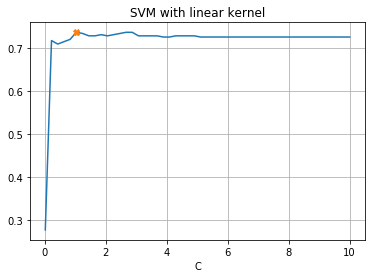

In [103]:
print(svm_linear.best_params_)
print(svm_linear.best_score_)
plt.plot(C,svm_linear.cv_results_["mean_test_score"])
plt.plot(svm_linear.best_params_['C'],svm_linear.best_score_,marker='X')
plt.grid()
plt.xlabel("C")
plt.title("SVM with linear kernel")

In [104]:
model = SVC(kernel='linear', C=1)
model.fit(X_train_pd, y_train)

train_acc = accuracy_score(model.predict(X_train_pd), y_train)
test_acc = accuracy_score(model.predict(X_test_pd), y_test)

print("SVM train accuracy:", train_acc)
#print("SVM test accuracy:", test_acc)
cv_svm = cross_val_score(model, X_train_pd, y_train, scoring=make_scorer(accuracy), cv=5,n_jobs=-1)
print("SVM CV score:", np.mean(cv_svm))

SVM train accuracy: 0.9754768392370572
SVM CV score: 0.7330248056275452


In [105]:
results_classifier=results_classifier.append({"description":"SVM linear",
                           "model":model,
                           "train score":train_acc, 
                           "cv score":np.mean(cv_svm)},ignore_index=True)

### 2.4.2 Polynomial kernel  
Next, we try a polynomial kernel, in which we have to optimize:
- C
- degree of the polynomial
- coefficient

In [106]:
C=np.linspace(0.001, 10, 10)
#C=np.append(C,np.inf)
coef0=np.linspace(-10, 10, 5)
degree=[1,2,3,4,5,6,7]
param_grid = {'C': C,
              'coef0':coef0,
              'degree': degree}
model_poly = SVC(kernel='poly')
svm_poly = GridSearchCV(model_poly, param_grid,
                        cv=5, scoring='accuracy', refit=True,
                       verbose=False, n_jobs=-1)
svm_poly.fit(X_train_pd, y_train)
print("Done!")

Done!


In [107]:
r = pd.DataFrame(svm_poly.cv_results_)
r.sort_values(by="rank_test_score")[r["rank_test_score"]==1]

C:\Users\kikka\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
207       0.021881      0.007657         0.003126        0.006252   5.556   
347       0.021883      0.007657         0.003126        0.006251      10   
67        0.020397      0.005424         0.002200        0.001833   1.112   
312       0.021882      0.007657         0.003126        0.006252   8.889   
102       0.027001      0.007015         0.007402        0.007311   2.223   
277       0.021881      0.007658         0.000000        0.000000   7.778   
137       0.021881      0.007657         0.003126        0.006252   3.334   
242       0.015630      0.000001         0.003126        0.006252   6.667   
172       0.023727      0.009040         0.003211        0.002032   4.445   

    param_coef0 param_degree  \
207          10            5   
347          10            5   
67           10            5   
312          10            5   
102          10            5   
277          10            5   
137          10            5   
242          10            5   
172          10            5   

                                                params  split0_test_score  \
207           {'C': 5.556, 'coef0': 10.0, 'degree': 5}           0.783784   
347            {'C': 10.0, 'coef0': 10.0, 'degree': 5}           0.783784   
67   {'C': 1.1119999999999999, 'coef0': 10.0, 'degr...           0.783784   
312           {'C': 8.889, 'coef0': 10.0, 'degree': 5}           0.783784   
102           {'C': 2.223, 'coef0': 10.0, 'degree': 5}           0.783784   
277  {'C': 7.7780000000000005, 'coef0': 10.0, 'degr...           0.783784   
137           {'C': 3.334, 'coef0': 10.0, 'degree': 5}           0.783784   
242  {'C': 6.667000000000001, 'coef0': 10.0, 'degre...           0.783784   
172           {'C': 4.445, 'coef0': 10.0, 'degree': 5}           0.783784   

     split1_test_score  split2_test_score  split3_test_score  \
207           0.810811           0.753425           0.712329   
347           0.810811           0.753425           0.712329   
67            0.810811           0.753425           0.712329   
312           0.810811           0.753425           0.712329   
102           0.810811           0.753425           0.712329   
277           0.810811           0.753425           0.712329   
137           0.810811           0.753425           0.712329   
242           0.810811           0.753425           0.712329   
172           0.810811           0.753425           0.712329   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
207           0.712329         0.754535        0.038952                1  
347           0.712329         0.754535        0.038952                1  
67            0.712329         0.754535        0.038952                1  
312           0.712329         0.754535        0.038952                1  
102           0.712329         0.754535        0.038952                1  
277           0.712329         0.754535        0.038952                1  
137           0.712329         0.754535        0.038952                1  
242           0.712329         0.754535        0.038952                1  
172           0.712329         0.754535        0.038952                1

#### Result
The polynomial kernel has the best results with C=1.11, coefficient=10 and fifth degree, which give a CV score of 0.75.  The score however reaches a plateau after C=1 for most values of coef0.

In [108]:
svm_poly.best_params_

{'C': 1.1119999999999999, 'coef0': 10.0, 'degree': 5}

Text(0.5, 1.0, 'Scores for best degree')

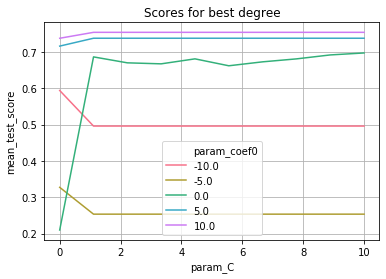

In [109]:
palette = sns.color_palette("husl", 5)
d=svm_poly.best_params_['degree']
res=r[r["param_degree"] == d]
sns.lineplot(x=res["param_C"],y=res["mean_test_score"],hue=res["param_coef0"],
             #style=res["param_coef0"],
             palette=palette,
            markers=True,dashes=False)
plt.grid()
plt.title("Scores for best degree")

In [110]:
model = SVC(kernel='poly', C=1.112, coef0=10,degree=5)
model.fit(X_train_pd, y_train)

train_acc = accuracy_score(model.predict(X_train_pd), y_train)
test_acc = accuracy_score(model.predict(X_test_pd), y_test)

print("SVM train accuracy:", train_acc)
#print("SVM test accuracy:", test_acc)
cv_svp = cross_val_score(model, X_train_pd, y_train, scoring=make_scorer(accuracy), cv=5,n_jobs=-1)
print("SVM CV score:", np.mean(cv_svp))

SVM train accuracy: 1.0
SVM CV score: 0.7545353572750834


In [111]:
results_classifier=results_classifier.append({"model":model,
                           "description":"SVM poly",
                           "train score":train_acc, 
                           "cv score":np.mean(cv_svm)},ignore_index=True)

### 2.4.3 RBF kernel
For the RBF kernel we have to optimize C and gamma.

In [112]:
gamma=np.linspace(0.001,1,20)
C=[0.001,0.005,0.01,0.05,0.1,1]
C=C+list(np.arange(5,21,1))
param_grid = {'C': C,
              'gamma': gamma}
rbf_poly = GridSearchCV(SVC(kernel='rbf'), param_grid, 
                        cv=5, scoring='accuracy', refit=True,verbose=False,n_jobs=-1)
rbf_poly.fit(X_train_pd, y_train)
print("Done!")

Done!


In [113]:
r2 = pd.DataFrame(rbf_poly.cv_results_)
r2.sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
385       0.034386      0.006252         0.000000    0.000000e+00      18   
325       0.025008      0.007657         0.006252    7.656758e-03      15   
305       0.015630      0.000001         0.015629    8.662177e-07      14   
405       0.018756      0.006252         0.015630    3.989506e-07      19   
365       0.034385      0.006253         0.000000    0.000000e+00      17   
..             ...           ...              ...             ...     ...   
20        0.018756      0.006252         0.006252    7.657283e-03   0.005   
100       0.023653      0.002826         0.004200    3.998069e-04       1   
40        0.018755      0.006253         0.006252    7.657167e-03    0.01   
80        0.021016      0.006740         0.006047    7.412700e-03     0.1   
0         0.020396      0.001743         0.004402    8.015180e-04   0.001   

    param_gamma                                   params  split0_test_score  \
385    0.263895  {'C': 18, 'gamma': 0.26389473684210524}           0.756757   
325    0.263895  {'C': 15, 'gamma': 0.26389473684210524}           0.756757   
305    0.263895  {'C': 14, 'gamma': 0.26389473684210524}           0.756757   
405    0.263895  {'C': 19, 'gamma': 0.26389473684210524}           0.756757   
365    0.263895  {'C': 17, 'gamma': 0.26389473684210524}           0.756757   
..          ...                                      ...                ...   
20        0.001             {'C': 0.005, 'gamma': 0.001}           0.148649   
100       0.001                 {'C': 1, 'gamma': 0.001}           0.148649   
40        0.001              {'C': 0.01, 'gamma': 0.001}           0.148649   
80        0.001               {'C': 0.1, 'gamma': 0.001}           0.148649   
0         0.001             {'C': 0.001, 'gamma': 0.001}           0.148649   

     split1_test_score  split2_test_score  split3_test_score  \
385           0.810811           0.904110           0.808219   
325           0.810811           0.904110           0.808219   
305           0.810811           0.904110           0.808219   
405           0.810811           0.904110           0.808219   
365           0.810811           0.904110           0.808219   
..                 ...                ...                ...   
20            0.148649           0.219178           0.219178   
100           0.148649           0.219178           0.219178   
40            0.148649           0.219178           0.219178   
80            0.148649           0.219178           0.219178   
0             0.148649           0.219178           0.219178   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
385           0.808219         0.817623        0.047766                1  
325           0.808219         0.817623        0.047766                1  
305           0.808219         0.817623        0.047766                1  
405           0.808219         0.817623        0.047766                1  
365           0.808219         0.817623        0.047766                1  
..                 ...              ...             ...              ...  
20            0.260274         0.199185        0.043907              435  
100           0.260274         0.199185        0.043907              435  
40            0.260274         0.199185        0.043907              435  
80            0.260274         0.199185        0.043907              435  
0             0.260274         0.199185        0.043907              435  

[440 rows x 15 columns]

#### Result
The best results were obtained with gamma 0.26 and C = 5, also in this case we have a plateau after C=5 for most values of gamma.

Text(0.5, 1.0, 'Scores')

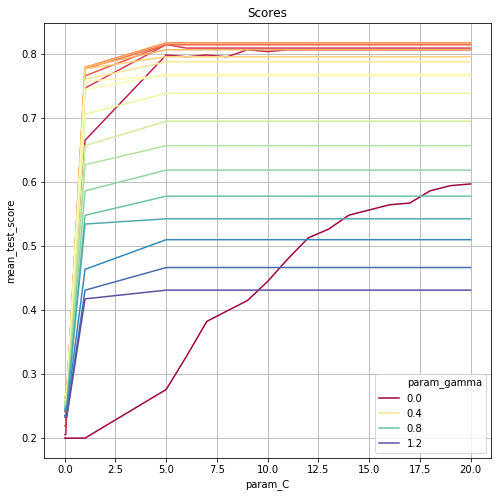

In [114]:
fig=plt.figure(figsize=(8,8))
sns.lineplot(x=r2["param_C"],y=r2["mean_test_score"],hue=r2["param_gamma"],palette="Spectral",
            markers=True,dashes=False)
plt.grid()
plt.title("Scores")

In [115]:
rbf_poly.best_params_

{'C': 5, 'gamma': 0.26389473684210524}

In [116]:
model = SVC(kernel='rbf', C=5, gamma=0.264)
model.fit(X_train_pd, y_train)

train_acc = accuracy_score(model.predict(X_train_pd), y_train)
test_acc = accuracy_score(model.predict(X_test_pd), y_test)

print("SVM RBF train accuracy:", train_acc)
#print("SVM test accuracy:", test_acc)
cv_rbf = cross_val_score(model, X_train_pd, y_train, scoring=make_scorer(accuracy), cv=5,n_jobs=-1)
print("SVM RBF CV score:", np.mean(cv_rbf))

SVM RBF train accuracy: 1.0
SVM RBF CV score: 0.8176231025546095


In [117]:
results_classifier=results_classifier.append({"description":"SVM RBF",
    "model":model,
                           "train score":train_acc, 
                           "cv score":np.mean(cv_rbf)},ignore_index=True)

<div id="2.6"></div>

## 2.6 K-nearest neighbors classifier

In the K neighbors classifier a point is assigned to the certain class the majority of its K neighbors belong to. This is a non-parametric method which makes no assumption on the distribution of the data and depends on the hyperparameter **k** which we need to optimize. A lower k corresponds to more **variance** in the model (so possible overfitting) while a higher k increases the **bias**. We will do a grid search to optimize this parameter. KNN works best on few dimensions, so we will do feature selection with `SelectKBest` as before.

First we fit on all data and optimize the number of neighbors.

In [118]:
k=np.arange(1,100,1)
params = {'n_neighbors': k}
knn=KNeighborsClassifier()
cv = GridSearchCV(knn, params, scoring=make_scorer(accuracy), cv=5,verbose=False,n_jobs=-1)
cv = cv.fit(X_train_pd, y_train)

In [119]:
print(cv.best_params_)
print("CV score", cv.best_score_)
resknn=pd.DataFrame(cv.cv_results_)
resknn.sort_values(by="rank_test_score")

{'n_neighbors': 1}
CV score 0.72217697149204


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.006799      0.000979         0.009401        0.001959   
4        0.008400      0.000800         0.011800        0.001938   
2        0.007601      0.000491         0.010400        0.001200   
5        0.009001      0.004000         0.010800        0.001327   
3        0.007799      0.001329         0.011002        0.001673   
..            ...           ...              ...             ...   
94       0.007800      0.000749         0.012201        0.001166   
95       0.006799      0.000980         0.011802        0.000747   
97       0.007600      0.000799         0.012201        0.001166   
98       0.007400      0.000490         0.011401        0.001625   
96       0.007801      0.001166         0.012802        0.001721   

   param_n_neighbors               params  split0_test_score  \
0                  1   {'n_neighbors': 1}           0.702703   
4                  5   {'n_neighbors': 5}           0.756757   
2                  3   {'n_neighbors': 3}           0.689189   
5                  6   {'n_neighbors': 6}           0.729730   
3                  4   {'n_neighbors': 4}           0.729730   
..               ...                  ...                ...   
94                95  {'n_neighbors': 95}           0.391892   
95                96  {'n_neighbors': 96}           0.391892   
97                98  {'n_neighbors': 98}           0.405405   
98                99  {'n_neighbors': 99}           0.391892   
96                97  {'n_neighbors': 97}           0.405405   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.702703           0.739726           0.726027   
4            0.662162           0.780822           0.684932   
2            0.729730           0.794521           0.726027   
5            0.702703           0.780822           0.657534   
3            0.689189           0.808219           0.684932   
..                ...                ...                ...   
94           0.310811           0.479452           0.465753   
95           0.297297           0.479452           0.452055   
97           0.297297           0.452055           0.438356   
98           0.310811           0.465753           0.438356   
96           0.297297           0.452055           0.438356   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.739726         0.722177        0.016669                1  
4            0.726027         0.722140        0.043906                2  
2            0.671233         0.722140        0.042400                3  
5            0.712329         0.716623        0.039992                4  
3            0.657534         0.713921        0.052485                5  
..                ...              ...             ...              ...  
94           0.383562         0.406294        0.061203               95  
95           0.342466         0.392632        0.067342               96  
97           0.342466         0.387116        0.058717               97  
98           0.328767         0.387116        0.060099               97  
96           0.328767         0.384376        0.061011               99  

[99 rows x 14 columns]

#### Result
We get the best results with k=1, cv score 0.72.

Text(0, 0.5, 'accuracy')

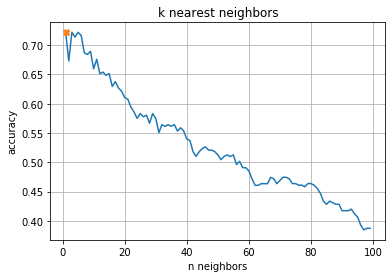

In [120]:
plt.plot(resknn["param_n_neighbors"],resknn["mean_test_score"])
plt.plot(cv.best_params_['n_neighbors'],cv.best_score_,marker="X")
plt.grid()
plt.title("k nearest neighbors")
plt.xlabel("n neighbors")
plt.ylabel("accuracy")

In [121]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train_pd, y_train)

train_acc = accuracy_score(model.predict(X_train_pd), y_train)
test_acc = accuracy_score(model.predict(X_test_pd), y_test)

print("KNN train accuracy:", train_acc)
#print("SVM test accuracy:", test_acc)
cv_knn = cross_val_score(model, X_train_pd, y_train, scoring=make_scorer(accuracy), cv=5,n_jobs=-1)
print("KNN CV score:", np.mean(cv_knn))

KNN train accuracy: 1.0
KNN CV score: 0.72217697149204


In [122]:
results_classifier=results_classifier.append({"model":model,
                                              "description":"KNN(1)",
                           "train score":train_acc, 
                           "cv score":np.mean(cv_knn)},ignore_index=True)

### 2.6.1 SelectKBest

Since it takes a long time to run, we are going to limit our search from 1 to 20 features.

In [123]:
Kfeatu=np.arange(1,21)
Kneigh=np.arange(1,21,5)
model = Pipeline([('selector', SelectKBest(mutual_info_classif)),
                  ('classifier', KNeighborsClassifier())])
k=np.arange(1,76)
params = {'selector__k': Kfeatu,
         'classifier__n_neighbors':Kneigh}
cv = GridSearchCV(model, params, scoring=make_scorer(accuracy), cv=5,n_jobs=-1,verbose=False)
cv = cv.fit(X_train_pd, y_train)

In [126]:
reskb=pd.DataFrame(cv.cv_results_)
reskb.sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4        1.232599      0.042979         0.008495        0.006358   
9        1.258693      0.038017         0.010400        0.001961   
10       1.235890      0.032740         0.009202        0.000399   
11       1.354501      0.062879         0.010001        0.001548   
17       1.614318      0.224746         0.010802        0.000981   
..            ...           ...              ...             ...   
21       1.530586      0.018227         0.015630        0.000002   
60       1.703526      0.030841         0.012201        0.000749   
40       1.602441      0.023543         0.015630        0.000003   
20       1.510886      0.053537         0.015629        0.000001   
0        1.217676      0.094139         0.015452        0.012204   

   param_classifier__n_neighbors param_selector__k  \
4                              1                 5   
9                              1                10   
10                             1                11   
11                             1                12   
17                             1                18   
..                           ...               ...   
21                             6                 2   
60                            16                 1   
40                            11                 1   
20                             6                 1   
0                              1                 1   

                                               params  split0_test_score  \
4    {'classifier__n_neighbors': 1, 'selector__k': 5}           0.837838   
9   {'classifier__n_neighbors': 1, 'selector__k': 10}           0.824324   
10  {'classifier__n_neighbors': 1, 'selector__k': 11}           0.837838   
11  {'classifier__n_neighbors': 1, 'selector__k': 12}           0.797297   
17  {'classifier__n_neighbors': 1, 'selector__k': 18}           0.837838   
..                                                ...                ...   
21   {'classifier__n_neighbors': 6, 'selector__k': 2}           0.608108   
60  {'classifier__n_neighbors': 16, 'selector__k': 1}           0.500000   
40  {'classifier__n_neighbors': 11, 'selector__k': 1}           0.391892   
20   {'classifier__n_neighbors': 6, 'selector__k': 1}           0.486486   
0    {'classifier__n_neighbors': 1, 'selector__k': 1}           0.418919   

    split1_test_score  split2_test_score  split3_test_score  \
4            0.837838           0.849315           0.863014   
9            0.837838           0.876712           0.794521   
10           0.824324           0.876712           0.794521   
11           0.824324           0.876712           0.794521   
17           0.770270           0.849315           0.767123   
..                ...                ...                ...   
21           0.527027           0.589041           0.602740   
60           0.418919           0.506849           0.410959   
40           0.418919           0.479452           0.452055   
20           0.418919           0.397260           0.438356   
0            0.297297           0.410959           0.315068   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
4            0.821918         0.841984        0.013660                1  
9            0.780822         0.822843        0.033755                2  
10           0.780822         0.822843        0.033755                2  
11           0.780822         0.814735        0.034047                4  
17           0.808219         0.806553        0.033708                5  
..                ...              ...             ...              ...  
21           0.575342         0.580452        0.029037               76  
60           0.452055         0.457756        0.039813               77  
40           0.493151         0.447094        0.037507               78  
20           0.452055         0.438615        0.030234               79  
0            0.342466         0.356942        0.049557

#### Result
We get the best results with five features and one neighbor, CV score 0.84.

In [127]:
print(cv.best_params_)
print(cv.best_score_)

{'classifier__n_neighbors': 1, 'selector__k': 5}
0.8419844502036282


Text(0.5, 1.0, 'Scores')

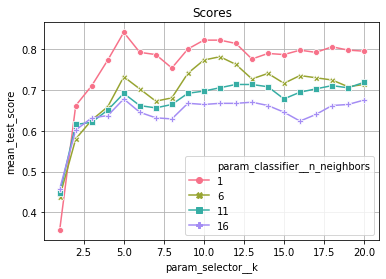

In [128]:
palette = sns.color_palette("husl", 4)
sns.lineplot(x=reskb["param_selector__k"],y=reskb["mean_test_score"],hue=reskb["param_classifier__n_neighbors"],palette=palette,
            markers=True,dashes=False, style=reskb["param_classifier__n_neighbors"])
plt.grid()
plt.title("Scores")

In [129]:
model = Pipeline([('selector', SelectKBest(mutual_info_classif,k=5)),
                  ('classifier', KNeighborsClassifier(n_neighbors=1))])
model.fit(X_train_pd, y_train)

train_acc = accuracy_score(model.predict(X_train_pd), y_train)
test_acc = accuracy_score(model.predict(X_test_pd), y_test)

print("KNN train accuracy:", train_acc)
cv_ksel = cross_val_score(model, X_train_pd, y_train, scoring=make_scorer(accuracy), cv=5,n_jobs=-1)
print("KNN CV score:", np.mean(cv_ksel))

KNN train accuracy: 1.0
KNN CV score: 0.8419844502036282


In [130]:
results_classifier=results_classifier.append({"model":model,
                                              "description":"KNN(1) 5 best",
                           "train score":train_acc, 
                           "cv score":np.mean(cv_knn)},ignore_index=True)

<div id="2.7"></div>

## 2.7 Conclusions

Let us compare the performances of all the models we trained so far.

In [131]:
results_classifier[["description","train score","cv score"]]

description  train score  cv score
0   logistic regression     1.000000  0.637653
1                 lasso     0.991826  0.820511
2                 ridge     1.000000  0.714106
3                   LDA     0.972752  0.787671
4           LDA forward     0.959128  0.891188
5           LDA forward     0.959128  0.891188
6           LDA 36 best     0.910082  0.839393
7          QDA complete     1.000000  0.207071
8           QDA forward     1.000000  0.926435
9           QDA 12 best     0.994550  0.923806
10           SVM linear     0.975477  0.733025
11             SVM poly     1.000000  0.733025
12              SVM RBF     1.000000  0.817623
13               KNN(1)     1.000000  0.722177
14        KNN(1) 5 best     1.000000  0.722177

In [132]:
m=np.argmax(results_classifier["cv score"])
print("Best model: ")
print(results_classifier.iloc[m][["description","train score","cv score"]])
best_model=results_classifier.iloc[m]["model"]

Best model: 
description    QDA forward
train score              1
cv score          0.926435
Name: 8, dtype: object


The best performances were obtained with **quadratic discriminant** analysis and **forward feature selection**. Let's get this model and visualize the performances on the training set, then test it on the test set.

In [133]:
print(bf_qda)

['pPKCG_N', 'pERK_N', 'pCAMKII_N', 'Tau_N', 'NUMB_N', 'BAX_N', 'NR2A_N', 'ELK_N', 'P3525_N', 'AMPKA_N', 'RAPTOR_N', 'pCASP9_N', 'ADARB1_N']


We can plot the **confusion matrix** to compare the predictions with the true class labels.

Train:


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

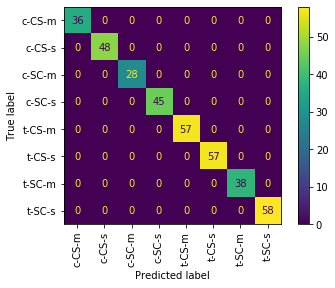

In [134]:
print("Train:")
plot_confusion_matrix(best_model, X_train_pd[bf_qda], y_train)
plt.xticks(rotation='vertical')

In [135]:
print("Test accuracy:", accuracy(y_test, best_model.predict(X_test_pd[bf_qda])))

Test accuracy: 0.9183673469387755


Test:


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

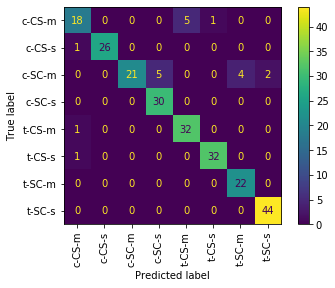

In [136]:
print("Test:")
plot_confusion_matrix(best_model, X_test_pd[bf_qda], y_test)
plt.xticks(rotation='vertical')

The test accuracy is in line with the cross validation score. We can see that a few points get misclassified.

How the points are classified depends on the threshold we choose for predictions. We can have a more general idea of the performances by plotting the ROC curve, which is slightly different in the multi-class case, since we need to binarize the class variable first.  
Code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [137]:
from sklearn.metrics import roc_curve

In [138]:
# Binarize the output

from sklearn.preprocessing import label_binarize
y_train_bin = label_binarize(y_train, classes=classes)
n_classes = y_train_bin.shape[1]
y_test_bin = label_binarize(y_test, classes=classes)

In [139]:
y_score = model_qda_reduced.decision_function(X_test_pd[bf_qda])

In [140]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

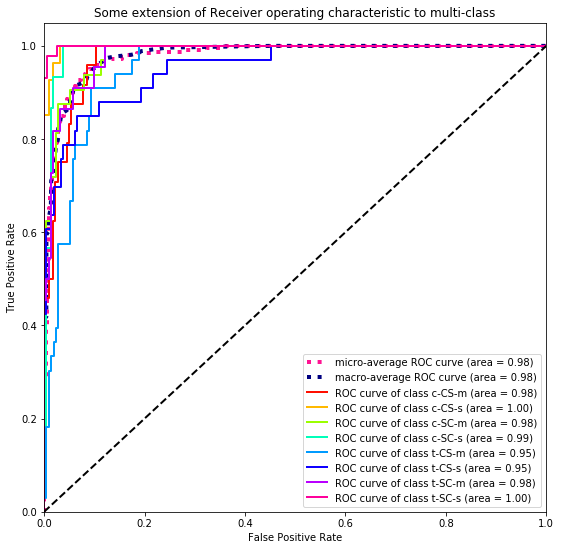

In [141]:
from numpy import interp

lw=2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(9,9))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = colors
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

<div id="regr"></div>

# 3. Regression
3.1 <a href="#3.1">Importing modules and data</a>  
3.2 <a href="#3.2">Data visualization</a>   
3.3 <a href="#3.3">Linear regression with OLS</a>  
&nbsp;&nbsp;&nbsp;&nbsp;3.3.1 Simple  
&nbsp;&nbsp;&nbsp;&nbsp;3.3.2 Polynomial terms  
3.4 <a href="#3.4">Feature selection</a>   
&nbsp;&nbsp;&nbsp;&nbsp;3.4.1 Forward   
&nbsp;&nbsp;&nbsp;&nbsp;3.4.2 Lasso  
&nbsp;&nbsp;&nbsp;&nbsp;3.4.3 Ridge    
3.4 <a href="#3.5">K nearest regression</a>  
&nbsp;&nbsp;&nbsp;&nbsp;1.3.1 Forward selection    
3.6 <a href="#3.6">Conclusions</a>

The **SOD1_N** feature is missing in the test dataset. We are going to learn a regressor for it from the training dataset, and use it to predict the measurement in the test dataset.

<div id="3.1"></div>

## 3.1 Importing modules and data

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import f_regression

Since the test set has no values of SOD1_N to use for the testing phase, we will further split the traning dataset into a train and test set.

In [143]:
mpg_test_size = 0.2
mpg_test_seed = 2
# Split X and y into train and test
train_pd, test_pd = train_test_split(train,
                                         test_size=mpg_test_size,
                                         random_state=mpg_test_seed)
X_train_small=train_pd.drop(["SOD1_N","class"],axis=1)
X_test_small=test_pd.drop(["SOD1_N","class"],axis=1)

In [144]:
y_train_small=train_pd["SOD1_N"]
y_test_small=test_pd["SOD1_N"]

<div id="3.2"></div>

## 3.2 Data visualization

We want to see which features correlate the most with SOD1_N. We will compute the Pearson correlation coefficient and the mutual information.

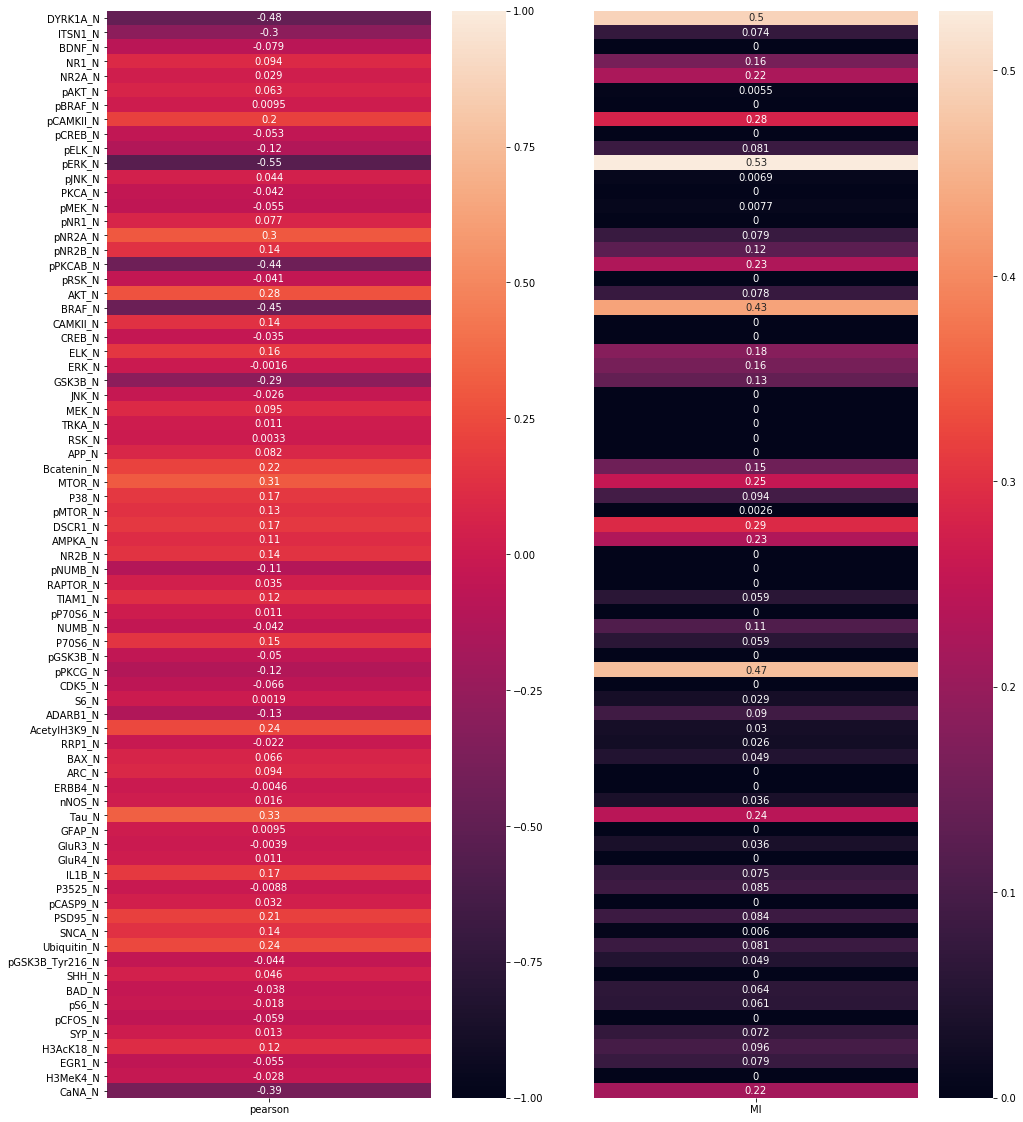

In [145]:
cormat=train_pd.corr()
c=pd.DataFrame(cormat["SOD1_N"])
c.columns = ["pearson"]
c=c.drop("SOD1_N",axis=0)
mi_sod=sklearn.feature_selection.mutual_info_regression(X_train_small,y_train_small)
c["MI"]=mi_sod
fig=plt.figure(figsize=(16,20))
plt.subplot(1,2,1)
sns.heatmap(c.iloc[:,0:1], vmin=-1, vmax=1, annot=True)
plt.subplot(1,2,2)
sns.heatmap(c.iloc[:,1:2], annot=True,yticklabels=False)

Generally, to a high absolute value of the Pearson correlation coefficient corresponds a high value of the MI score. There are some cases in which the MI is high while the p is low: this might mean there is a non-linear relation between that feature and SOD1_N, as happens for pPKCG_N.

In [146]:
related_p=(c[c["MI"]>0.2]).index
print(related_p)

Index(['DYRK1A_N', 'NR2A_N', 'pCAMKII_N', 'pERK_N', 'pPKCAB_N', 'BRAF_N',
       'MTOR_N', 'DSCR1_N', 'AMPKA_N', 'pPKCG_N', 'Tau_N', 'CaNA_N'],
      dtype='object')


To visualize the distribution of SOD1_N we plot a histogram. Next we plot some paired scatterplots with SOD1_N and the 12 features with the highest MI.

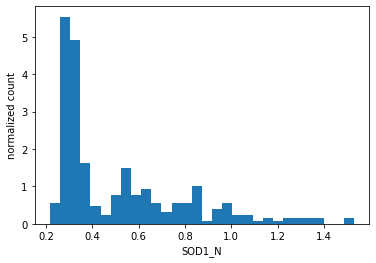

In [147]:
plt.hist(y_train_small,bins=30,density=True)
plt.xlabel("SOD1_N")
plt.ylabel("normalized count")
plt.show()

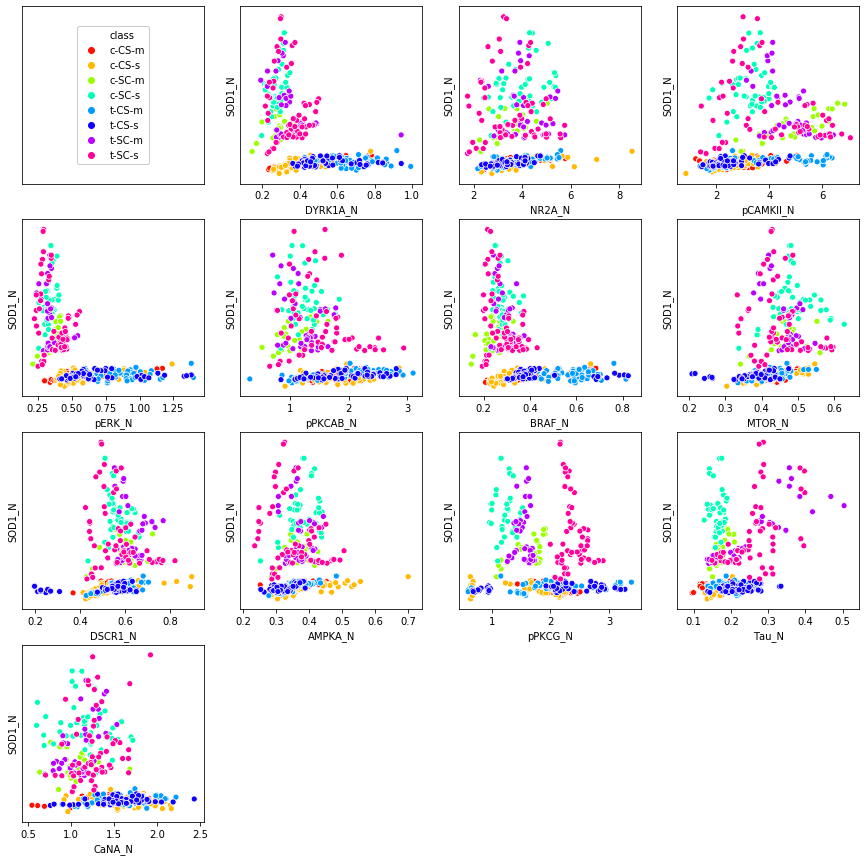

In [148]:
fig=plt.figure(figsize=(15,15))
plt.subplot(4,4,1)
ax=sns.scatterplot(0,0,hue=sorttrain["class"],palette=colors)
ax.set_yticks([])
ax.set_xticks([])
plt.legend(loc="center",framealpha=1)
for i in range(len(related_p)):
    plt.subplot(4,4,i+2)
    ax=sns.scatterplot(sorttrain[related_p[i]],sorttrain["SOD1_N"],hue=sorttrain["class"],palette=colors,legend=False)
    ax.set_yticks([])


We can see that the value of SOD1_N depends heavily on the class. As before, we can see a division depending on the type of stimulus (CS or SC).

<div id="3.3"></div>

## 3.3 Linear regression with OLS
In linear regression a continuous output is modeled as a linear combination of the features.  

$Y = \beta_0 + \beta^TX $   

It is a parametric method in which the goal is to find the parameters $\beta$ which will give us the most accurate estimation of the real underlying relationship between y and the covariates.

With the ordinary least squares algorithm,we find the coefficients that minimiza the residual sum of squares on the training data, which is the sum of the difference between the predicted response $\widehat{y}$  and the actual value $y$. 

### 3.3.1 Simple linear regression 

In [149]:
model = LinearRegression(fit_intercept=True)       
model.fit(X_train_small, y_train_small)                                    
y_predict = model.predict(X_train_small) 

To assess the goodness of fit, we are going to consider two measures:
- R2 score  
- MSE  

For both of them, we are going to do a 5 fold cross validation.

In [150]:
print("train R2 score ", r2_score(y_train_small, y_predict))
print("Train MSE score ", mean_squared_error(y_train_small, y_predict))
#y_test_pred = model.predict(X_test)   
#print("Test R2 score ", r2_score(y_test, y_test_pred))
#print("Test MSE score ", mean_squared_error(y_test, y_test_pred))
cvsco=cross_val_score(model, X_train_small, y_train_small,scoring=make_scorer(r2_score),cv=5)
print("CV R2 score:" ,np.mean(cvsco))
cvsco=cross_val_score(model, X_train_small, y_train_small,scoring=make_scorer(mean_squared_error),cv=5)
print("CV MSE score:" ,np.mean(cvsco))

train R2 score  0.8031906123770947
Train MSE score  0.015748761662352614
CV R2 score: 0.6257326109155518
CV MSE score: 0.029790297968573215


This model has a pretty low $R^2$ score. We can check statistical significance of the coefficients with the `statsmodels` API which will allow us to easily see statistics for each coefficient.

In [151]:
#X_train
X_complete_intercept = sm.add_constant(X_train_small) # adding a constant
#X_complete_intercept = np.concatenate([np.ones([X_train.shape[0], 1]), X_train], axis=-1)
ols_model = sm.OLS(y_train_small.to_numpy().reshape(-1),X_complete_intercept)
ols_results = ols_model.fit()
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     11.81
Date:                Tue, 13 Jul 2021   Prob (F-statistic):           2.39e-46
Time:                        14:58:52   Log-Likelihood:                 192.37
No. Observations:                 293   AIC:                            -232.7
Df Residuals:                     217   BIC:                             46.95
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0409      0.187     -0.219      0.827      -0.409       0.327
DYRK1A_N           -0.3939      0.178     -2.214      0.028      -0.745      -0.043
ITSN1_N             0.0355      0.053      0.664      0.508      -0.070       0.141
BDNF_N             -0.0221      0.053     -0.414      0.679      -0.127       0.083
NR1_N               0.0284      0.045      0.628      0.531      -0.061       0.118
NR2A_N             -0.0058      0.028     -0.206      0.837      -0.061       0.049
pAKT_N              0.0158      0.055      0.285      0.776      -0.093       0.125
pBRAF_N            -0.0549      0.068     -0.807      0.420      -0.189       0.079
pCAMKII_N          -0.0047      0.013     -0.369      0.713      -0.030       0.021
pCREB_N            -0.1264      0.058     -2.166      0.031      -0.241      -0.011
pELK_N              0.1146      0.041      2.787      0.006       0.034       0.196
pERK_N             -0.6057      0.177     -3.424      0.001      -0.954      -0.257
pJNK_N              0.0443      0.049      0.895      0.372      -0.053       0.142
PKCA_N              0.0055      0.054      0.102      0.919      -0.101       0.112
pMEK_N              0.0069      0.057      0.121      0.904      -0.106       0.120
pNR1_N              0.0860      0.049      1.751      0.081      -0.011       0.183
pNR2A_N             0.1002      0.042      2.379      0.018       0.017       0.183
pNR2B_N            -0.0313      0.044     -0.713      0.476      -0.118       0.055
pPKCAB_N           -0.0397      0.038     -1.055      0.292      -0.114       0.034
pRSK_N              0.0097      0.049      0.199      0.843      -0.087       0.106
AKT_N               0.0847      0.049      1.720      0.087      -0.012       0.182
BRAF_N              0.4030      0.272      1.482      0.140      -0.133       0.939
CAMKII_N            0.1236      0.051      2.402      0.017       0.022       0.225
CREB_N             -0.0711      0.066     -1.080      0.281      -0.201       0.059
ELK_N               0.0217      0.043      0.501      0.617      -0.064       0.107
ERK_N              -0.0716      0.037     -1.937      0.054      -0.144       0.001
GSK3B_N            -0.0120      0.047     -0.254      0.800      -0.106       0.082
JNK_N               0.0697      0.057      1.220      0.224      -0.043       0.182
MEK_N               0.0800      0.055      1.457      0.147      -0.028       0.188
TRKA_N              0.0230      0.048      0.476      0.634      -0.072       0.118
RSK_N               0.0178      0.066      0.271      0.786      -0.112       0.147
APP_N               0.0169      0.050      0.337      0.736      -0.082       0.116
Bcatenin_N          0.2519      0.045      5.544      0.000       0.162       0.341
MTOR_N              1.7173      0.348      4.933      0.000

What features are significant?

In [152]:
df_result=pd.DataFrame()
df_result['pvalues']=ols_results.pvalues[1:]
significant=df_result[df_result["pvalues"]<0.05]
print(significant.shape[0],"features are significant")
significant

14 features are significant


pvalues
DYRK1A_N    2.789868e-02
pCREB_N     3.138313e-02
pELK_N      5.799993e-03
pERK_N      7.381596e-04
pNR2A_N     1.823382e-02
CAMKII_N    1.713537e-02
Bcatenin_N  8.552322e-08
MTOR_N      1.614000e-06
AMPKA_N     3.302861e-03
pPKCG_N     5.157691e-03
ADARB1_N    1.371270e-03
nNOS_N      4.198496e-02
Tau_N       1.361216e-05
SNCA_N      2.539901e-02

A way to check if the assumptions of the model are verified is visualizing the residual plots. The residuals are the difference between $y$ and $\widehat{y}$ and they should be normally distributed around 0.  
We can do this by plotting the residuals against $\widehat{y}$: they should form a cloud centered around 0 with no significant pattern (*homoscedasticity*).  
The qqplot allows us to check if they are normally distributed: the points should follow the theoretical quantiles of the normal distribution, which are plotted in red.

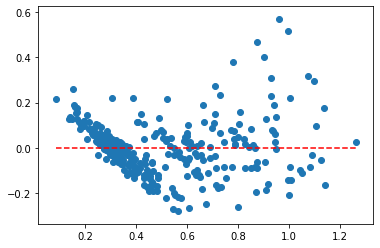

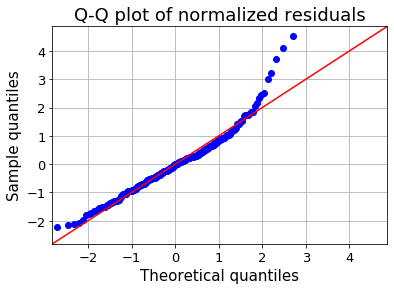

In [153]:
yhat=ols_results.fittedvalues
residuals_complete=ols_results.resid
plt.scatter(x=yhat, y=residuals_complete)
plt.hlines(y=0,xmin=min(yhat),xmax=max(yhat),color="red",linestyle="--")
compl=ols_results.resid_pearson
fig=qqplot(compl,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

The residual plots show some pattern and the qqplot devies significantly from the theoretical distribution, so this type of model might be a good fit for the data.  

### 3.3.2 Polynomial terms

The definition of a linear model is pretty flexible. We can have *generalized* linear models which are linear in the coefficients but can be not linear in the original feature space. In fact, logistic regression is a particular case of a generalized linear model.  
More simply, we can perform a polynomial transformation of our features while still using the OLS algorithm to solve the problem and see if we capture better the existing relations.

In [154]:
r2_scorer = make_scorer(r2_score,
                        greater_is_better=True)
mse_scorer = make_scorer(mean_squared_error,
                        greater_is_better=False)

In [155]:
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': [2,3]}
              #'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5, n_jobs=-1, verbose=False)
cv.fit(X_train_small, y_train_small)
print("Done!")

Done!


In [156]:
pd.DataFrame(cv.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.392934      0.058046         0.013401        0.009068   
1       9.256112      0.212432         0.062517        0.022103   

  param_poly__degree               params  split0_test_score  \
0                  2  {'poly__degree': 2}           0.472097   
1                  3  {'poly__degree': 3}           0.355793   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.593866           0.416454           0.514688           0.375927   
1           0.451334           0.235645           0.395586           0.191524   

   mean_test_score  std_test_score  rank_test_score  
0         0.474607        0.076099                1  
1         0.325976        0.097659                2

The $R^2$ score does not improve with polynomial terms.

<div id="3.4"></div>

## 3.4 Feature selection

Several methods for feature selection are available. We are going to perform forward feature selection, lasso regularization and ridge regularization.

### 3.4.1 Forward feature selection

We use as evaluation score the cross-validated $R^2$.

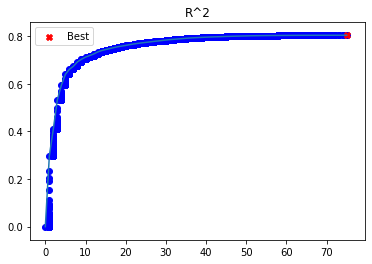

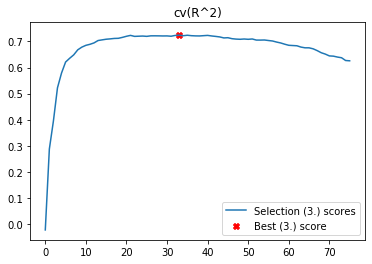

In [157]:
bf_linear,bscore,scores=general_ff(X_train_small, y_train_small, 
                            X_test_small, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  get_cv_evaluator(make_scorer(r2_score), cv=5), np.argmax, # 3.
                  #get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="R^2",
                  subsets_scorer_name="cv(R^2)",
                  verbose=False,
                   dummyModel=DummyRegressor,mod=LinearRegression,fit_intercept=True)

The best results were obtained with 33 features and gave a cv score of 0.724.

We can train this model with the statsmodels API and test statistical significance.

In [158]:
features_forw = bf_linear
X_reduced=X_train_small[features_forw]
X_reduced_intercept = sm.add_constant(X_reduced) # adding a constant
red_model = sm.OLS(y_train_small.to_numpy().reshape(-1),X_reduced_intercept)
red_results = red_model.fit()
residuals_red=red_results.resid
yhat_red=red_results.fittedvalues
df_result_red=pd.DataFrame()
df_result_red['pvalues']=red_results.pvalues[1:]
significant_red=df_result_red[df_result_red["pvalues"]<0.05]
print("There are",significant_red.shape[0],"significant features")
significant_red

There are 20 significant features


pvalues
pERK_N      4.037917e-06
Bcatenin_N  1.068553e-10
Tau_N       6.880068e-11
MTOR_N      1.112620e-08
ADARB1_N    4.748131e-04
pPKCG_N     1.453828e-03
AMPKA_N     8.883138e-05
AKT_N       1.433509e-02
pELK_N      1.367282e-03
DSCR1_N     7.076797e-03
pNR2A_N     5.363375e-03
BRAF_N      1.984140e-02
DYRK1A_N    6.445508e-03
CAMKII_N    1.264468e-02
SNCA_N      1.037894e-02
ARC_N       2.181580e-02
pCREB_N     1.182756e-02
P38_N       4.577354e-02
nNOS_N      3.346667e-02
pP70S6_N    1.445994e-02

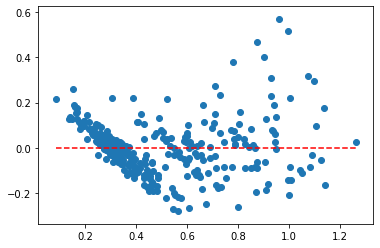

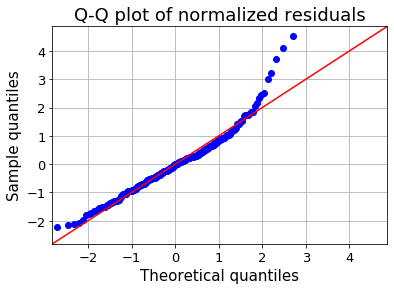

In [159]:
plt.scatter(x=yhat, y=residuals_complete)
plt.hlines(y=0,xmin=min(yhat),xmax=max(yhat),color="red",linestyle="--")
compl=ols_results.resid_pearson
fig=qqplot(compl,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

The plots look very similar to the complete linear regression. In fact the two models are based on the same assumptions and trained the same way, so the residual plots cannot be very different.

### 3.4.2 Lasso

Lasso is defined also for linear regression. As before, we try to optimize the C parameter.

In [160]:
model = Pipeline([('scaler',preprocessing.StandardScaler()), 
               ('regressor',Lasso())])
alphap=np.linspace(5e-5,0.01,11)
params = {'regressor__alpha': alphap}
cv = GridSearchCV(model, params, refit="MSE", cv=5, 
                  scoring={"R^2": make_scorer(r2_score,greater_is_better=True),
                          "MSE": make_scorer(mean_squared_error,greater_is_better=False)})
cv.fit(X_train_small, y_train_small)
print("Done!")

Done!


In [161]:
resLasso=pd.DataFrame(cv.cv_results_)
resLasso.sort_values(by="rank_test_MSE")[["param_regressor__alpha","mean_test_R^2","std_test_R^2","mean_test_MSE","std_test_MSE","rank_test_R^2","rank_test_MSE"]]

param_regressor__alpha  mean_test_R^2  std_test_R^2  mean_test_MSE  \
4                 0.00403       0.670175      0.054349      -0.026120   
5                0.005025       0.669655      0.055576      -0.026179   
3                0.003035       0.668419      0.051471      -0.026246   
6                 0.00602       0.667323      0.055384      -0.026383   
2                 0.00204       0.664112      0.043270      -0.026584   
7                0.007015       0.662988      0.056053      -0.026762   
8                 0.00801       0.658637      0.056984      -0.027162   
9                0.009005       0.655326      0.058377      -0.027498   
1                0.001045       0.653130      0.038764      -0.027527   
10                   0.01       0.651858      0.059656      -0.027816   
0                   5e-05       0.627841      0.041373      -0.029621   

    std_test_MSE  rank_test_R^2  rank_test_MSE  
4       0.006487              1              1  
5       0.006620              2              2  
3       0.006292              3              3  
6       0.006693              4              4  
2       0.005880              5              5  
7       0.006886              6              6  
8       0.007144              7              7  
9       0.007451              8              8  
1       0.006072              9              9  
10      0.007668             10             10  
0       0.006843             11             11

The best model has a score of 0.67.

### 3.4.3 Ridge

In [162]:
model = Pipeline([('scaler',preprocessing.StandardScaler()), 
               ('regressor',Ridge())])
alphap=np.linspace(5e-5,0.01,11)
params = {'regressor__alpha': alphap}
cv = GridSearchCV(model, params, refit="MSE", cv=5, 
                  scoring={"R^2": make_scorer(r2_score,greater_is_better=True),
                          "MSE": make_scorer(mean_squared_error,greater_is_better=False)})
cv.fit(X_train_small, y_train_small)
print("Done!")

Done!


In [163]:
resRidge=pd.DataFrame(cv.cv_results_)
resRidge.sort_values(by="rank_test_MSE")[["param_regressor__alpha","mean_test_R^2","std_test_R^2","mean_test_MSE","std_test_MSE","rank_test_R^2","rank_test_MSE"]]

param_regressor__alpha  mean_test_R^2  std_test_R^2  mean_test_MSE  \
10                   0.01       0.625788      0.041659      -0.029785   
9                0.009005       0.625783      0.041660      -0.029786   
8                 0.00801       0.625777      0.041662      -0.029786   
7                0.007015       0.625772      0.041664      -0.029787   
6                 0.00602       0.625766      0.041666      -0.029787   
5                0.005025       0.625761      0.041667      -0.029788   
4                 0.00403       0.625755      0.041669      -0.029788   
3                0.003035       0.625750      0.041671      -0.029789   
2                 0.00204       0.625744      0.041672      -0.029789   
1                0.001045       0.625738      0.041674      -0.029790   
0                   5e-05       0.625733      0.041676      -0.029790   

    std_test_MSE  rank_test_R^2  rank_test_MSE  
10      0.006890              1              1  
9       0.006890              2              2  
8       0.006890              3              3  
7       0.006891              4              4  
6       0.006891              5              5  
5       0.006891              6              6  
4       0.006892              7              7  
3       0.006892              8              8  
2       0.006892              9              9  
1       0.006893             10             10  
0       0.006893             11             11

The best model has a score of 0.62.

<div id="3.5"></div>

## 3.5 K-neighbors regression

Since parametric methods did not have outstanding performances, we can try a non-parametric method. K-neighbors can be used for regression by predicting a value of $y$ as the average of the $y$ values of the *k* points closest to the new observation. Like in k-neighbors classifier, the hyperparameter *k* needs to be optimized and is related to the variance of the model. To predict we can either use the average of all *k* neighbors (uniform weights) or a **weighted** average in which closest points have higher weight.

In [164]:
model=KNeighborsRegressor(n_neighbors=5)
neigh2=np.arange(1,20,1)
params = [{"n_neighbors":neigh2,
          "weights":["uniform","distance"]}]
cv = GridSearchCV(model, params, refit="MSE", cv=5, 
                  scoring={"R^2": make_scorer(r2_score,greater_is_better=True),
                          "MSE": make_scorer(mean_squared_error,greater_is_better=False)},verbose=False,
                 n_jobs=-1)
cv.fit(X_train_small, y_train_small)
print("done!")

done!


In [165]:
reskreg=pd.DataFrame(cv.cv_results_)[["param_n_neighbors","param_weights","mean_test_R^2","std_test_R^2","mean_test_MSE","std_test_MSE","rank_test_R^2","rank_test_MSE"]]
reskreg.sort_values(by="rank_test_R^2")

param_n_neighbors param_weights  mean_test_R^2  std_test_R^2  \
13                 7      distance       0.640967      0.045865   
19                10      distance       0.638342      0.057643   
17                 9      distance       0.638253      0.066723   
12                 7       uniform       0.637186      0.042199   
21                11      distance       0.636047      0.056910   
15                 8      distance       0.633529      0.056900   
18                10       uniform       0.633528      0.057341   
16                 9       uniform       0.633470      0.065804   
20                11       uniform       0.631118      0.056273   
14                 8       uniform       0.628556      0.054816   
11                 6      distance       0.623323      0.061246   
23                12      distance       0.620798      0.063225   
25                13      distance       0.619278      0.067023   
10                 6       uniform       0.619257      0.058236   
22                12       uniform       0.614433      0.063794   
24                13       uniform       0.612713      0.067980   
27                14      distance       0.606742      0.066261   
9                  5      distance       0.603048      0.071740   
26                14       uniform       0.598692      0.067153   
8                  5       uniform       0.597554      0.069462   
31                16      distance       0.595643      0.065848   
29                15      distance       0.595068      0.068555   
7                  4      distance       0.592868      0.097787   
33                17      distance       0.591742      0.060368   
6                  4       uniform       0.587213      0.098081   
30                16       uniform       0.586631      0.066226   
28                15       uniform       0.586125      0.069465   
5                  3      distance       0.584867      0.067212   
35                18      distance       0.583419      0.064321   
32                17       uniform       0.582694      0.060066   
4                  3       uniform       0.580099      0.065665   
37                19      distance       0.576806      0.063719   
34                18       uniform       0.573937      0.064583   
36                19       uniform       0.566854      0.064079   
3                  2      distance       0.490960      0.157445   
2                  2       uniform       0.484204      0.162212   
1                  1      distance       0.468326      0.117285   
0                  1       uniform       0.468326      0.117285   

    mean_test_MSE  std_test_MSE  rank_test_R^2  rank_test_MSE  
13      -0.028723      0.006938              1              2  
19      -0.028623      0.006881              2              1  
17      -0.028755      0.007803              3              3  
12      -0.029010      0.006800              4              6  
21      -0.028787      0.006791              5              4  
15      -0.029099      0.007139              6              7  
18      -0.028972      0.006813              7              5  
16      -0.029104      0.007722              8              8  
20      -0.029147      0.006703              9              9  
14      -0.029462      0.006989             10             10  
11      -0.030048      0.007785             11             13  
23      -0.029930      0.007161             12             11  
25      -0.030000      0.007255             13             12  
10      -0.030355      0.007630             14             14  
22      -0.030399      0.007137             15             15  
24      -0.030480      0.007239             16             16  
27      -0.031047      0.007491             17             17  
9       -0.031489      0.008273             18             18  
26      -0.031648      0.007502             19             19  
8       -0.031894      0.008105             20             20  
31      -0.032086      0.008027             2

Text(0.5, 1.0, 'Scores')

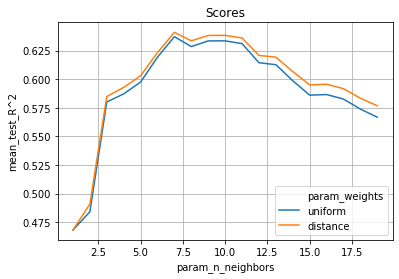

In [166]:
sns.lineplot(x=reskreg["param_n_neighbors"],y=reskreg["mean_test_R^2"],hue=reskreg["param_weights"],
            markers=True,dashes=False)
plt.grid()
plt.title("Scores")

We get the best results with k=7 neighbors.  
K neigbors has problems with high dimensions, so we can try to select features and optimize at the same time the number of features and the number of neighbors. (This is going to take some minutes to run).

In [167]:
knr_features=[]
knr_scores=[]
knr_bestscores=[]
neigh3=[1,3,5,7,9,11]
for n in neigh3:
    print("Neighbors: ",n)
    bf,bscore,scores=general_ff(X_train_small, y_train_small, X_test_small, y_test_small,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  get_cv_evaluator(make_scorer(r2_score), cv=5), np.argmax, # 3.
                  #get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="R^2",
                  subsets_scorer_name="cv(R^2)",
                  verbose=False, weight_step3=5,plot_results=False,
                   dummyModel=DummyRegressor,mod=KNeighborsRegressor,n_neighbors=n)
    knr_features.append(bf)
    knr_scores.append(scores)
    knr_bestscores.append(bscore)

Neighbors:  1
Neighbors:  3
Neighbors:  5
Neighbors:  7
Neighbors:  9
Neighbors:  11


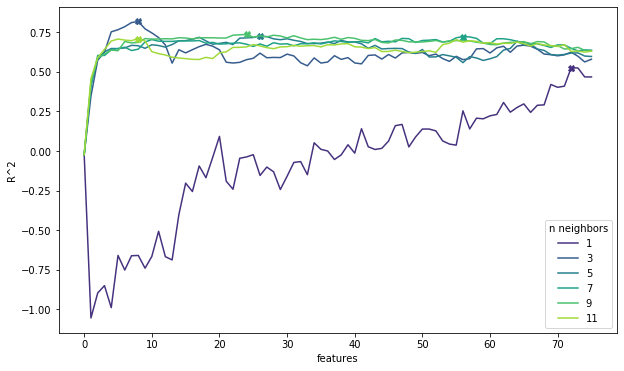

In [168]:
nfeatures=np.arange(0,76,1)
palette = sns.color_palette("viridis", len(neigh3))
fig=plt.figure(figsize=(10,6))
for i in range(len(neigh3)):
    #plt.subplot(2,3,i+1)
    plt.plot(nfeatures,knr_scores[i],color=palette[i],label=neigh3[i])
    m=np.argmax(knr_scores[i])
    plt.plot(nfeatures[m],knr_scores[i][m],marker="X",color=palette[i])
    plt.xlabel("features")
    plt.ylabel("R^2")
plt.legend(title="n neighbors")

In [169]:
m=np.argmax(knr_bestscores)
print("The best result was obtained with",neigh3[m],"neighbors")
print("Best score: ",np.max(knr_bestscores))
print("Best features:",knr_features[m])

The best result was obtained with 3 neighbors
Best score:  0.8186474093168631
Best features: ['pERK_N', 'AMPKA_N', 'DSCR1_N', 'Tau_N', 'NUMB_N', 'DYRK1A_N', 'MTOR_N', 'BAX_N']


The best performances were obtained with 3 neighbors and 8 features: we are able to obtain a cross validation score of 0.82.

<div id="3.6"></div>

## 3.6 Conclusions

Modelling the relationship between SOD1_N and the other features with a linear regression model did not capture well the data. We were able to get better results with K-neighbor classifier, however there is a risk of overfitting the data. Thus, we test the selected model on the test dataset we put aside earlier.

In [170]:
bestfinalf=knr_features[m]
model_final=KNeighborsRegressor(n_neighbors=3)
model_final.fit(X_train_small[bestfinalf],y_train_small)
y_predict_train=model_final.predict(X_train_small[bestfinalf])

print("train R2 score ", r2_score(y_train_small, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train_small, y_predict_train))

cvsco=cross_val_score(model_final, X_train_small[bestfinalf], y_train_small,scoring=make_scorer(r2_score),cv=5)
print("CV R2 score:" ,np.mean(cvsco))
cvsco=cross_val_score(model_final, X_train_small[bestfinalf], y_train_small,scoring=make_scorer(mean_squared_error),cv=5)
print("CV MSE score:" ,np.mean(cvsco))

y_predict_test = model_final.predict(X_test_small[bestfinalf])
   
print("Test R2 score ", r2_score(y_test_small, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test_small, y_predict_test))

train R2 score  0.9399329627059947
Train MSE score  0.004806587051220711
CV R2 score: 0.8186474093168631
CV MSE score: 0.014848534185856691
Test R2 score  0.9010836627364303
Test MSE score  0.009346515412151913


This model performs nicely on the test set.

<div id="reco"></div>

# 4. Data recovery and classification
4.1 <a href="#4.1">Data recovery</a>  
4.2 <a href="#4.2">Classification</a>  

We are going to apply the regression model we just trained to predict some SOD1_N values for the test set. Then we will train again the best clessifier model on the training data, this time using also the SOD1_N feature, and check if the performances on the training and/or test set improve.

<div id="4.1"></div>

### 4.1 Data recovery

In [171]:
sod1_test_predicted = model_final.predict(test[bestfinalf])
test["SOD1_N"]=sod1_test_predicted

Let's visualize this new feature and check its distribution compared to the training set.

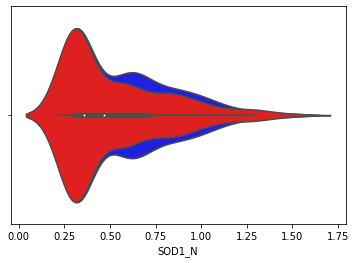

In [172]:
sns.violinplot(x=test["SOD1_N"],color="blue")
sns.violinplot(x=train["SOD1_N"],color="red")

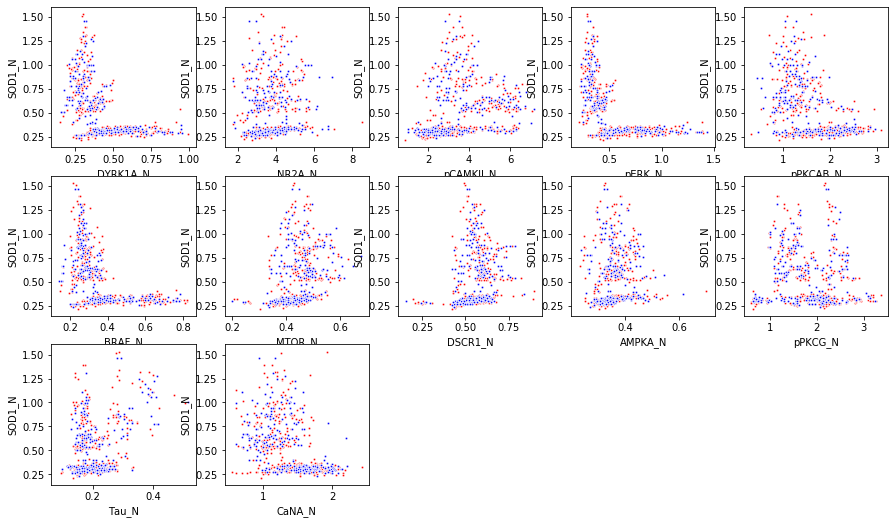

In [173]:
i=1
fig=plt.figure(figsize=(15,15))
for f in related_p:
    plt.subplot(5,5,i)
    i=i+1
    sns.scatterplot(x=train[f],y=train["SOD1_N"],color="red",s=7)
    sns.scatterplot(x=test[f],y=test["SOD1_N"],color="blue",s=7)
    #plt.legend()

In [174]:
X_train_pd=train.drop("class",axis=1)
y_train=train["class"]
X_test_pd=test.drop("class",axis=1)
y_test=test["class"]
proteins=X_train_pd.columns

In [175]:
X_test=X_test_pd.reindex(proteins,axis=1)

<div id="4.2"></div>

## 4.2 Classification

We will perform again forward feature selection on the complete training dataset using QDA as a model. Again, we are going to hide warnings.

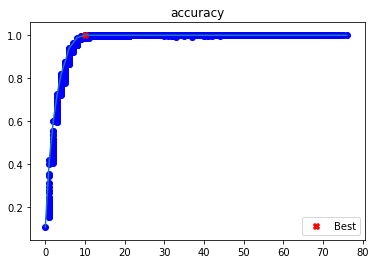

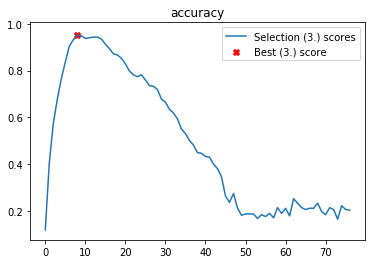

In [176]:
%%capture --no-stdout --no-display
bf_qda_new,bscore,scores=general_ff(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.b
                  get_cv_evaluator(make_scorer(accuracy), cv=5), np.argmax, # 3.
                  #get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="accuracy",
                  subsets_scorer_name="accuracy",
                  verbose=False,
                   dummyModel=DummyClassifier,mod=QDA,store_covariance=True)

In [177]:
print("The best performances were obtained with",len(bf_qda_new),"features")
print("CV score:",bscore)
print(bf_qda_new)

The best performances were obtained with 8 features
CV score: 0.9510181414291002
['pPKCG_N', 'SOD1_N', 'Tau_N', 'BAX_N', 'pCAMKII_N', 'BRAF_N', 'AMPKA_N', 'NUMB_N']


The performances slightly improve by using SOD1_N. We also select a lower number of features: this might mean that SOD1_N is more informative on the class labels than other proteins. For comparison, the proteins previously selected were

In [178]:
print(bf_qda)

['pPKCG_N', 'pERK_N', 'pCAMKII_N', 'Tau_N', 'NUMB_N', 'BAX_N', 'NR2A_N', 'ELK_N', 'P3525_N', 'AMPKA_N', 'RAPTOR_N', 'pCASP9_N', 'ADARB1_N']


In [179]:
classif_final=QDA(store_covariance=True)
classif_final.fit(X_train_pd[bf_qda_new],y_train)
y_pred_train=classif_final.predict(X_train_pd[bf_qda_new])
y_pred_test=classif_final.predict(X_test_pd[bf_qda_new])

In [180]:
print("Train accuracy:", accuracy(y_train, y_pred_train))
print("Test accuracy:", accuracy(y_test, y_pred_test))

Train accuracy: 0.989100817438692
Test accuracy: 0.9224489795918367


We had previously obtained very similar results, with a slightly lower train accuracy. This new model does have a slightly higher cross validation score.

Train:


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

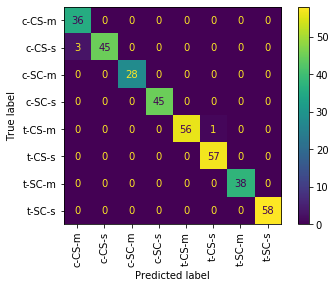

In [181]:
print("Train:")
plot_confusion_matrix(classif_final, X_train_pd[bf_qda_new], y_train)
plt.xticks(rotation='vertical')

Test:


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

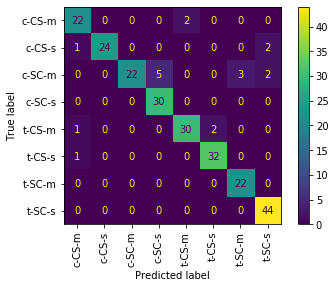

In [182]:
print("Test:")
plot_confusion_matrix(classif_final, X_test_pd[bf_qda_new], y_test)
plt.xticks(rotation='vertical')

There are still some misclassified samples, however both models have a high accuracy. Thus, we were able to fit a good model for recovering SOD1_N.

<div id="recap"></div>

# 5. Recap

To sum up:
1. In the **Preliminary analysis** section we saw that samples from mice that received the same stimulus group together, but it is not easy to cluster the samples in eight clusters corresponding to the classes. K-means performed better in this regard. We identified the proteins most related to the eight classes.  
2. In the **Classification** section we compared different algorithms and found out that feature selection improves performances. The best model was quadratic discriminant analysis on 13 features.  
3. In the **Regression** section we trained a k-nearest regressor which was able to accurately predict the SOD1_N feature on the training dataset using 8 features. We saw that parametric models performed worse.  
4. In the **data recovery** sections we re-trained QDA on the training dataset including SOD1_N and performing forward feature selection. This time, 8 features were selected, and SOD1_N was one of the most relevant, since it is among the first ones to be selected. This could mean that SOD1_N is more informative than some other proteins, or highly correlated with them, so that less features are needed to have the same information. Also, the performance on the test set using the values of SOD1_N predicted by the regressor of point 3. are very similar: this likely means we were able to accurately model SOD1_N.
